In [ ]:
!pip install torchinfo

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# from google.colab import drive

# drive.mount('/content/gdrive')

In [ ]:
import os
import numpy as np
import pandas as pd
import torchinfo
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torchvision import models
from torch.utils.data import Dataset , DataLoader
from torchvision import transforms
import torch.optim as optim
import torch.nn.functional as F

In [ ]:
class ISICDataset(Dataset):
  def __init__(self,img_dir,mask_dir,image_transform=None,mask_transform=None):
    self.img_dir = img_dir
    self.mask_dir = mask_dir
    self.image_transform = image_transform
    self.mask_transform = mask_transform

    self.image_list = sorted(os.listdir(img_dir))
    self.mask_list = sorted(os.listdir(mask_dir))

  def __len__(self):
      return len(self.mask_list)

  def __getitem__(self,idx):

    image_name = os.path.join(self.img_dir,self.image_list[idx])
    mask_name = os.path.join(self.mask_dir,self.mask_list[idx].replace('.jpg', '.png'))

    image = Image.open(image_name).convert('RGB')
    mask = Image.open(mask_name).convert('L')

    if self.image_transform:
      image = self.image_transform(image)
    if self.mask_transform:
      mask = self.mask_transform(mask)

    return image,mask

In [ ]:
root_dir = "/home/user/deep_learning_project/Image_segmentation_using_deep_learning-20241125T132408Z-001/Image_segmentation_using_deep_learning/Dataset"

train_image_dir = os.path.join(root_dir,'train')
train_masks_dir = os.path.join(root_dir,'train_masks')
test_image_dir = os.path.join(root_dir,'test')
test_masks_dir = os.path.join(root_dir,'test_masks')


train_image_transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=60),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_mask_transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=60),
    transforms.ToTensor(),
])

test_image_transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=60),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

test_mask_transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=60),
    transforms.ToTensor(),
])

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')

In [ ]:
train_dataset = ISICDataset(img_dir =train_image_dir , mask_dir =train_masks_dir,image_transform =train_image_transform,mask_transform =train_mask_transform)
test_dataset = ISICDataset(img_dir = test_image_dir , mask_dir = test_masks_dir,image_transform = test_image_transform,mask_transform = test_mask_transform)

train_loader = DataLoader(train_dataset,batch_size=16,shuffle=True)
test_loader = DataLoader(test_dataset,batch_size=16,shuffle=False)

In [ ]:
batch = next(iter(train_loader))
batch[0].size()

torch.Size([16, 3, 128, 128])

In [ ]:
# Print lengths of test_image_list and test_mask_list
print("Length of test_image_list:", len(train_dataset.image_list))
print("Length of test_mask_list:", len(train_dataset.mask_list))

Length of test_image_list: 900
Length of test_mask_list: 900


In [ ]:
# Print lengths of test_image_list and test_mask_list
print("Length of test_image_list:", len(test_dataset.image_list))
print("Length of test_mask_list:", len(test_dataset.mask_list))

Length of test_image_list: 379
Length of test_mask_list: 379


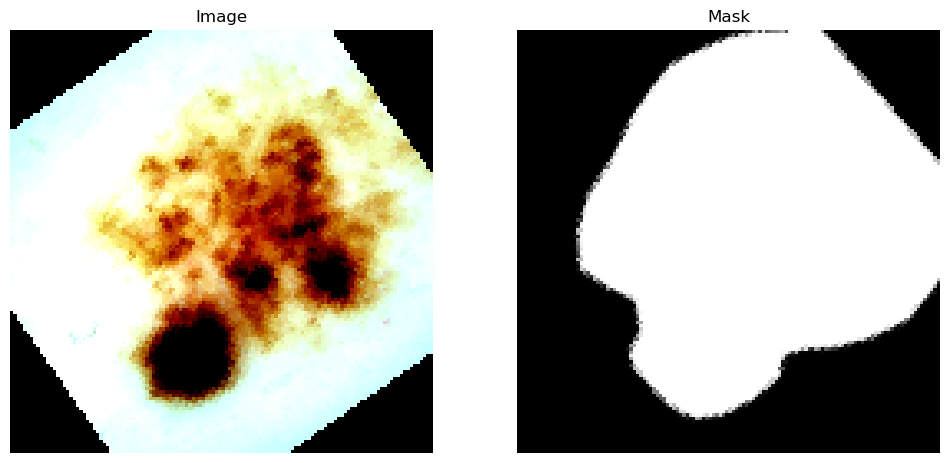

In [ ]:
def image_and_mask(image, mask):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    image = image.clip(0, 1)
    axes[0].imshow(image.permute(1, 2, 0))
    axes[0].set_title('Image')
    axes[0].axis('off')

    mask = mask.clip(0, 1)
    axes[1].imshow(mask.permute(1, 2, 0),cmap='gray')
    axes[1].set_title('Mask')
    axes[1].axis('off')

    plt.show()

for images, masks in train_loader:
    image_and_mask(images[0], masks[0])
    break

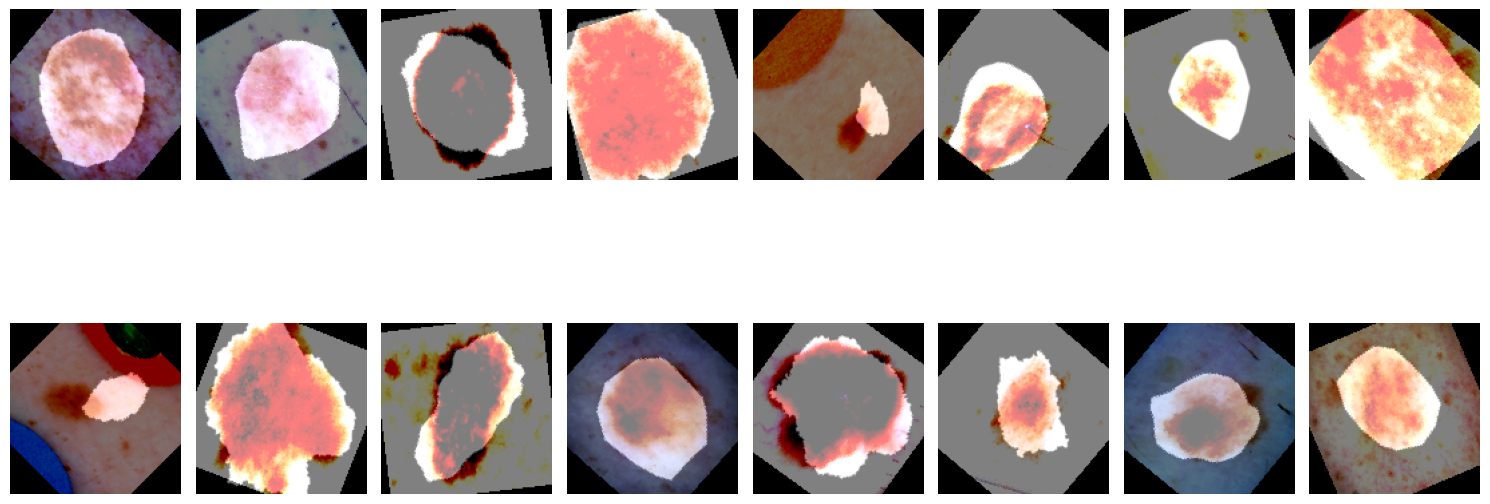

In [ ]:
def show_batch(batch):
    images, masks = batch
    batch_size = len(images)
    num_rows = 2
    num_cols = batch_size // num_rows

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 8))

    for i, ax in enumerate(axes.flat):
        image = images[i].permute(1, 2, 0).numpy().clip(0,1)
        mask = masks[i].permute(1, 2, 0).numpy().clip(0,1)
        ax.imshow(image)
        ax.imshow(mask, alpha=0.5,cmap='gray')
        ax.axis('off')

    plt.tight_layout()
    plt.show()


for batch in train_loader:
    show_batch(batch)
    break

In [ ]:
class Decoder(nn.Module):
    def __init__(self, num_classes):
        super(Decoder, self).__init__()
        self.conv1 = nn.Conv2d(1280, 512, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(512)
        self.relu1 = nn.ReLU(inplace=True)

        self.upsample1 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.conv2 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(256)
        self.relu2 = nn.ReLU(inplace=True)

        self.upsample2 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.conv3 = nn.Conv2d(256, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.relu3 = nn.ReLU(inplace=True)

        self.upsample3 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.conv4 = nn.Conv2d(64, 32, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(32)
        self.relu4 = nn.ReLU(inplace=True)

        self.upsample4 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.conv5 = nn.Conv2d(32, 16, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(16)
        self.relu5 = nn.ReLU(inplace=True)

        self.upsample5 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.final_conv = nn.Conv2d(16, num_classes, kernel_size=1)

        self.dropout = nn.Dropout(p=0.5)

        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu1(self.bn1(self.conv1(x)))
        x = self.upsample1(x)
        x = self.dropout(x)
        x = self.relu2(self.bn2(self.conv2(x)))
        x = self.upsample2(x)
        x = self.dropout(x)
        x = self.relu3(self.bn3(self.conv3(x)))
        x = self.upsample3(x)
        x = self.dropout(x)
        x = self.relu4(self.bn4(self.conv4(x)))
        x = self.upsample4(x)
        x = self.dropout(x)
        x = self.relu5(self.bn5(self.conv5(x)))
        x = self.upsample5(x)
        x = self.dropout(x)
        x = self.final_conv(x)
        return self.sigmoid(x)

In [ ]:
class SegmentationModel(nn.Module):
  def __init__(self,encoder,decoder):
    super(SegmentationModel,self).__init__()
    self.encoder = encoder
    self.decoder = decoder

  def forward(self,x):
    features = self.encoder.features(x)
    segmentation = self.decoder(features)
    return segmentation

In [ ]:
encoder = models.mobilenet_v2(pretrained=True)

/home/user/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/user/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
for param in encoder.parameters():
  param.requires_grad=False

In [ ]:
decoder = Decoder(num_classes=1)
model1 = SegmentationModel(encoder,decoder)
torchinfo.summary(model1,input_size=[16,3,128,128])

Layer (type:depth-idx)                                  Output Shape              Param #
SegmentationModel                                       [16, 1, 128, 128]         --
├─MobileNetV2: 1-1                                      --                        1,281,000
│    └─Sequential: 2-1                                  [16, 1280, 4, 4]          --
│    │    └─Conv2dNormActivation: 3-1                   [16, 32, 64, 64]          (928)
│    │    └─InvertedResidual: 3-2                       [16, 16, 64, 64]          (896)
│    │    └─InvertedResidual: 3-3                       [16, 24, 32, 32]          (5,136)
│    │    └─InvertedResidual: 3-4                       [16, 24, 32, 32]          (8,832)
│    │    └─InvertedResidual: 3-5                       [16, 32, 16, 16]          (10,000)
│    │    └─InvertedResidual: 3-6                       [16, 32, 16, 16]          (14,848)
│    │    └─InvertedResidual: 3-7                       [16, 32, 16, 16]          (14,848)
│    │    └─Inverte

In [ ]:
class SegmentationMetrics:
    def __init__(self, threshold=0.5):
        self.threshold = threshold

    def _convert_to_binary(self, probabilities):
        binary_predictions = (probabilities > self.threshold).float()
        return binary_predictions

    def intersection_over_union(self, outputs, masks):
        predictions = self._convert_to_binary(outputs)

        intersection = torch.sum(predictions * masks)
        union = torch.sum(predictions) + torch.sum(masks) - intersection

        epsilon = 1e-6
        iou = (intersection + epsilon) / (union + epsilon)

        return iou

    def dice_score(self, outputs, masks):
        predictions = self._convert_to_binary(outputs)

        intersection = torch.sum(predictions * masks)
        dice_score = (2.0 * intersection) / (torch.sum(predictions) + torch.sum(masks))

        return dice_score

metrics = SegmentationMetrics(threshold=0.5)

In [ ]:
def visualize(image,mask,pred):
  fig,axes = plt.subplots(1,3,figsize=(15,6))
  axes[0].imshow(image.permute(1,2,0).clip(0,1))
  axes[0].set_title('Image')
  axes[0].axis('off')

  axes[1].imshow(mask.permute(1,2,0).clip(0,1),cmap='gray')
  axes[1].set_title('Ground Truth Mask')
  axes[1].axis('off')

  axes[2].imshow(pred.permute(1, 2, 0),cmap='gray')
  axes[2].set_title('Predicted Mask')
  axes[2].axis('off')

  plt.tight_layout()
  plt.show()

In [ ]:
def visualize_samples(model, test_loader, device, num_samples_to_visualize=5):
    model.eval()
    with torch.no_grad():
        for i, (images, masks) in enumerate(test_loader):
            if i >= num_samples_to_visualize:
                break
            images = images.to(device)
            masks = masks.to(device)
            outputs = model(images)
            pred_masks = ((outputs) > 0.5).float()
            for j in range(len(images)):
                image = images[j].cpu()
                mask = masks[j].cpu()
                pred_mask = pred_masks[j].cpu()
                visualize(image, mask, pred_mask)
                break

In [ ]:
def evaluate(model,val_loader,criterion,device):
  model.eval()
  val_running_loss = 0
  total_iou = 0
  total_dice = 0
  i = 0
  with torch.no_grad():
    for val_images,val_masks in val_loader:
      val_images = val_images.to(device)
      val_masks = val_masks.to(device)
      val_outputs = model(val_images).to(device)
      val_loss = criterion(val_outputs,val_masks)
      val_running_loss += val_loss.item()*val_images.size(0)
      pred_masks = ((val_outputs)>0.5).float()
      val_iou = metrics.intersection_over_union(pred_masks,val_masks)
      val_dice = metrics.dice_score(pred_masks,val_masks)
      total_iou += val_iou.item()*val_images.size(0)
      total_dice += val_dice.item()*val_images.size(0)
      if i==0:
        visualize(val_images[0].cpu(), val_masks[0].cpu(), pred_masks[0].cpu())
        i+=1
    val_epoch_loss = val_running_loss/len(val_loader.dataset)
    avg_iou = total_iou / len(val_loader.dataset)
    avg_dice = total_dice / len(val_loader.dataset)
    return val_epoch_loss, avg_iou, avg_dice

def train(model,train_loader,criterion,optimizer,device):
  model.train()
  train_running_loss = 0
  for train_images,train_masks in train_loader:
    train_images = train_images.to(device)
    train_masks = train_masks.to(device)
    optimizer.zero_grad()
    outputs = model(train_images).to(device)
    loss = criterion(outputs,train_masks)
    loss.backward()
    optimizer.step()
    train_running_loss+=loss.item()*train_images.size(0)
  train_epoch_loss = train_running_loss/len(train_loader.dataset)
  return train_epoch_loss

In [ ]:
def train_evaluate_model(model,train_loader,val_loader,criterion,optimizer,device,num_epochs=10):
  train_loss_history ,val_loss_history = [] , []

  for epoch in range(num_epochs):
    train_loss = train(model,train_loader,criterion,optimizer,device)
    train_loss_history.append(train_loss)
    val_loss , val_iou , val_dice = evaluate(model,val_loader,criterion,device)
    val_loss_history.append(val_loss)
    print(f"Epoch {epoch+1}/{num_epochs}: Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, IoU: {val_iou:.4f}, Dice Score: {val_dice:.4f}")

  print("")
  print(f"Dice Score : {val_dice}")
  print("")
  print(f"IOU Score : {np.mean(val_iou)}")
  print("")

  plt.plot(range(1, num_epochs+1), train_loss_history, label='Training Loss')
  plt.plot(range(1, num_epochs+1), val_loss_history, label='Validation Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title('Training and Validation Loss')
  plt.legend()
  plt.show()

  return val_dice , val_iou , train_loss , val_loss

In [ ]:
class DiceLoss(nn.Module):
    def __init__(self):
        super(DiceLoss, self).__init__()

    def forward(self, predictions, targets):
        smooth = 1e-6
        predictions = predictions.contiguous()
        targets = targets.contiguous()

        intersection = (predictions * targets).sum(dim=2).sum(dim=2)
        dice = (2. * intersection + smooth) / (predictions.sum(dim=2).sum(dim=2) + targets.sum(dim=2).sum(dim=2) + smooth)

        return 1 - dice.mean()

In [ ]:
class CombinedLoss(nn.Module):
    def __init__(self):
        super(CombinedLoss, self).__init__()
        self.dice_loss = DiceLoss()
        self.bce_loss = nn.BCELoss()

    def forward(self, predictions, targets):
        dice = self.dice_loss(predictions, targets)
        bce = self.bce_loss(predictions, targets)
        return (dice*0.1) + bce

criterion = CombinedLoss()
optimizer = optim.Adam(model1.parameters(), lr=0.001, weight_decay=1e-5)
num_epochs = 45
model1 = model1.to(device)

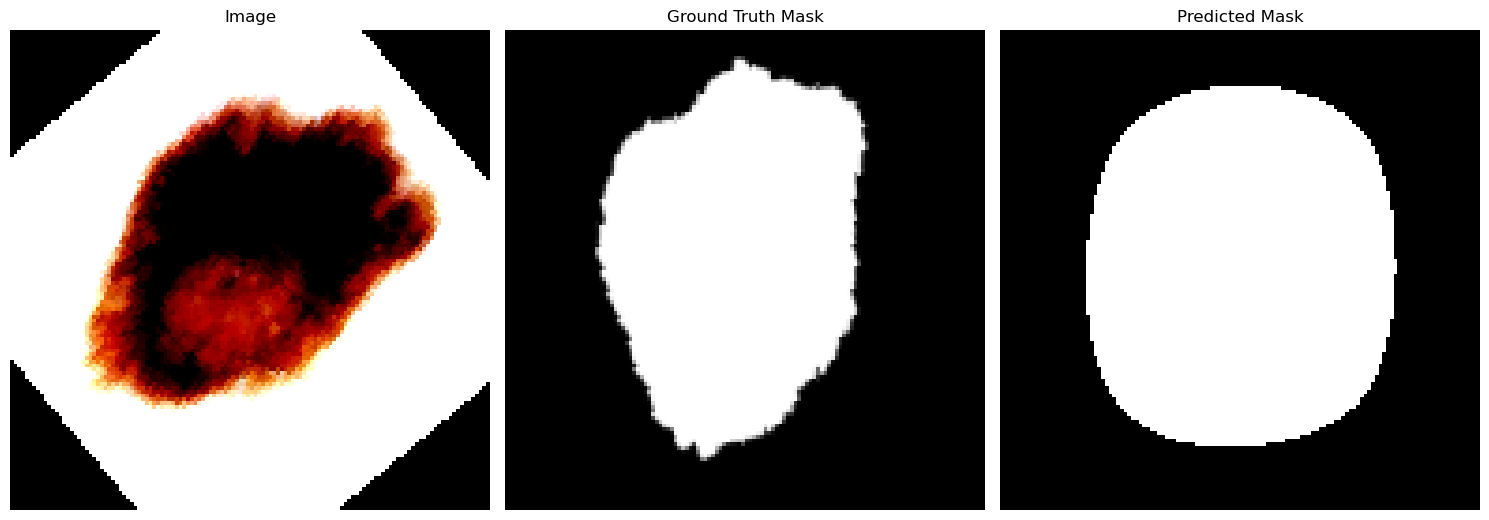

Epoch 1/45: Training Loss: 0.3069, Validation Loss: 0.3013, IoU: 0.5931, Dice Score: 0.7307


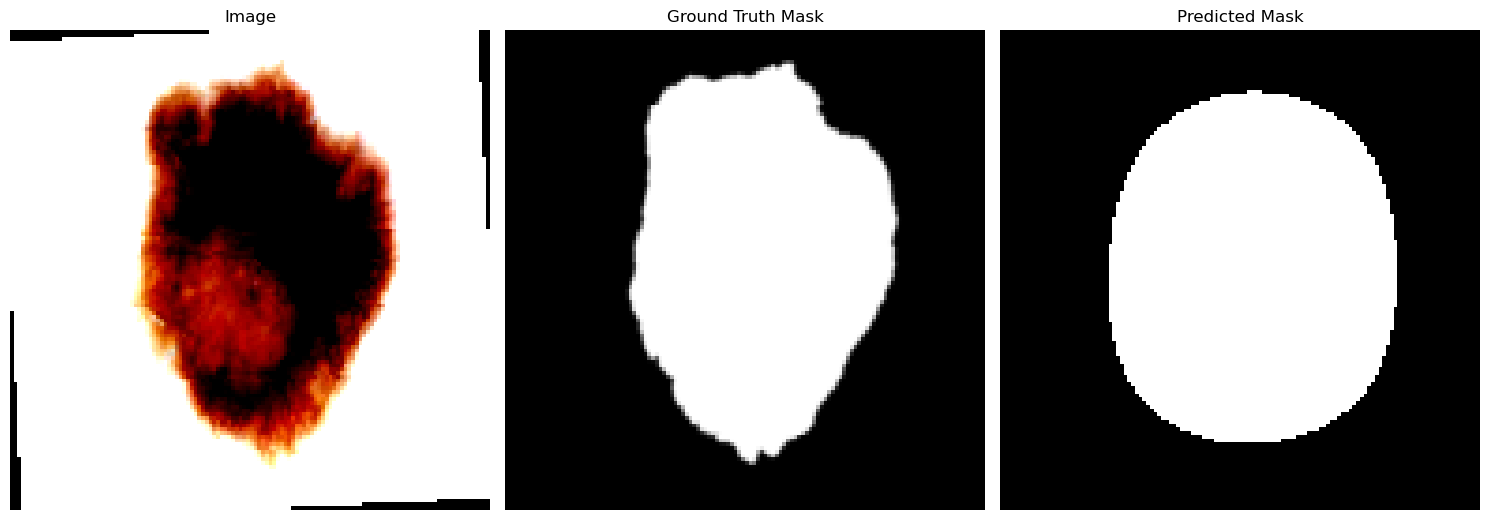

Epoch 2/45: Training Loss: 0.3076, Validation Loss: 0.3362, IoU: 0.5972, Dice Score: 0.7369


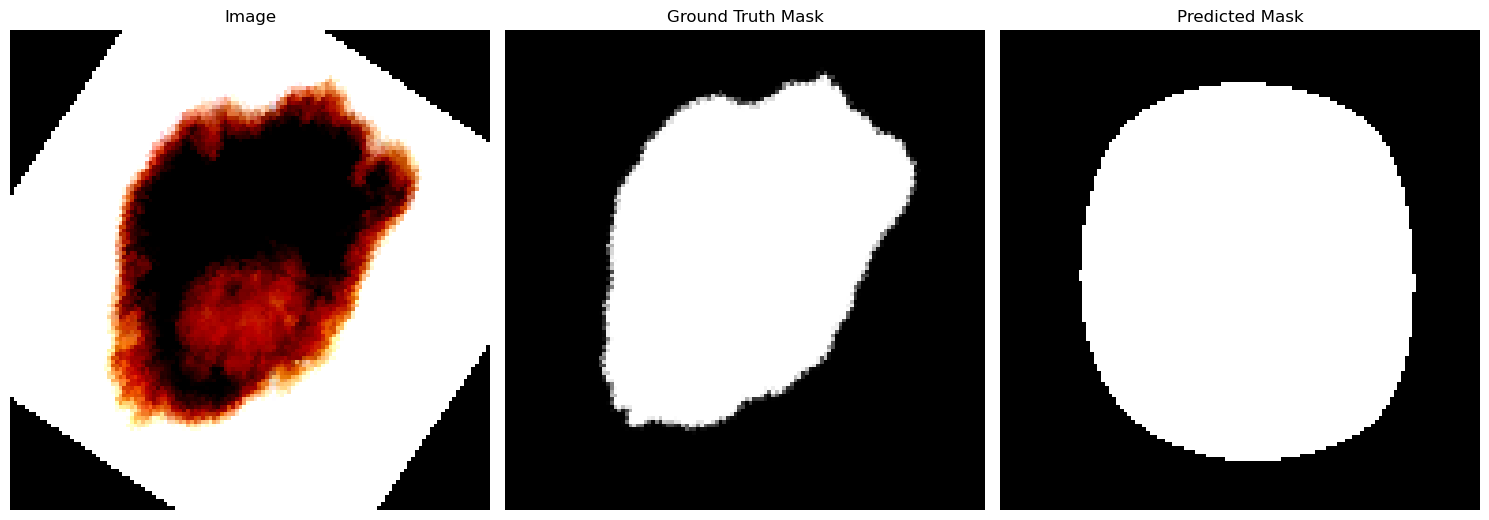

Epoch 3/45: Training Loss: 0.3135, Validation Loss: 0.2884, IoU: 0.6204, Dice Score: 0.7535


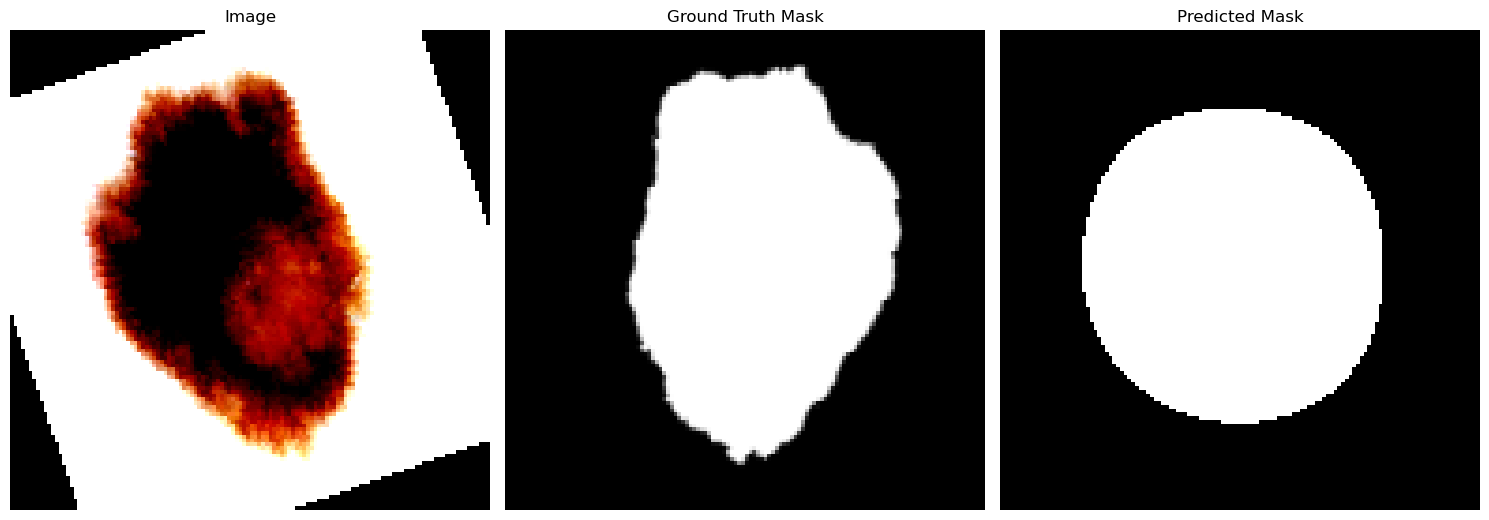

Epoch 4/45: Training Loss: 0.3071, Validation Loss: 0.2913, IoU: 0.6124, Dice Score: 0.7482


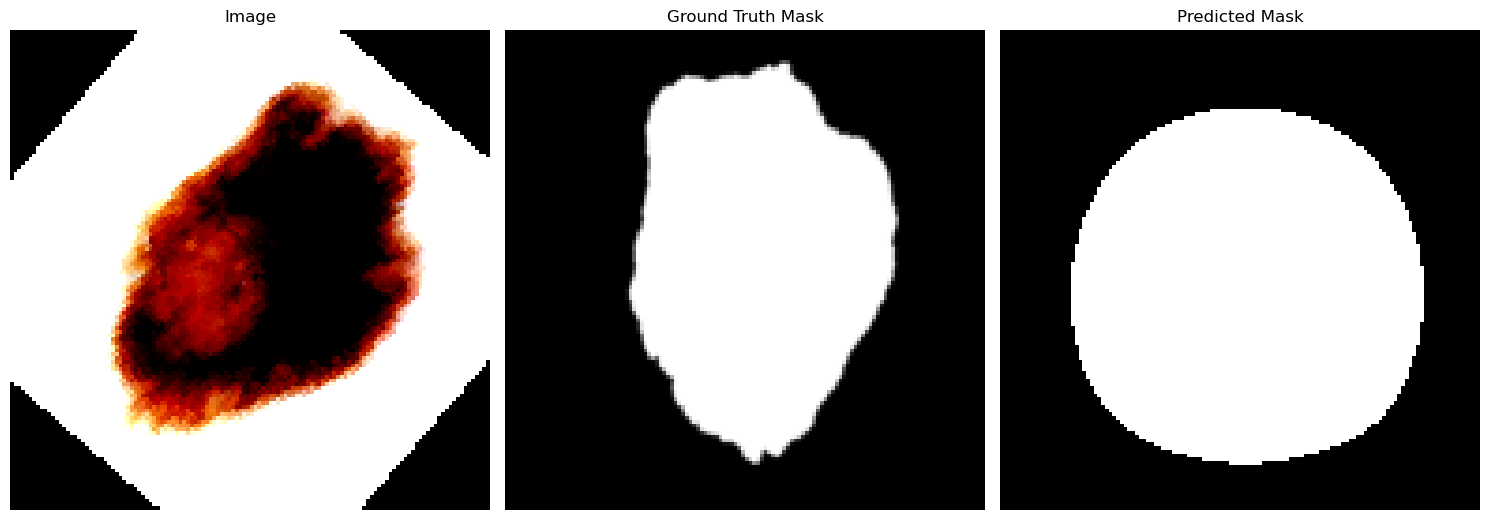

Epoch 5/45: Training Loss: 0.3018, Validation Loss: 0.3044, IoU: 0.6312, Dice Score: 0.7615


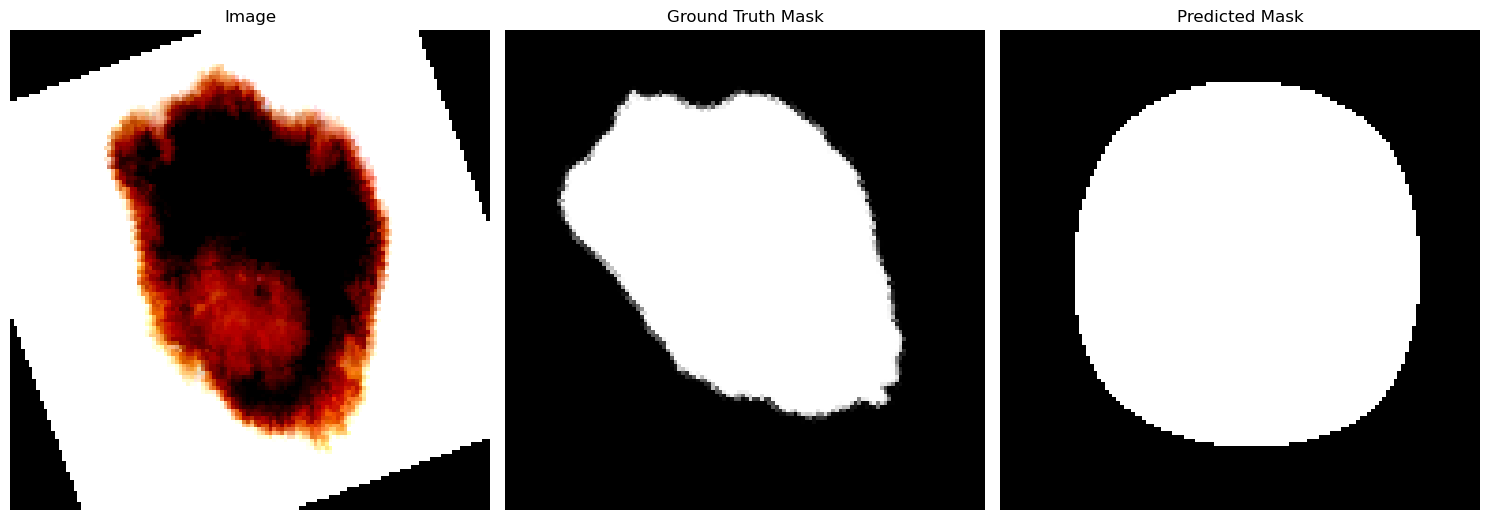

Epoch 6/45: Training Loss: 0.3135, Validation Loss: 0.2987, IoU: 0.6248, Dice Score: 0.7569


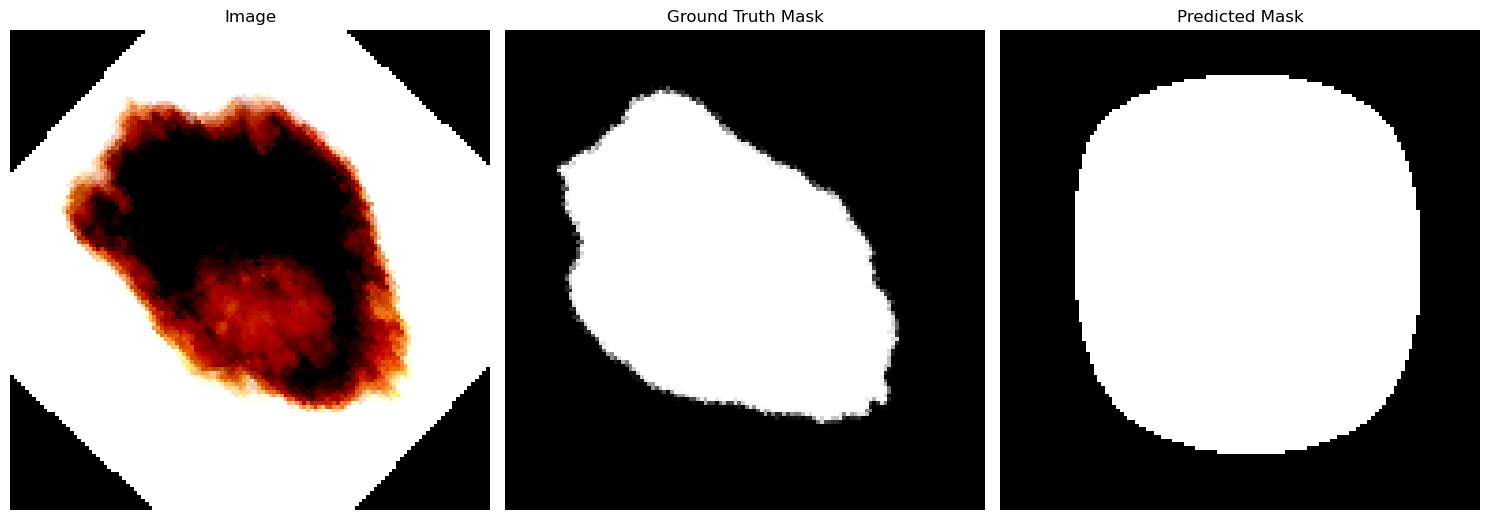

Epoch 7/45: Training Loss: 0.3044, Validation Loss: 0.2968, IoU: 0.6277, Dice Score: 0.7587


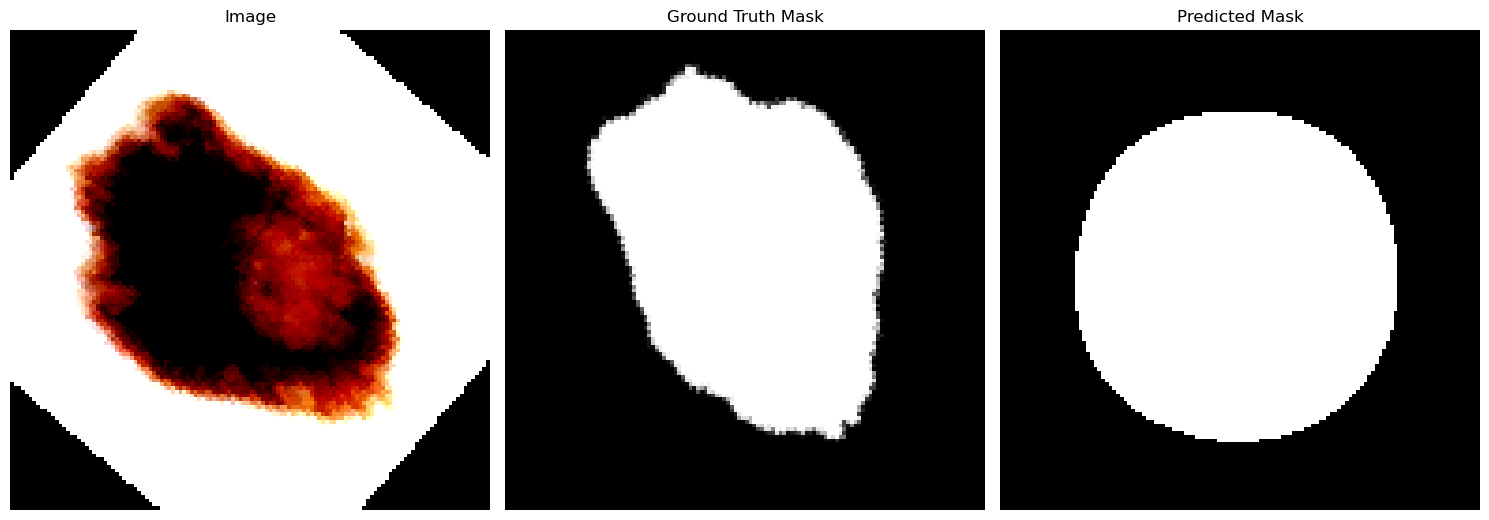

Epoch 8/45: Training Loss: 0.3043, Validation Loss: 0.2942, IoU: 0.5984, Dice Score: 0.7371


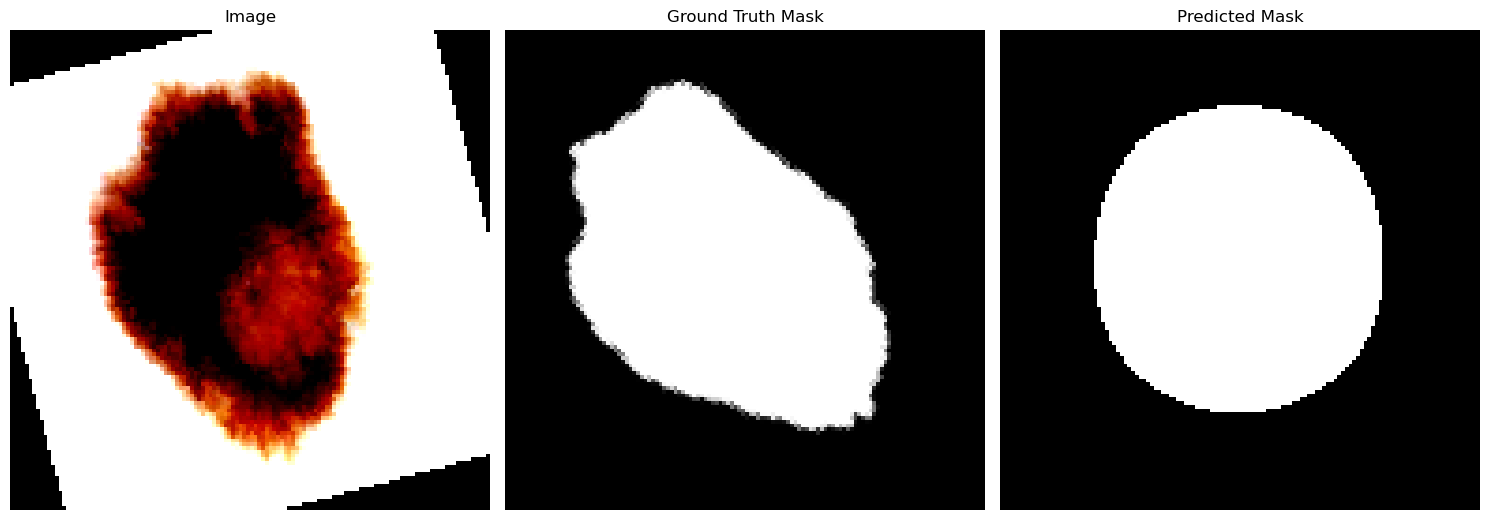

Epoch 9/45: Training Loss: 0.3027, Validation Loss: 0.3317, IoU: 0.5709, Dice Score: 0.7133


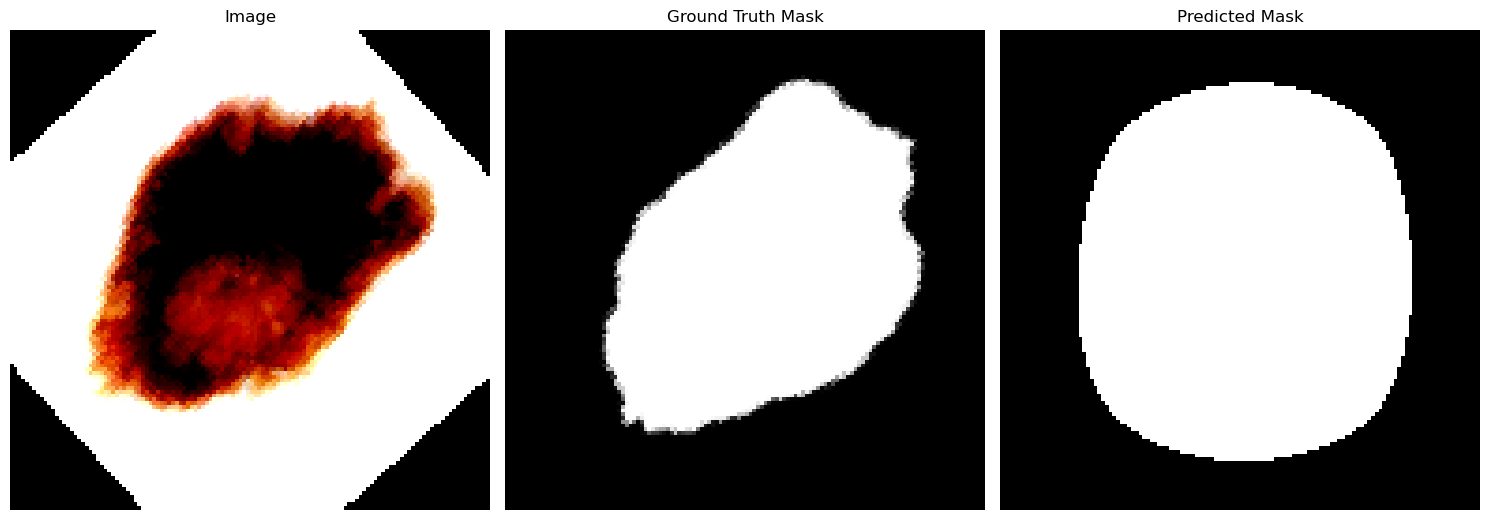

Epoch 10/45: Training Loss: 0.3038, Validation Loss: 0.2917, IoU: 0.6179, Dice Score: 0.7521


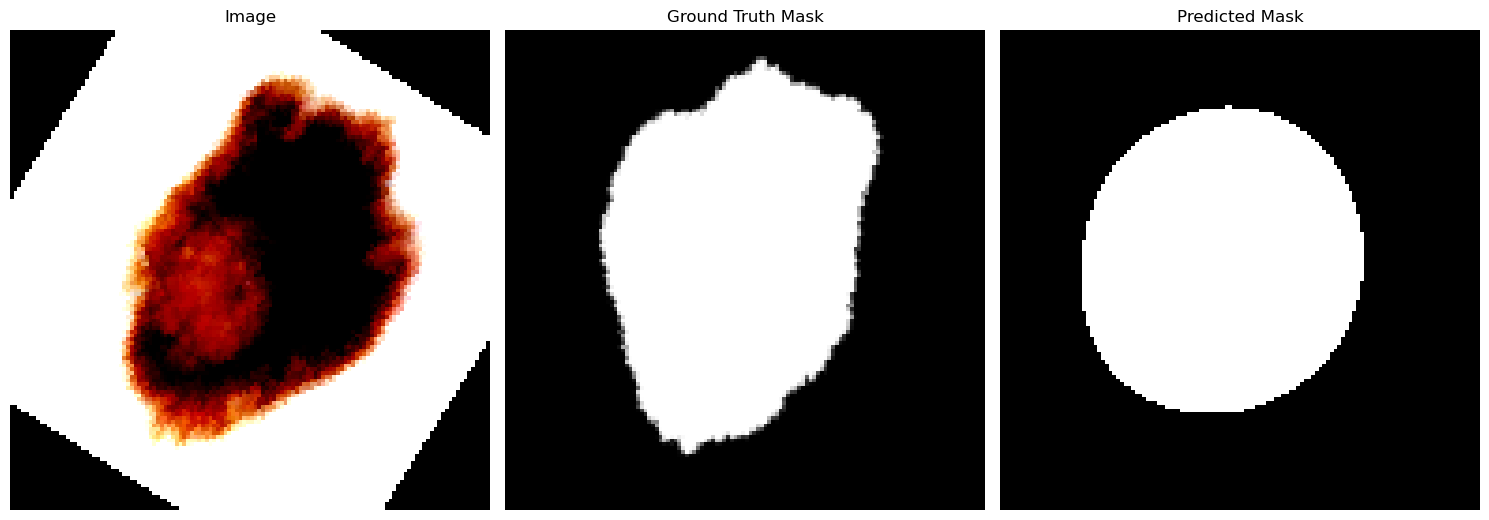

Epoch 11/45: Training Loss: 0.3110, Validation Loss: 0.3005, IoU: 0.5986, Dice Score: 0.7337


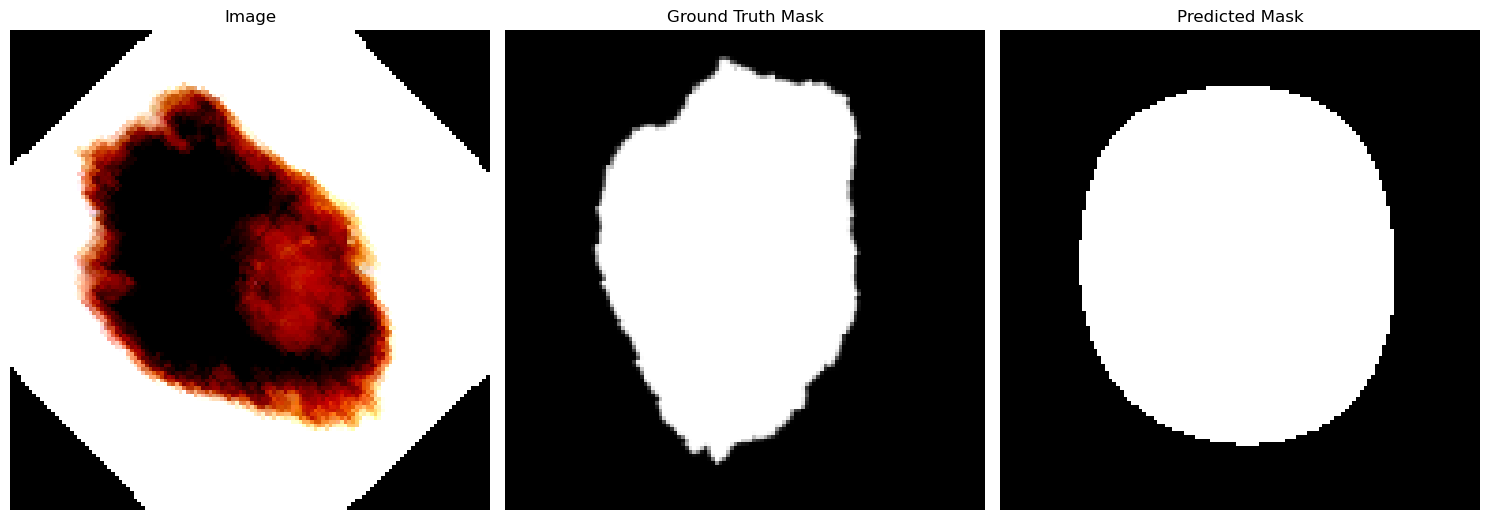

Epoch 12/45: Training Loss: 0.3117, Validation Loss: 0.2988, IoU: 0.6330, Dice Score: 0.7646


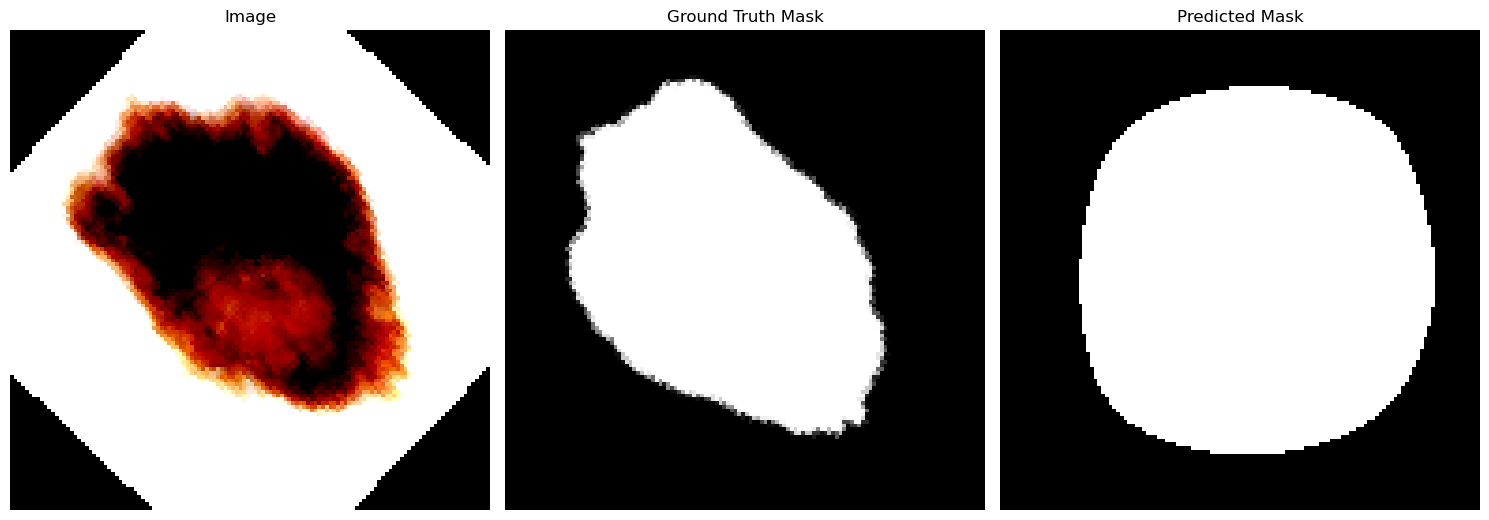

Epoch 13/45: Training Loss: 0.3029, Validation Loss: 0.3088, IoU: 0.6262, Dice Score: 0.7587


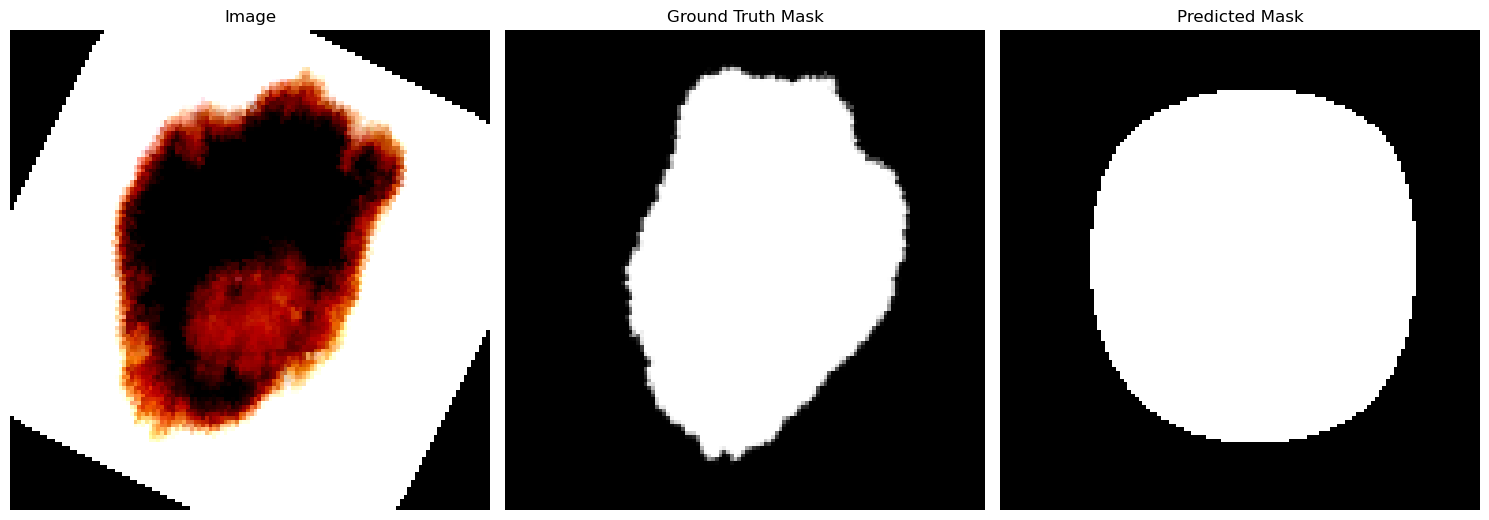

Epoch 14/45: Training Loss: 0.3047, Validation Loss: 0.2812, IoU: 0.6345, Dice Score: 0.7659


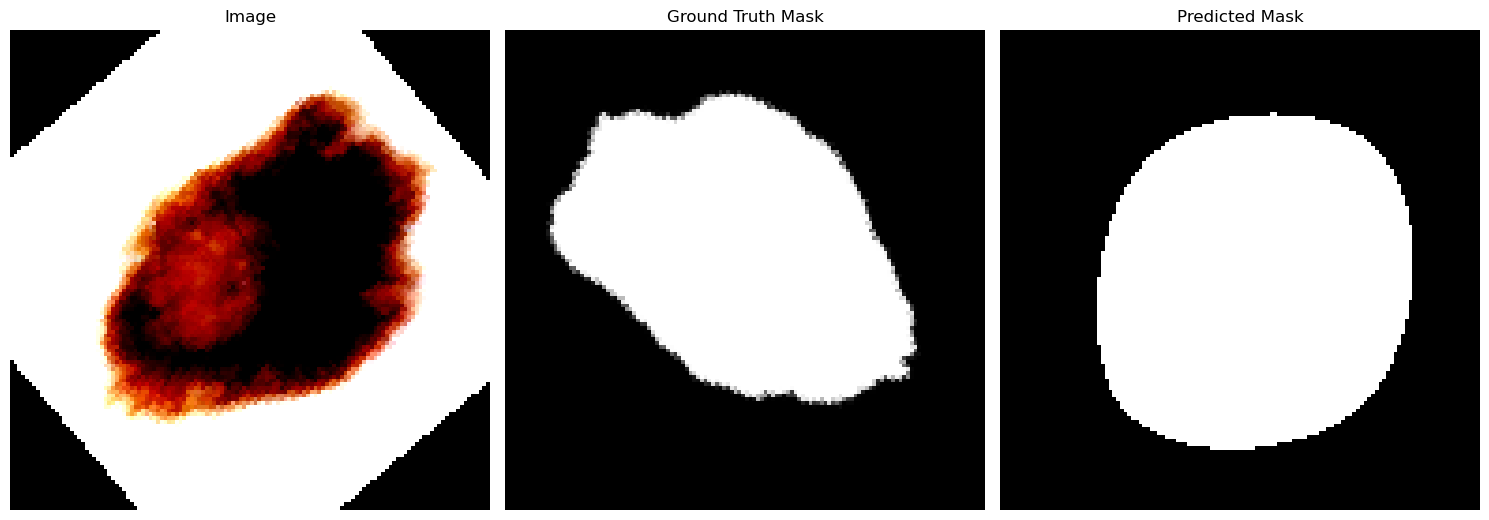

Epoch 15/45: Training Loss: 0.3076, Validation Loss: 0.2965, IoU: 0.6105, Dice Score: 0.7489


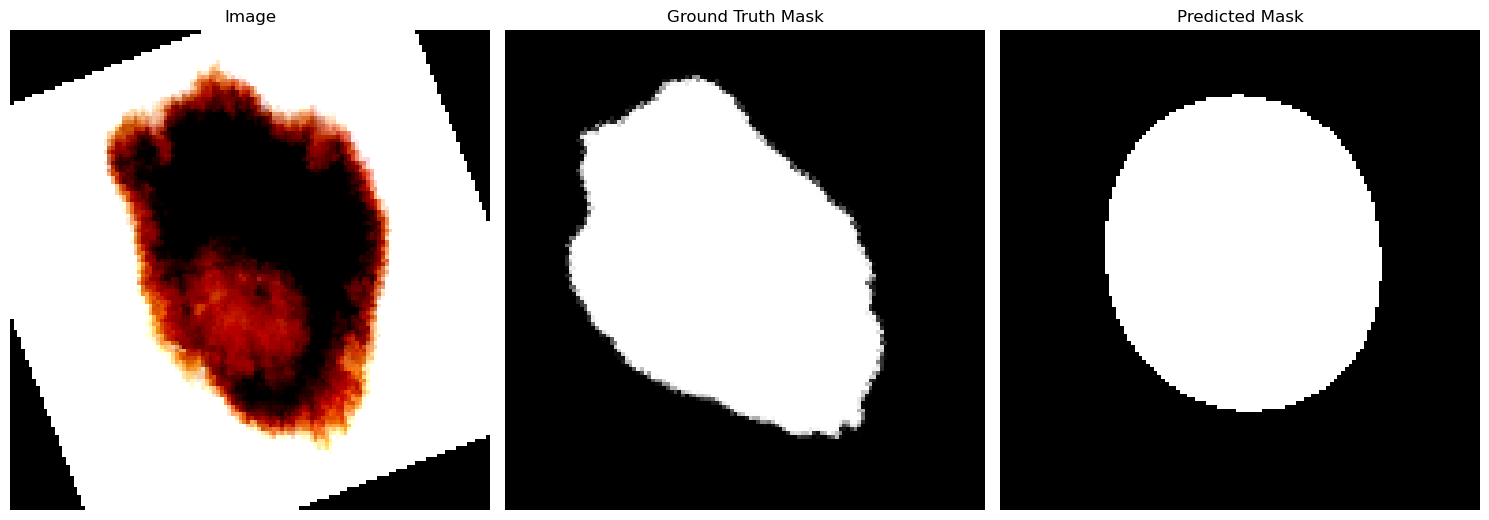

Epoch 16/45: Training Loss: 0.2968, Validation Loss: 0.2942, IoU: 0.6086, Dice Score: 0.7470


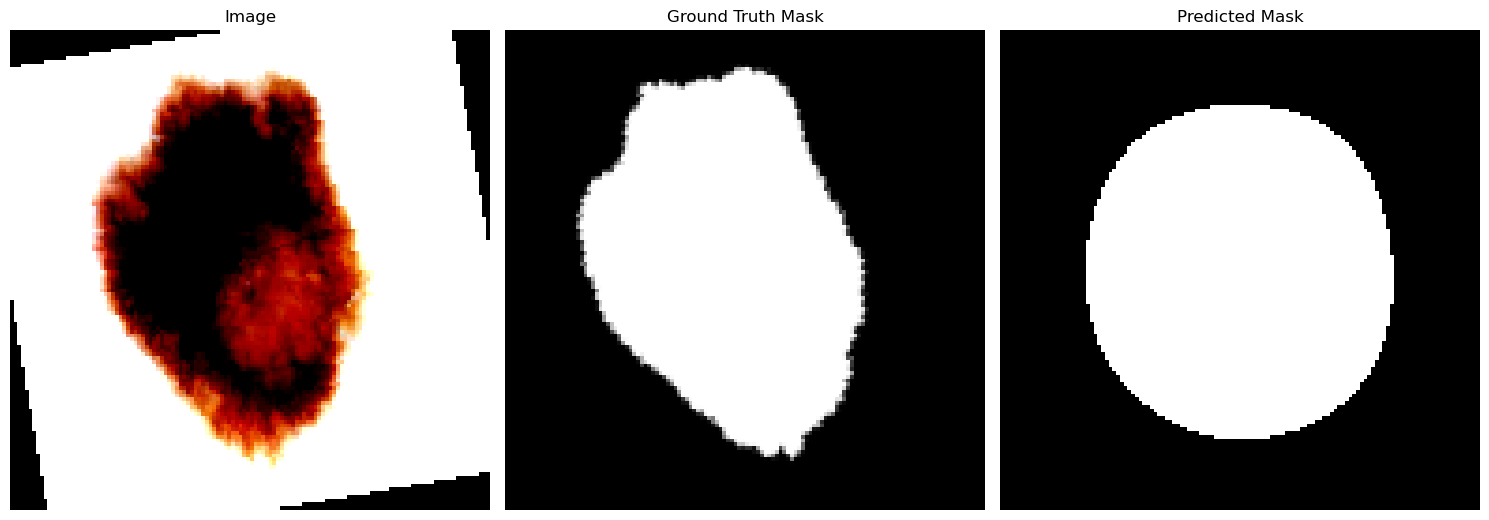

Epoch 17/45: Training Loss: 0.2941, Validation Loss: 0.2938, IoU: 0.6152, Dice Score: 0.7484


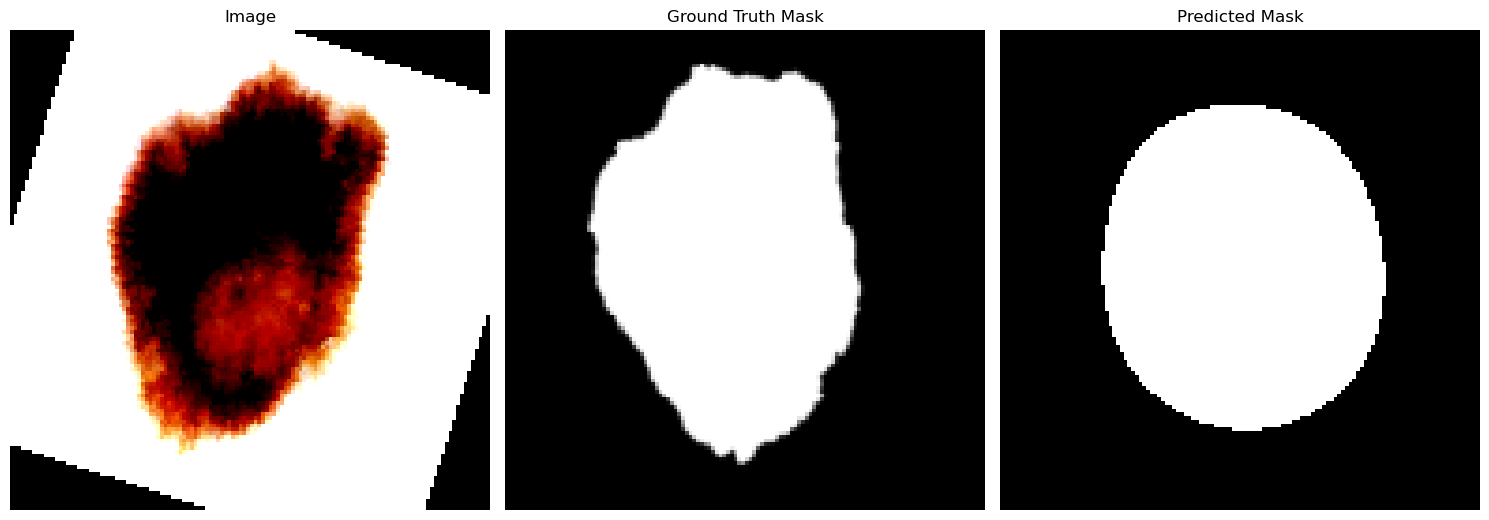

Epoch 18/45: Training Loss: 0.2993, Validation Loss: 0.2989, IoU: 0.6197, Dice Score: 0.7506


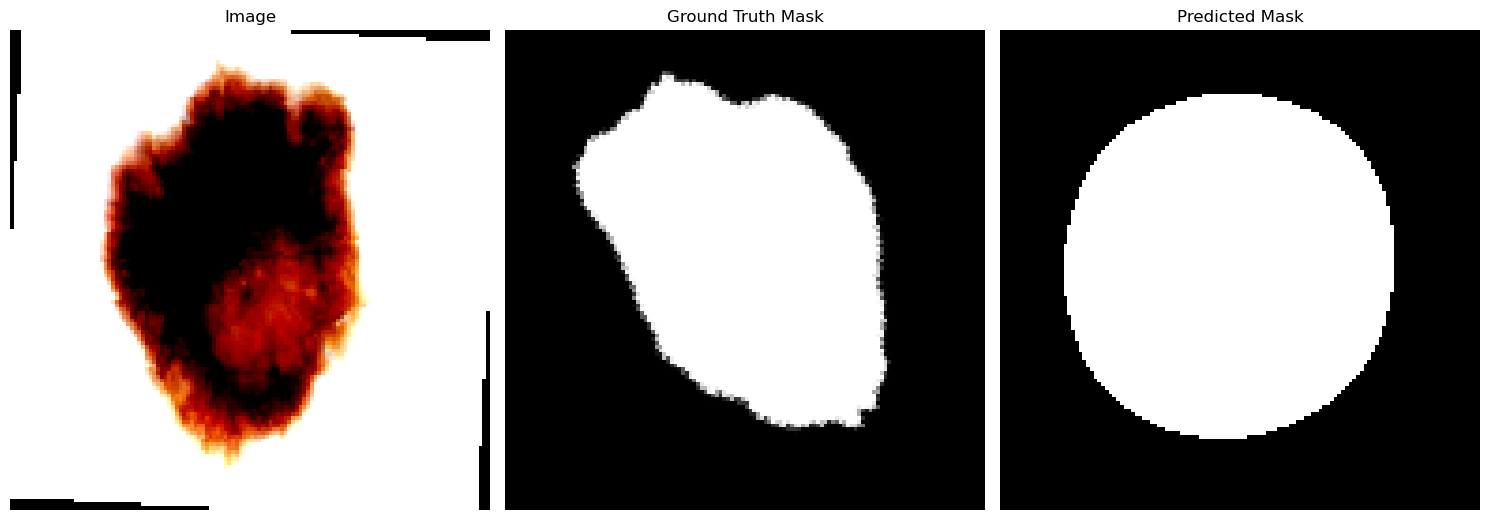

Epoch 19/45: Training Loss: 0.2941, Validation Loss: 0.3137, IoU: 0.5757, Dice Score: 0.7163


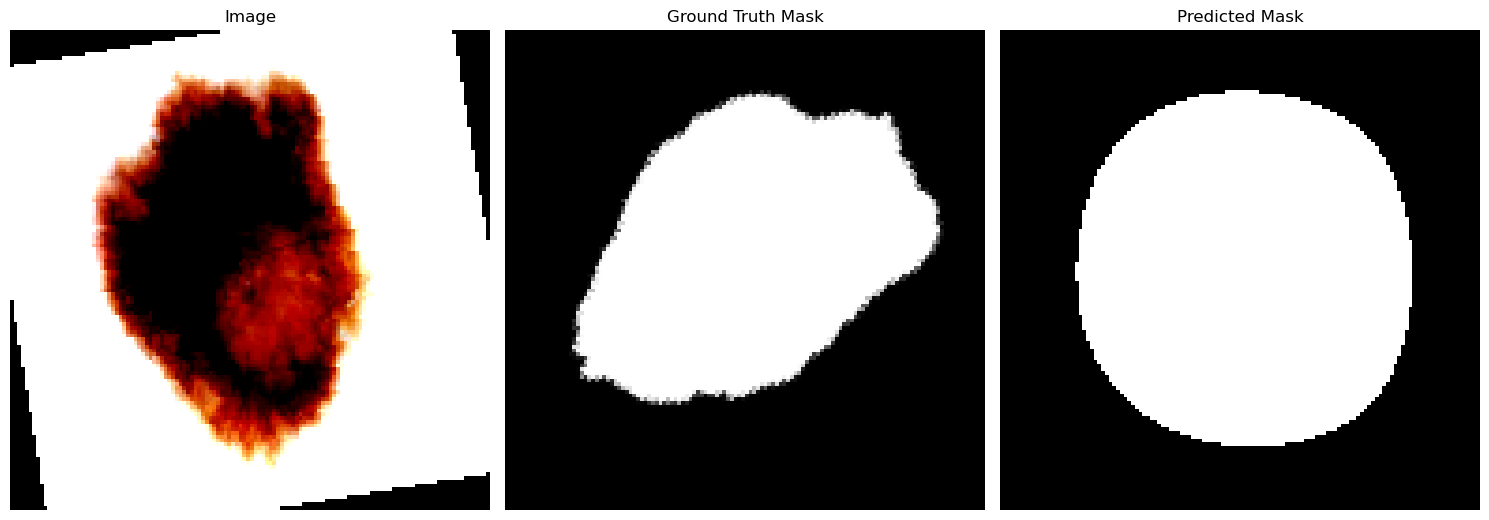

Epoch 20/45: Training Loss: 0.2982, Validation Loss: 0.2896, IoU: 0.6258, Dice Score: 0.7562


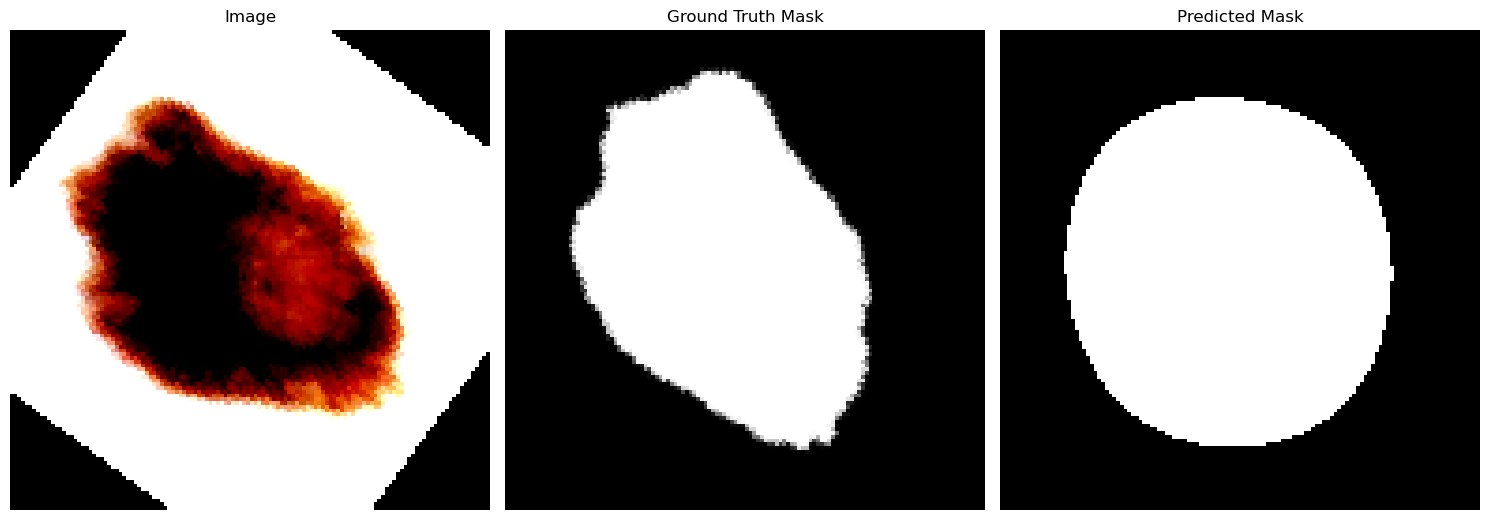

Epoch 21/45: Training Loss: 0.2945, Validation Loss: 0.2947, IoU: 0.6295, Dice Score: 0.7619


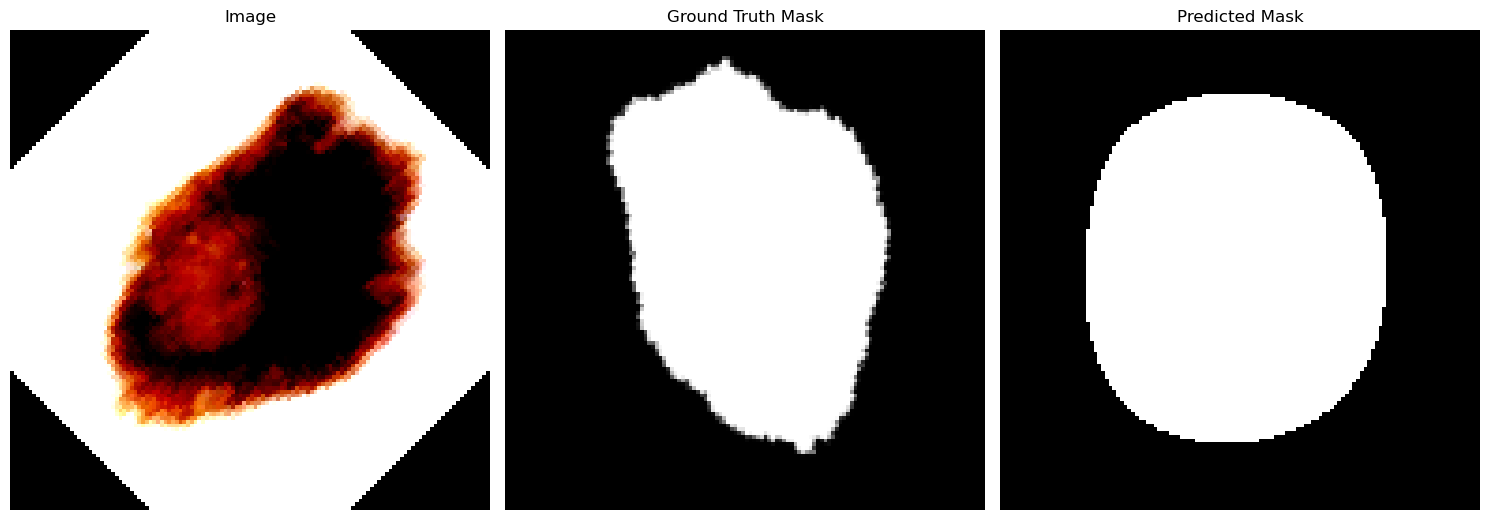

Epoch 22/45: Training Loss: 0.2914, Validation Loss: 0.3073, IoU: 0.6159, Dice Score: 0.7503


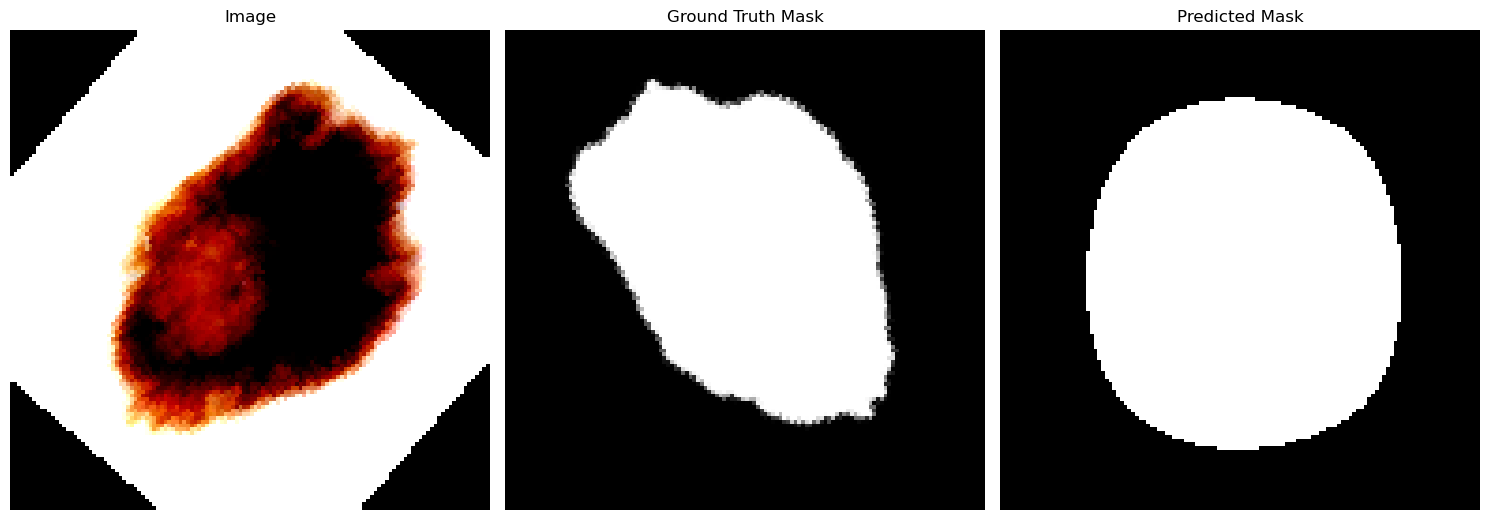

Epoch 23/45: Training Loss: 0.3068, Validation Loss: 0.3036, IoU: 0.6132, Dice Score: 0.7482


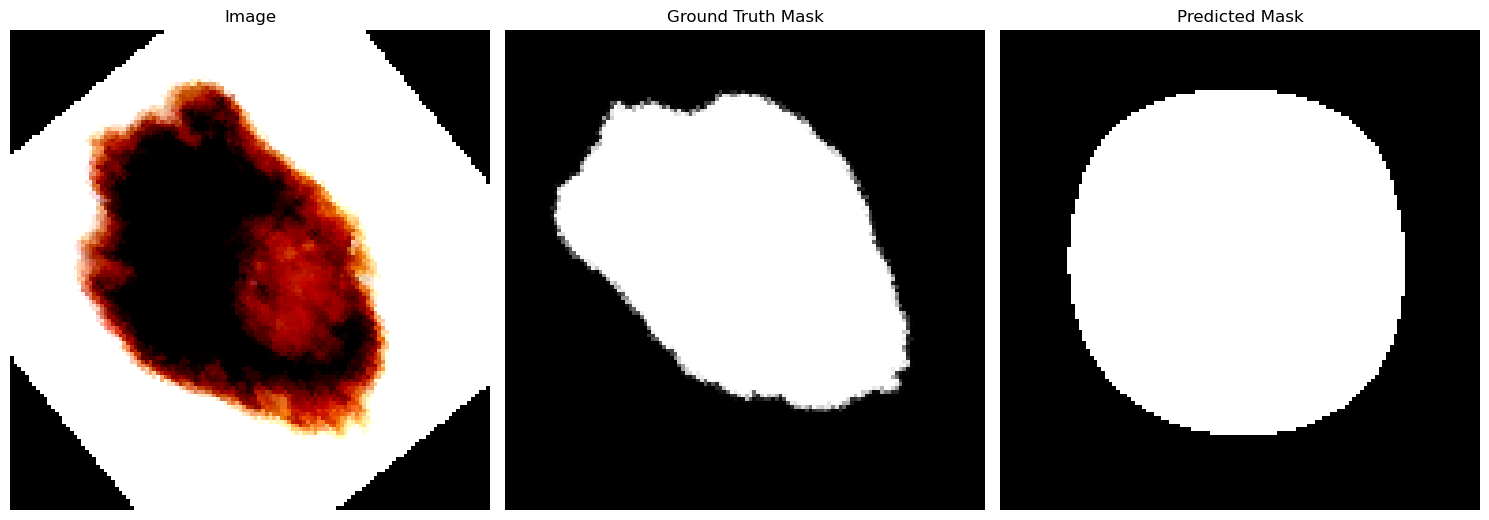

Epoch 24/45: Training Loss: 0.2948, Validation Loss: 0.2966, IoU: 0.6387, Dice Score: 0.7669


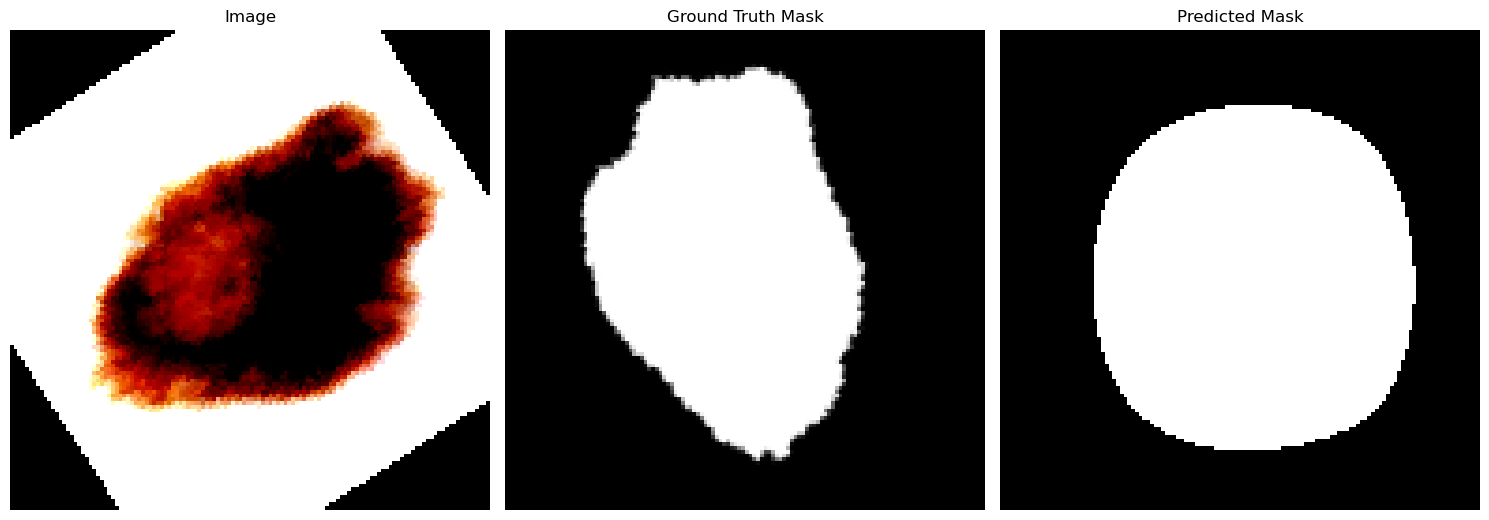

Epoch 25/45: Training Loss: 0.2982, Validation Loss: 0.3005, IoU: 0.6192, Dice Score: 0.7530


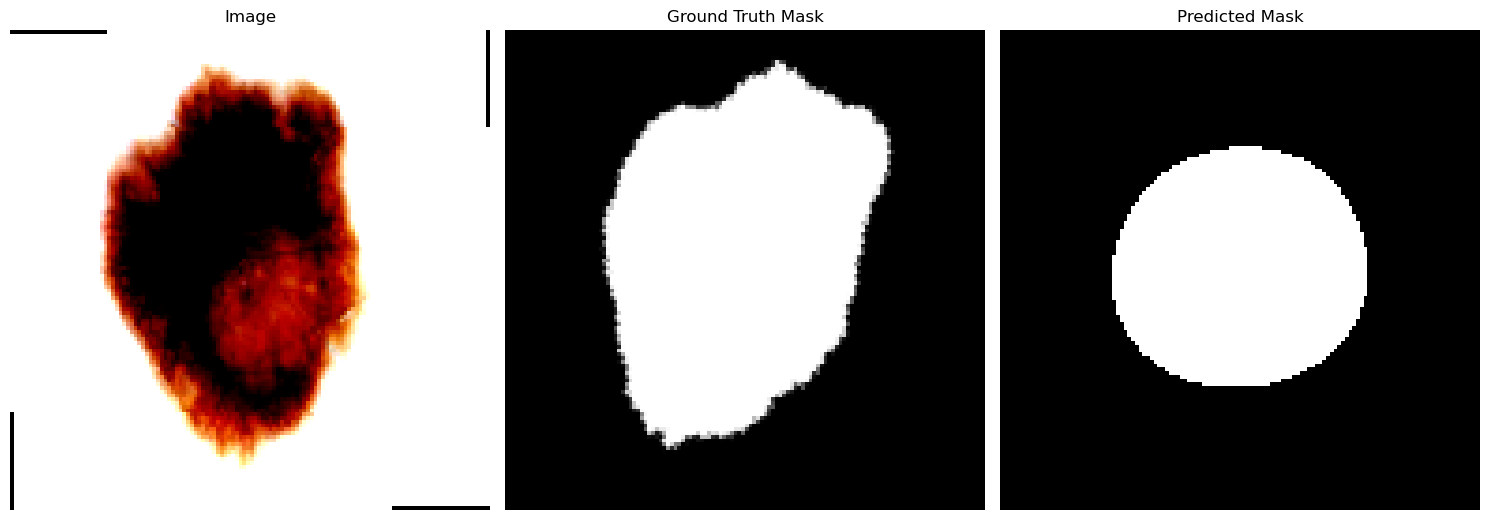

Epoch 26/45: Training Loss: 0.2984, Validation Loss: 0.3283, IoU: 0.5676, Dice Score: 0.7117


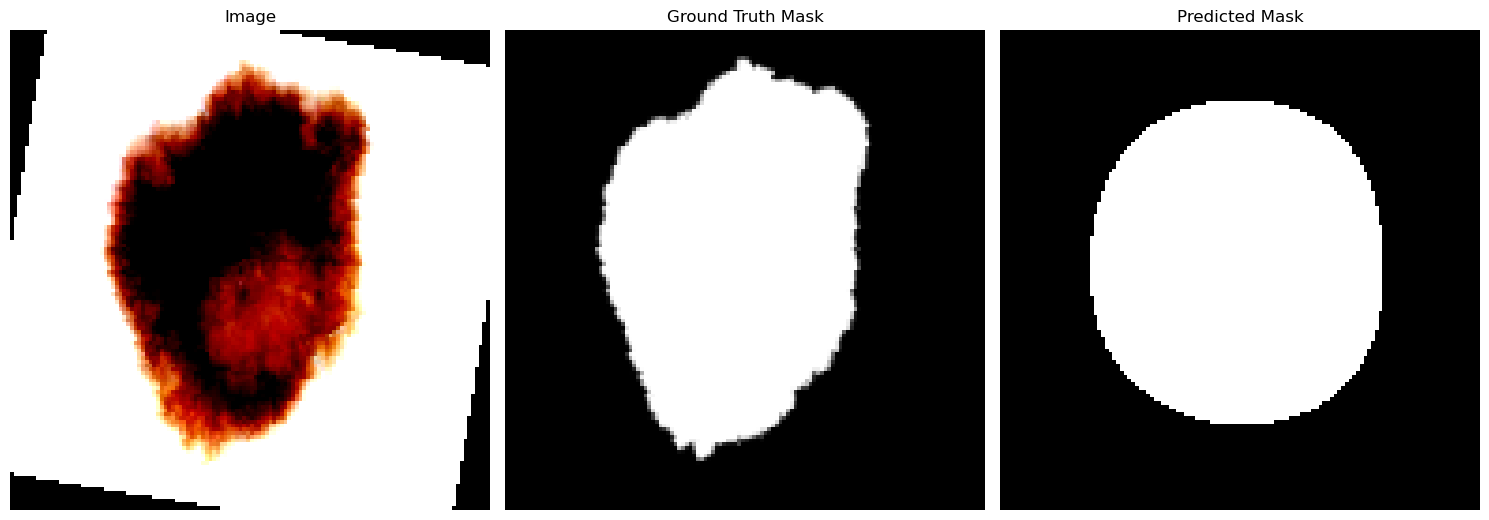

Epoch 27/45: Training Loss: 0.2960, Validation Loss: 0.2869, IoU: 0.6142, Dice Score: 0.7518


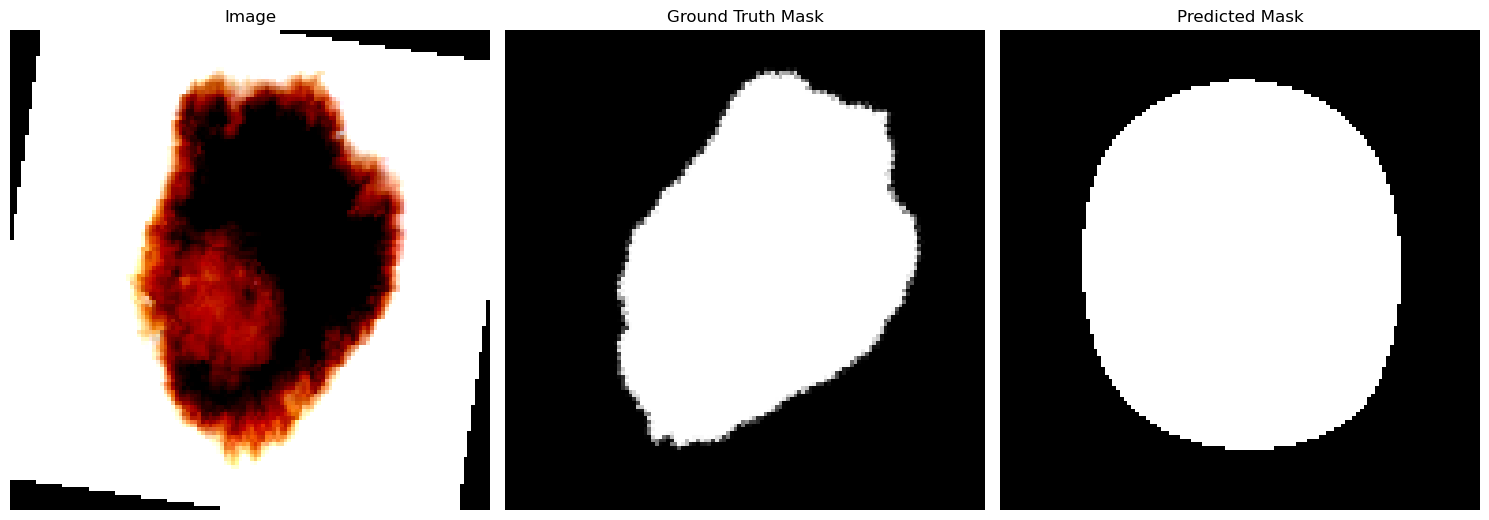

Epoch 28/45: Training Loss: 0.2942, Validation Loss: 0.2923, IoU: 0.6304, Dice Score: 0.7628


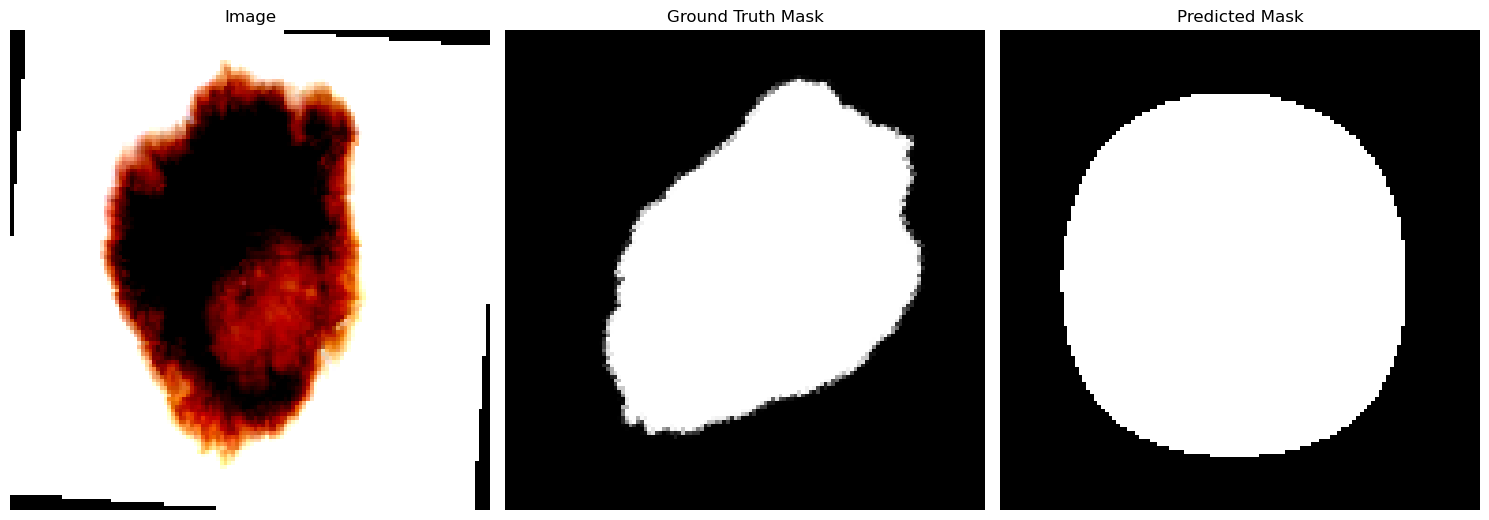

Epoch 29/45: Training Loss: 0.2969, Validation Loss: 0.2895, IoU: 0.6291, Dice Score: 0.7620


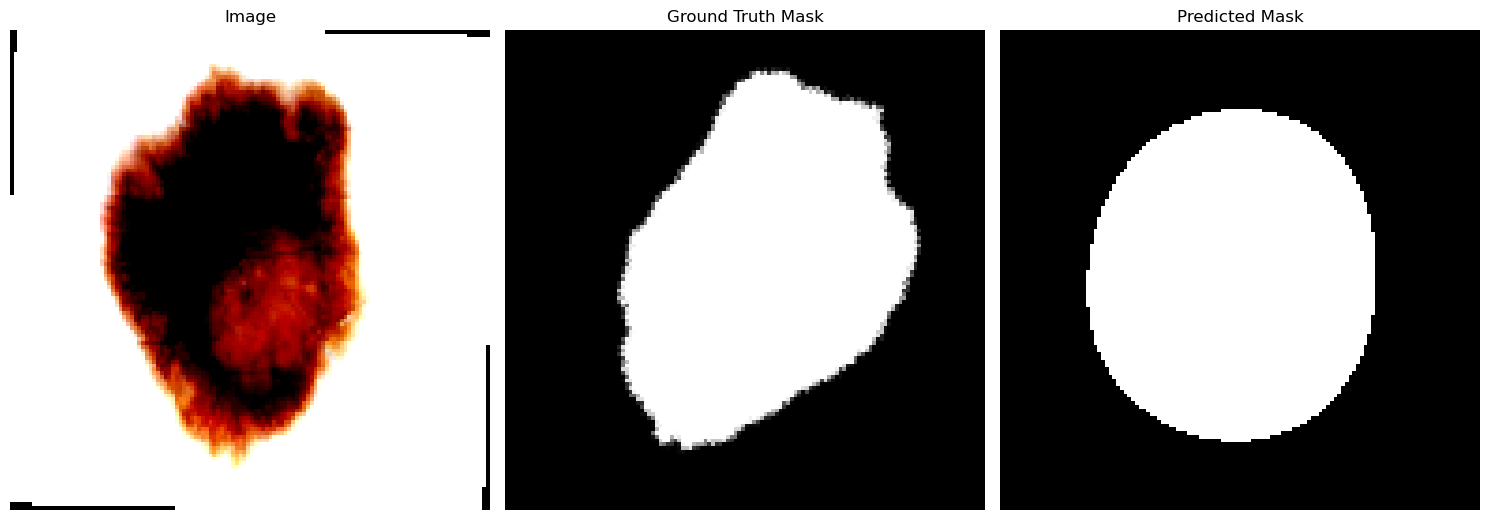

Epoch 30/45: Training Loss: 0.3088, Validation Loss: 0.2935, IoU: 0.6081, Dice Score: 0.7418


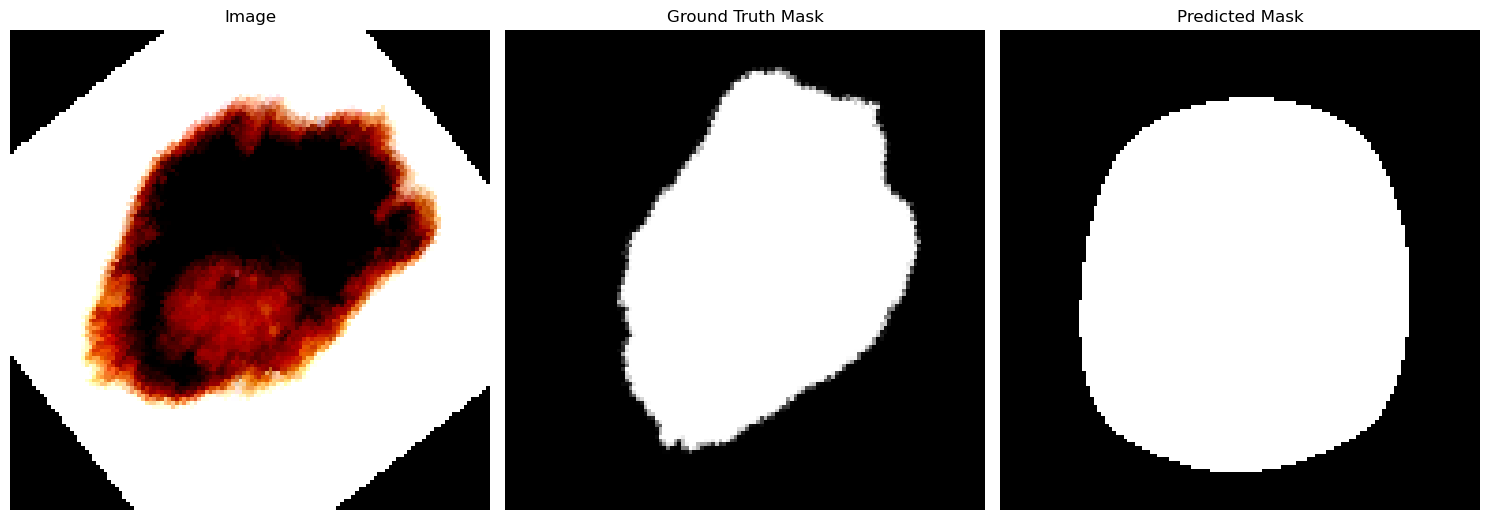

Epoch 31/45: Training Loss: 0.2983, Validation Loss: 0.2920, IoU: 0.6310, Dice Score: 0.7593


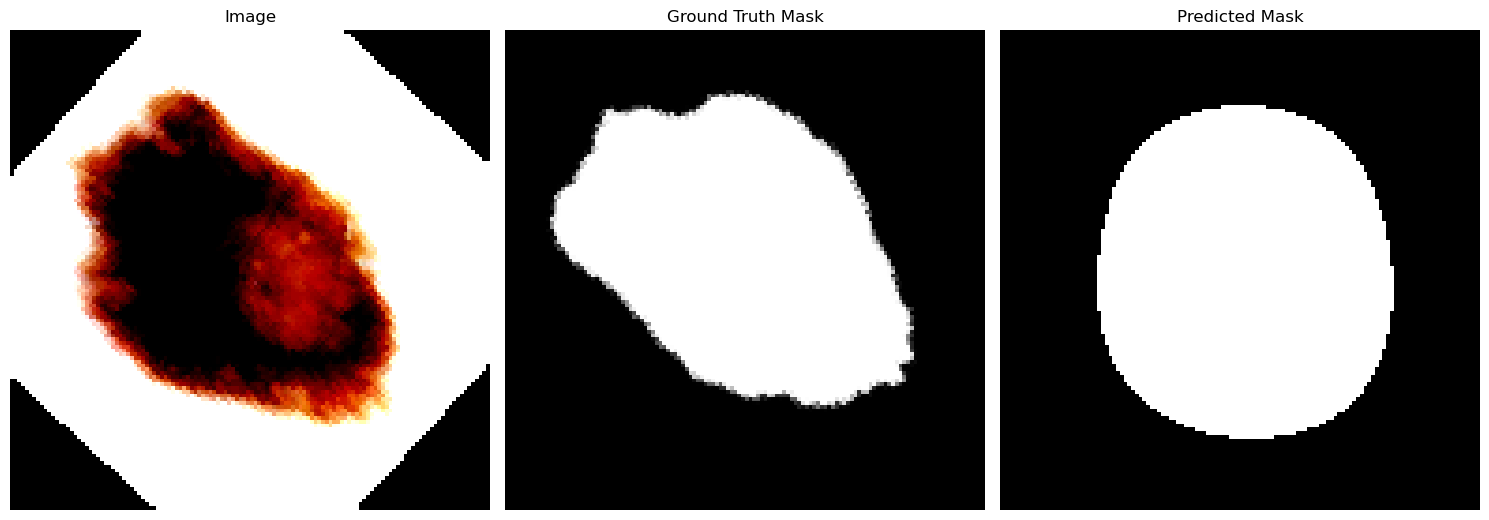

Epoch 32/45: Training Loss: 0.2951, Validation Loss: 0.2955, IoU: 0.6340, Dice Score: 0.7669


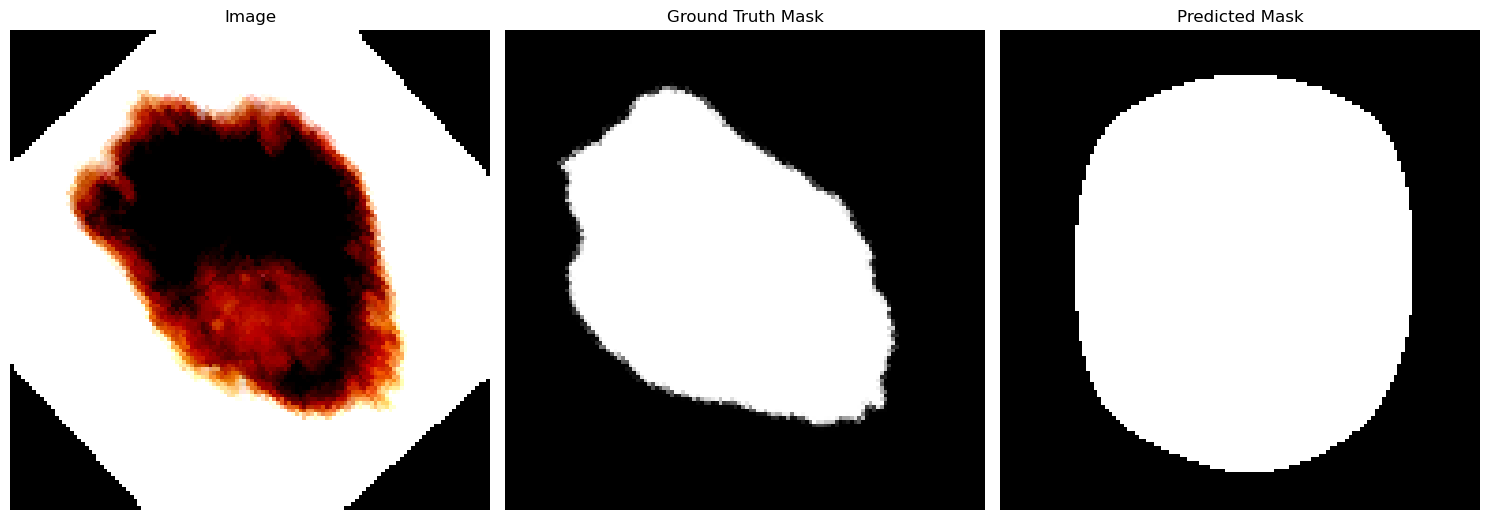

Epoch 33/45: Training Loss: 0.3009, Validation Loss: 0.2965, IoU: 0.6009, Dice Score: 0.7372


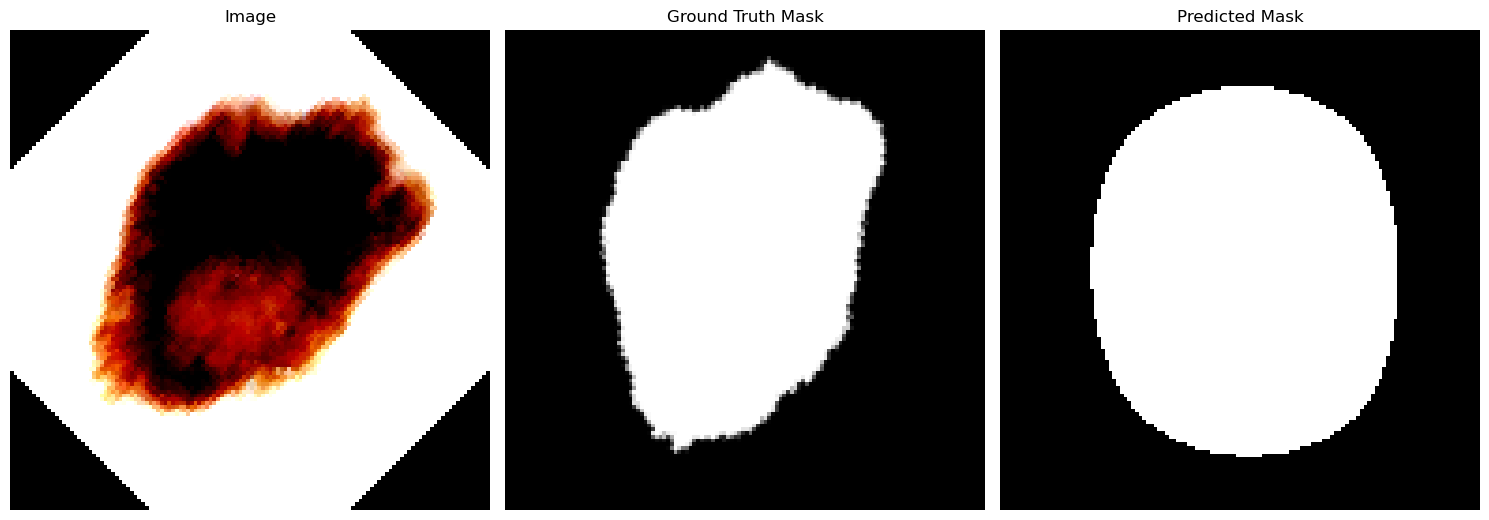

Epoch 34/45: Training Loss: 0.3023, Validation Loss: 0.2963, IoU: 0.6161, Dice Score: 0.7485


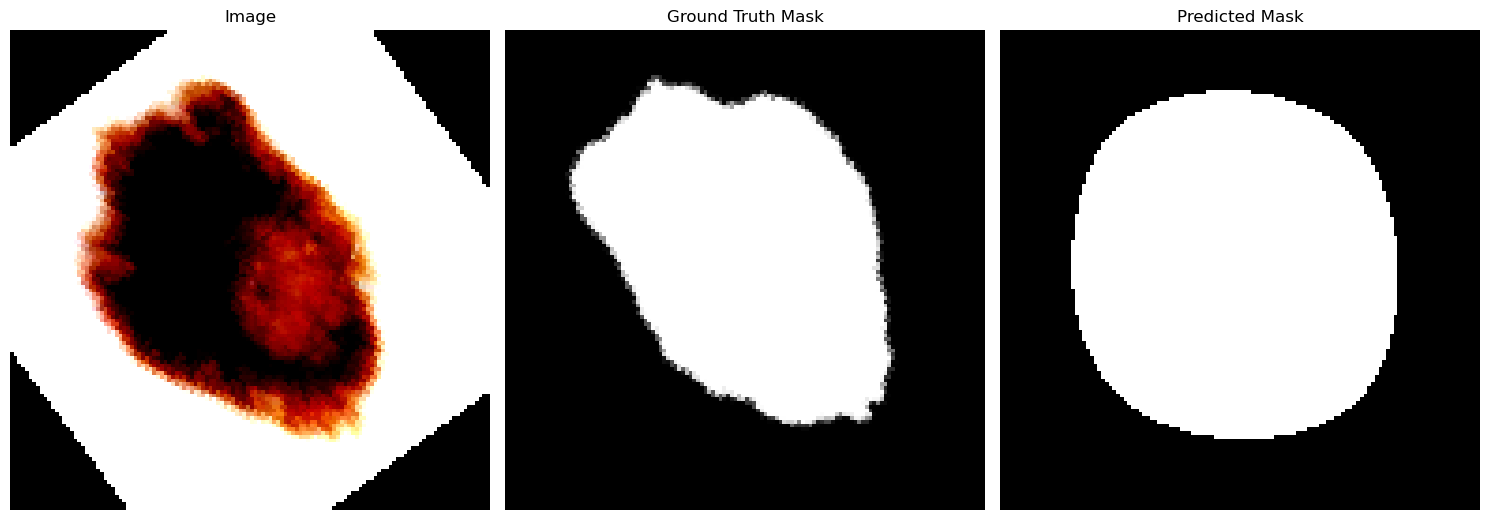

Epoch 35/45: Training Loss: 0.2974, Validation Loss: 0.2849, IoU: 0.6350, Dice Score: 0.7627


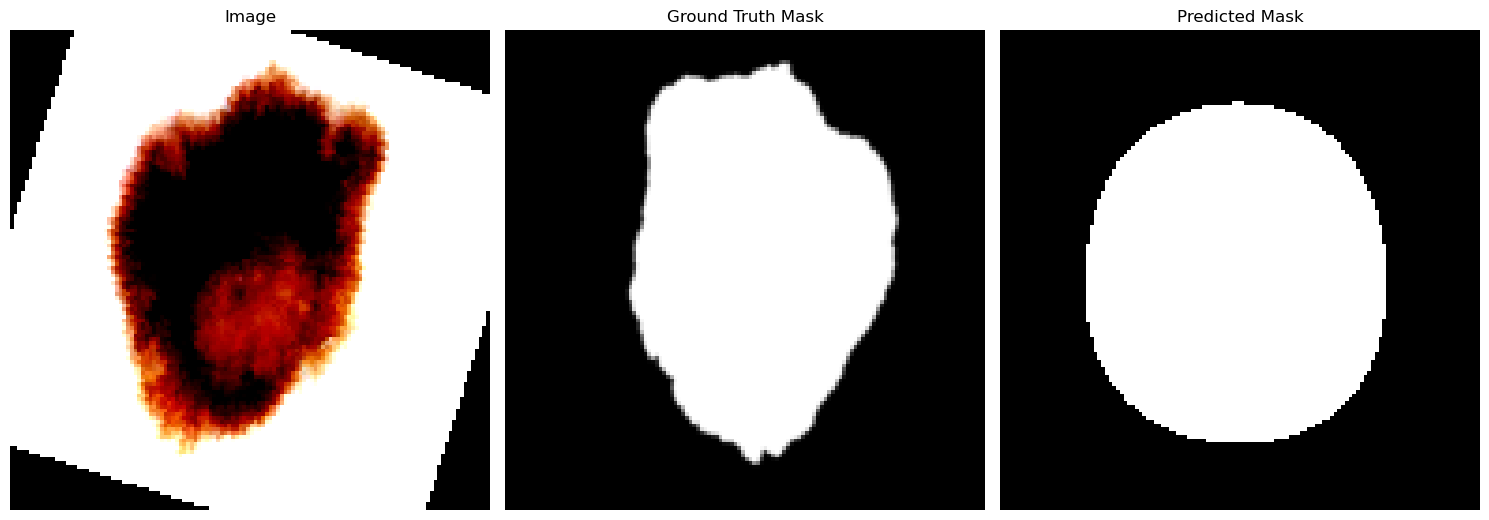

Epoch 36/45: Training Loss: 0.2953, Validation Loss: 0.2905, IoU: 0.6368, Dice Score: 0.7691


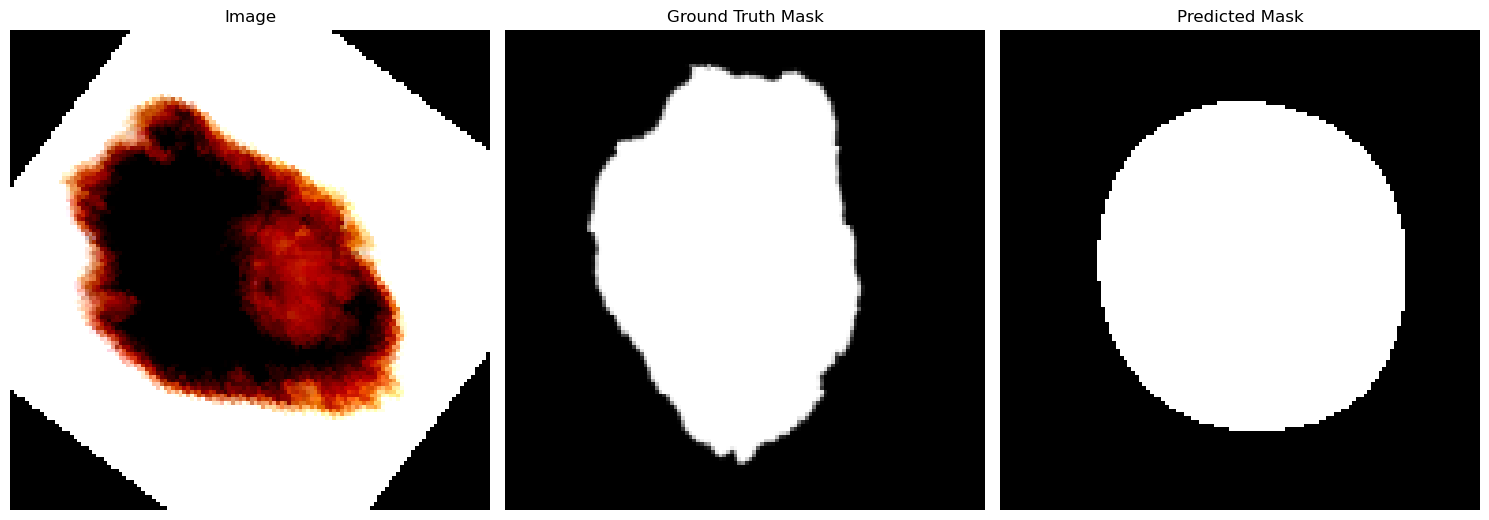

Epoch 37/45: Training Loss: 0.3003, Validation Loss: 0.2828, IoU: 0.6280, Dice Score: 0.7591


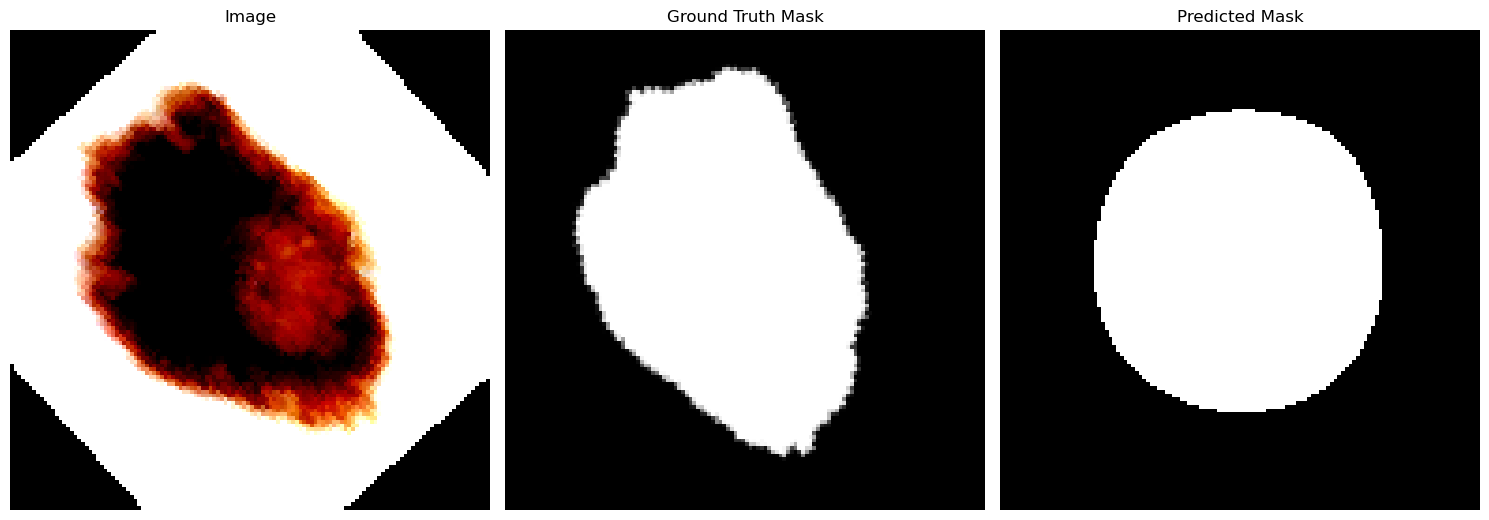

Epoch 38/45: Training Loss: 0.2914, Validation Loss: 0.2819, IoU: 0.6295, Dice Score: 0.7591


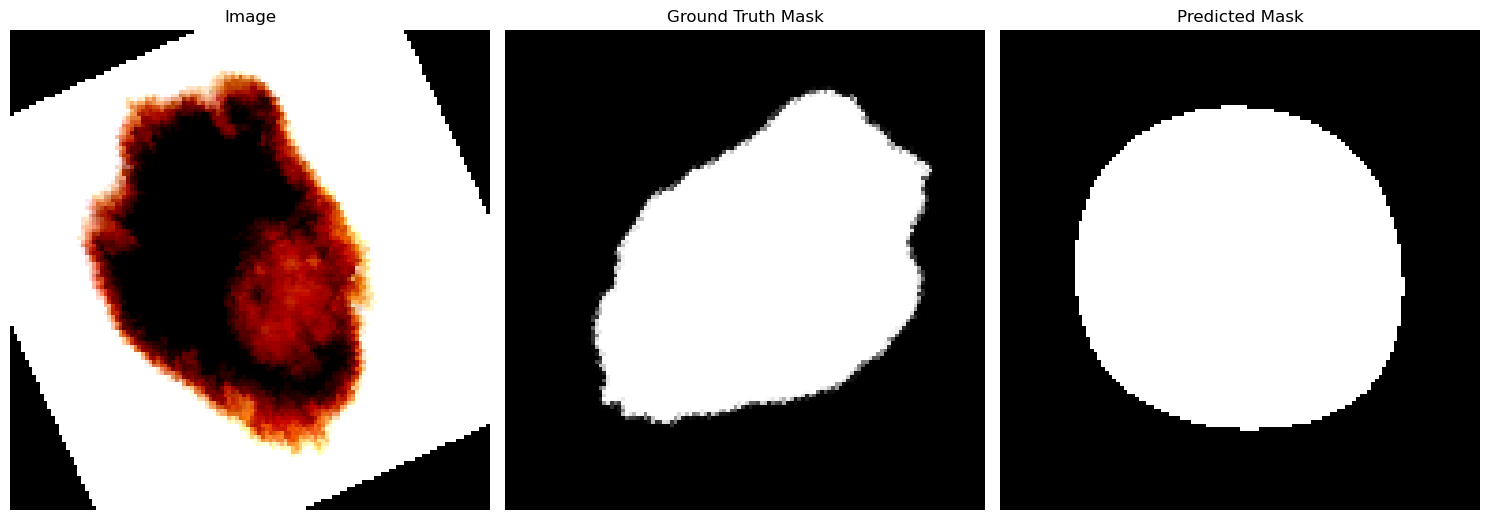

Epoch 39/45: Training Loss: 0.2918, Validation Loss: 0.2803, IoU: 0.6247, Dice Score: 0.7576


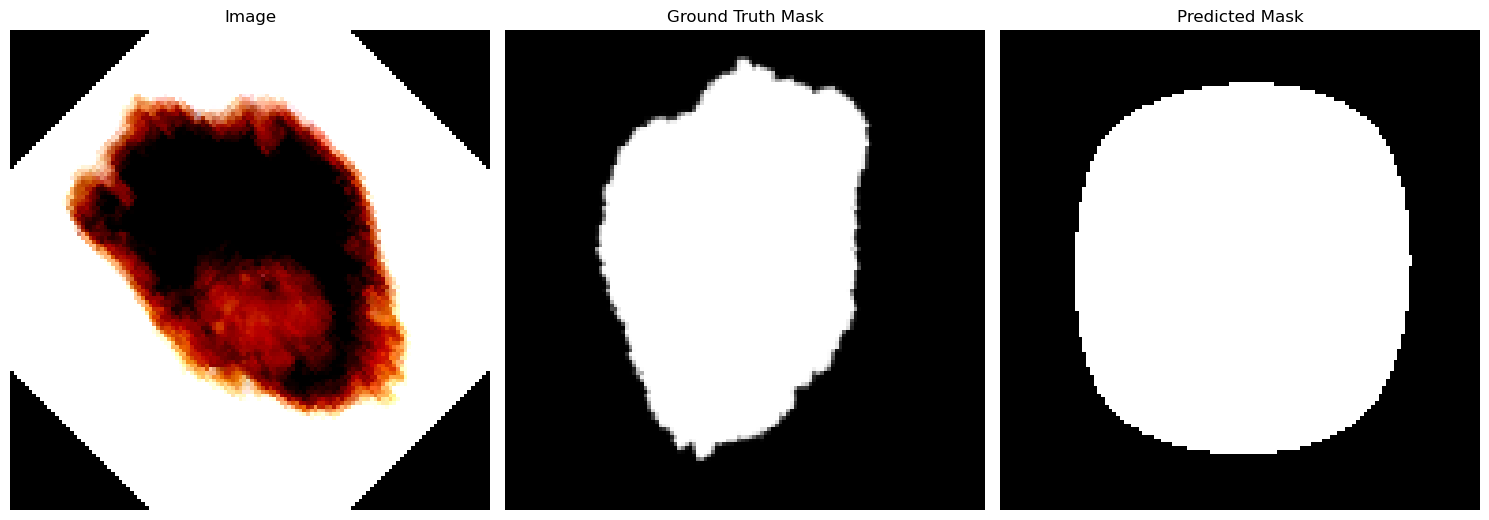

Epoch 40/45: Training Loss: 0.2935, Validation Loss: 0.2934, IoU: 0.6266, Dice Score: 0.7578


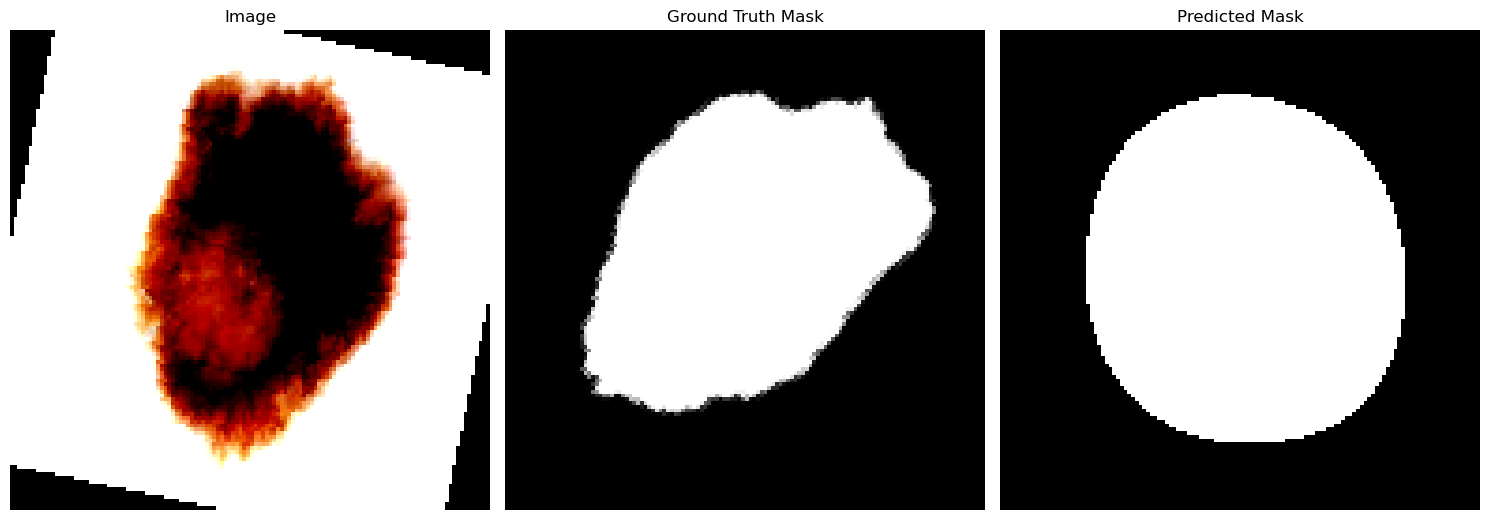

Epoch 41/45: Training Loss: 0.2896, Validation Loss: 0.3063, IoU: 0.6209, Dice Score: 0.7513


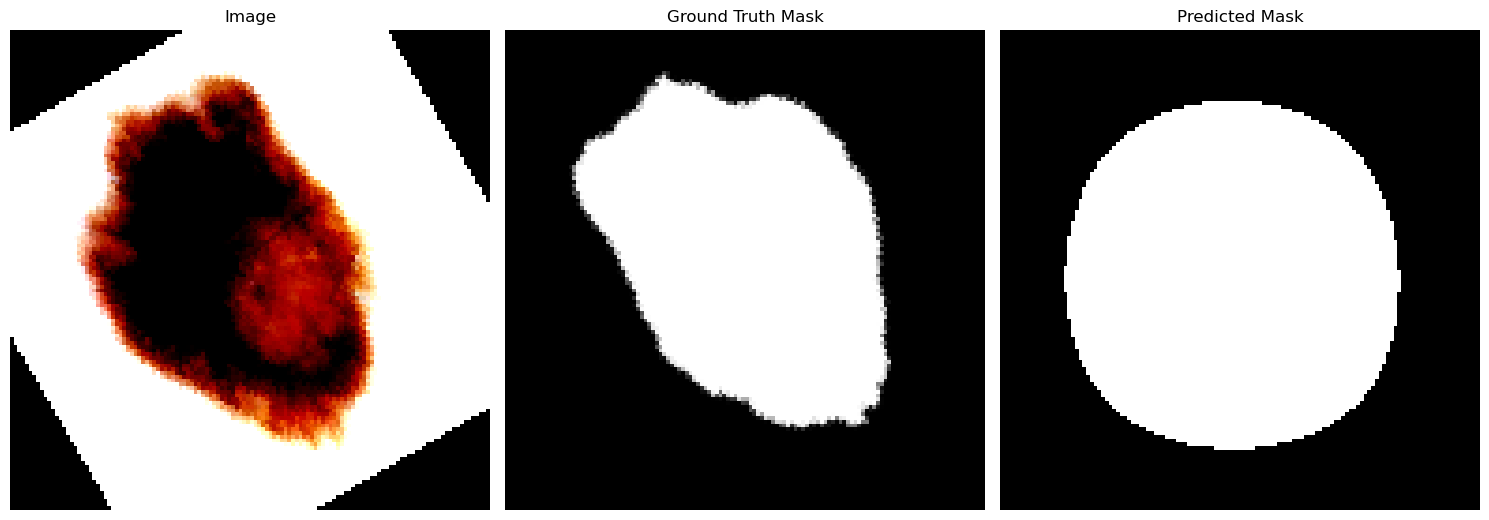

Epoch 42/45: Training Loss: 0.2919, Validation Loss: 0.2808, IoU: 0.6248, Dice Score: 0.7557


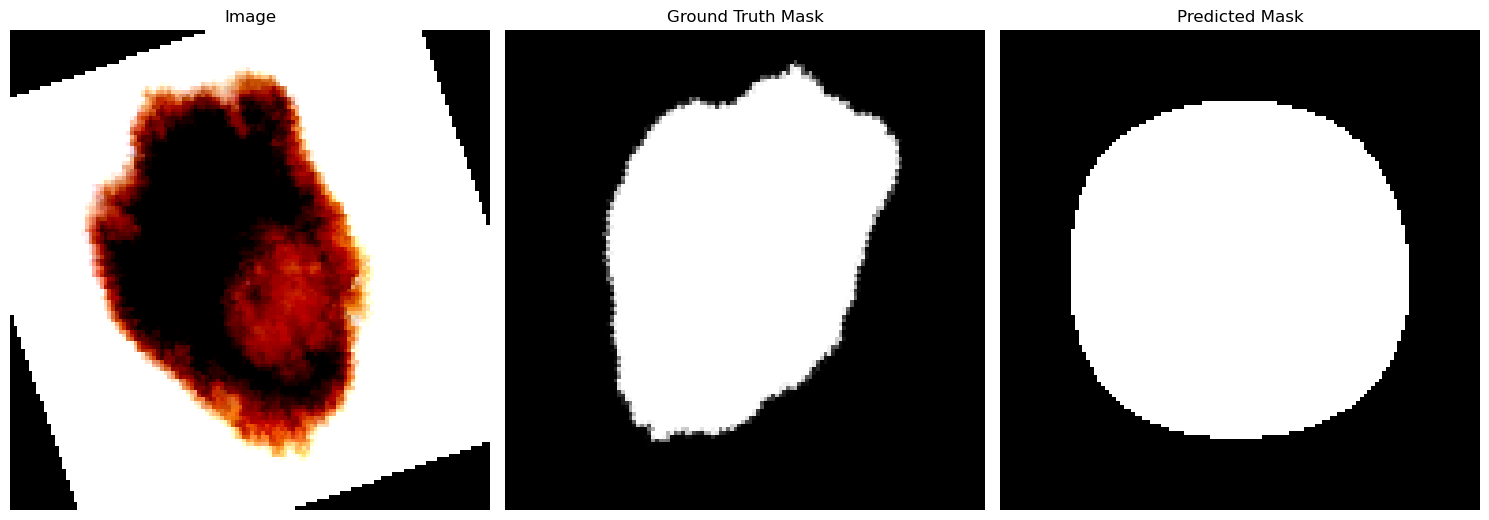

Epoch 43/45: Training Loss: 0.2857, Validation Loss: 0.3053, IoU: 0.6209, Dice Score: 0.7530


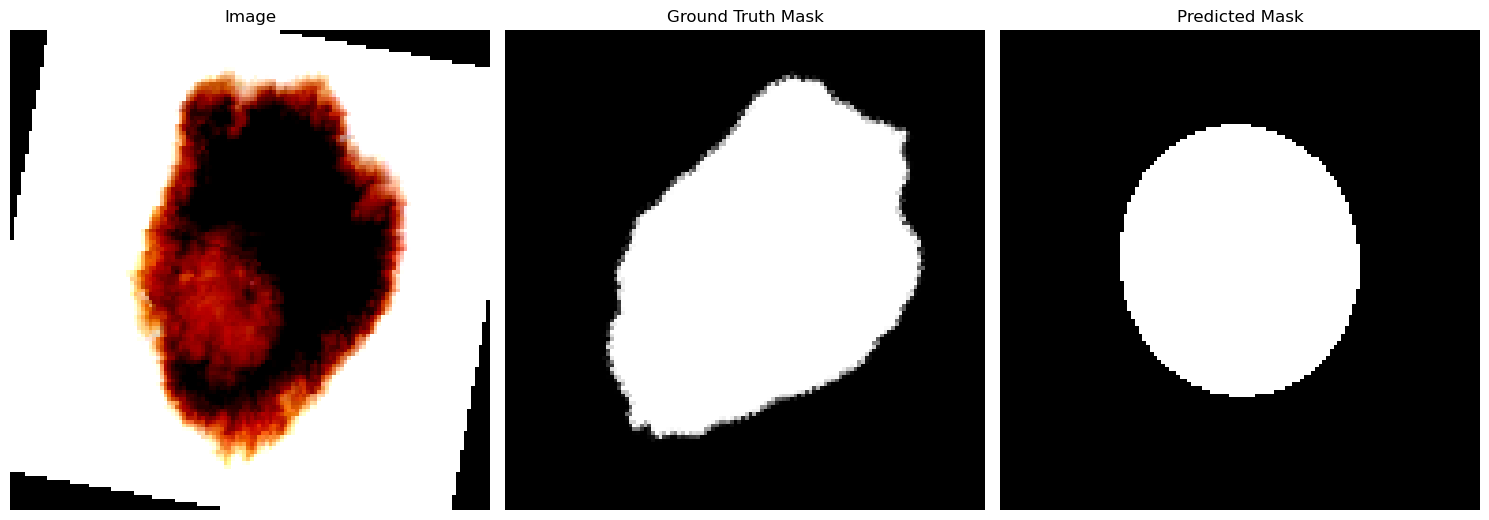

Epoch 44/45: Training Loss: 0.2928, Validation Loss: 0.2922, IoU: 0.6075, Dice Score: 0.7442


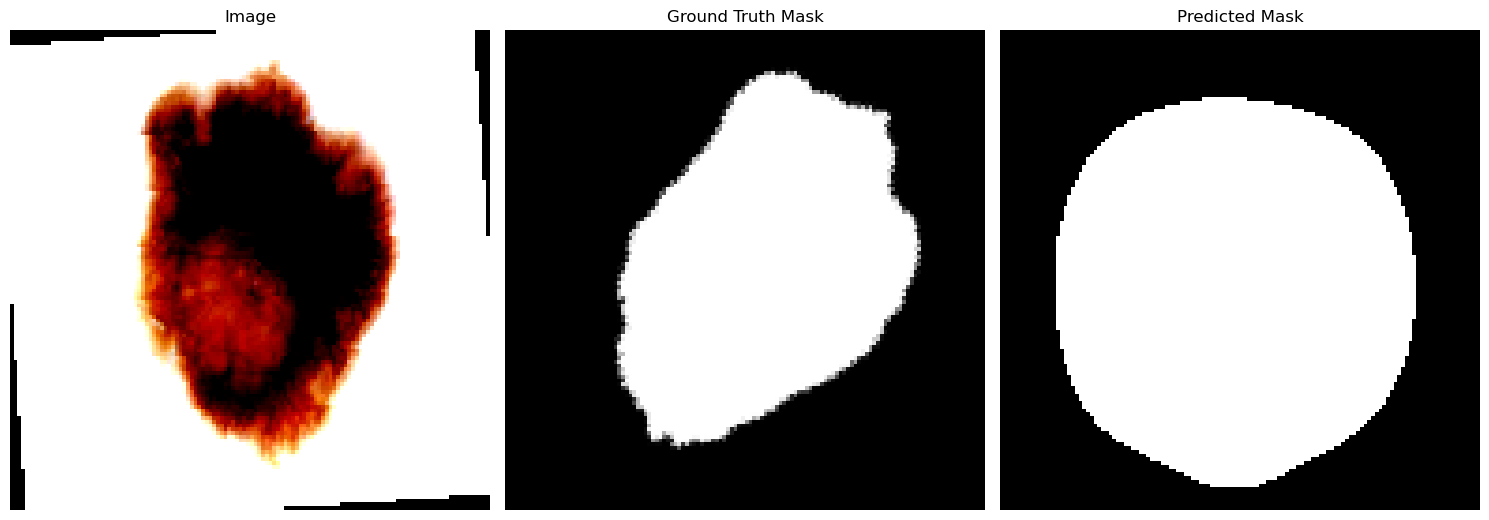

Epoch 45/45: Training Loss: 0.2911, Validation Loss: 0.2899, IoU: 0.6354, Dice Score: 0.7675

Dice Score : 0.7674971592457753

IOU Score : 0.6354048373202221



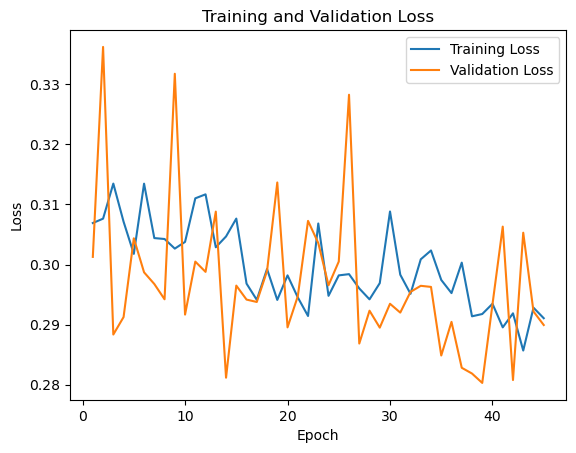

In [ ]:
task1_dice ,task1_iou , task1_train_loss , task1_val_loss = train_evaluate_model(model1, train_loader, test_loader, criterion, optimizer, device, num_epochs=num_epochs)

# Part 2

In [ ]:
encoder2 = models.mobilenet_v2(pretrained=True)

/home/user/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/user/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
for param in encoder2.parameters():
  param.requires_grad=True

In [ ]:
decoder = Decoder(num_classes=1)
model2 = SegmentationModel(encoder2, decoder)
torchinfo.summary(model2,input_size=[16,3,128,128])

Layer (type:depth-idx)                                  Output Shape              Param #
SegmentationModel                                       [16, 1, 128, 128]         --
├─MobileNetV2: 1-1                                      --                        1,281,000
│    └─Sequential: 2-1                                  [16, 1280, 4, 4]          --
│    │    └─Conv2dNormActivation: 3-1                   [16, 32, 64, 64]          928
│    │    └─InvertedResidual: 3-2                       [16, 16, 64, 64]          896
│    │    └─InvertedResidual: 3-3                       [16, 24, 32, 32]          5,136
│    │    └─InvertedResidual: 3-4                       [16, 24, 32, 32]          8,832
│    │    └─InvertedResidual: 3-5                       [16, 32, 16, 16]          10,000
│    │    └─InvertedResidual: 3-6                       [16, 32, 16, 16]          14,848
│    │    └─InvertedResidual: 3-7                       [16, 32, 16, 16]          14,848
│    │    └─InvertedResidual: 3-8

In [ ]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model2.parameters(),lr = 0.001)
num_epochs = 45
model2 = model2.to(device)

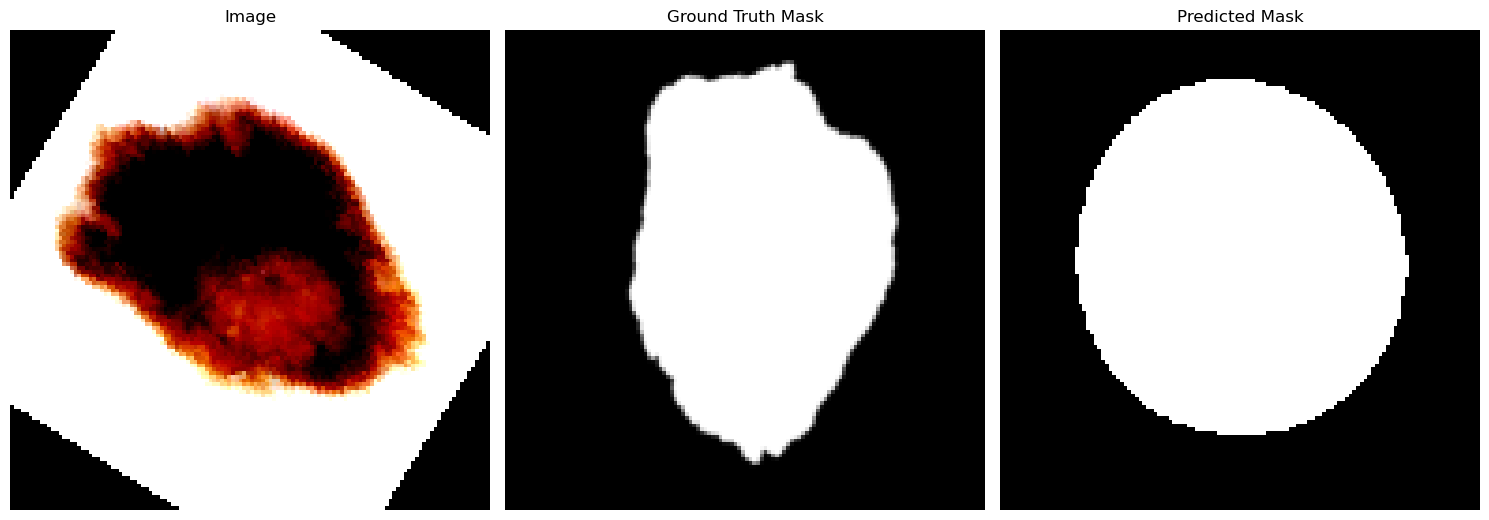

Epoch 1/45: Training Loss: 0.4732, Validation Loss: 0.3386, IoU: 0.6581, Dice Score: 0.7823


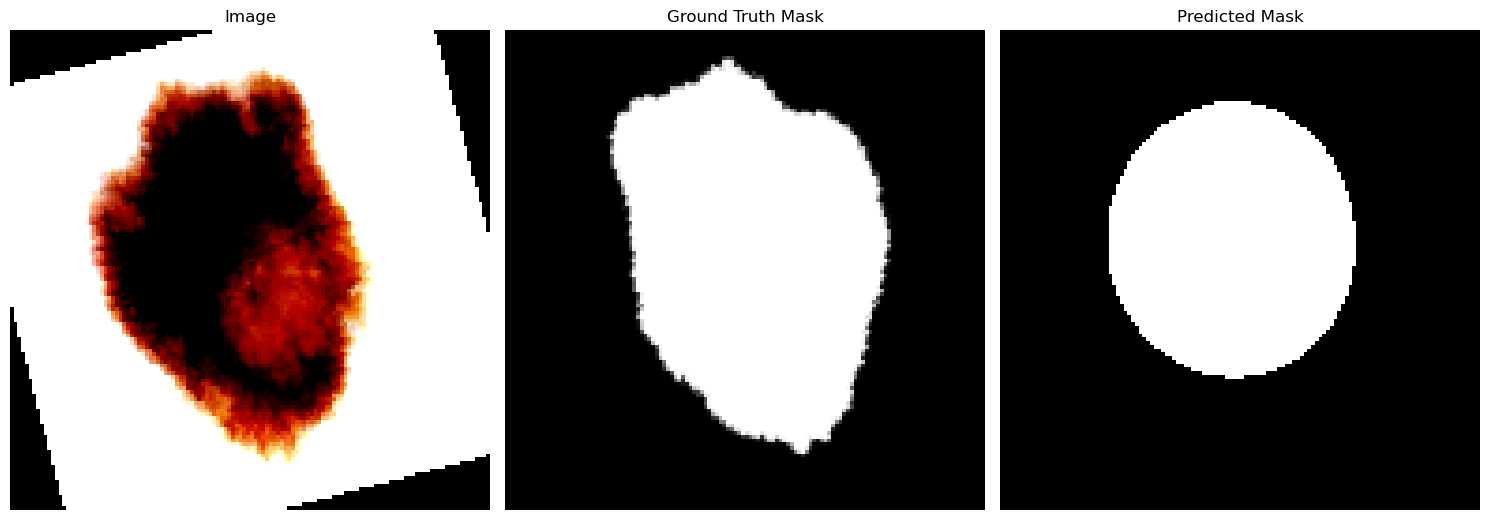

Epoch 2/45: Training Loss: 0.3659, Validation Loss: 0.3224, IoU: 0.5562, Dice Score: 0.7047


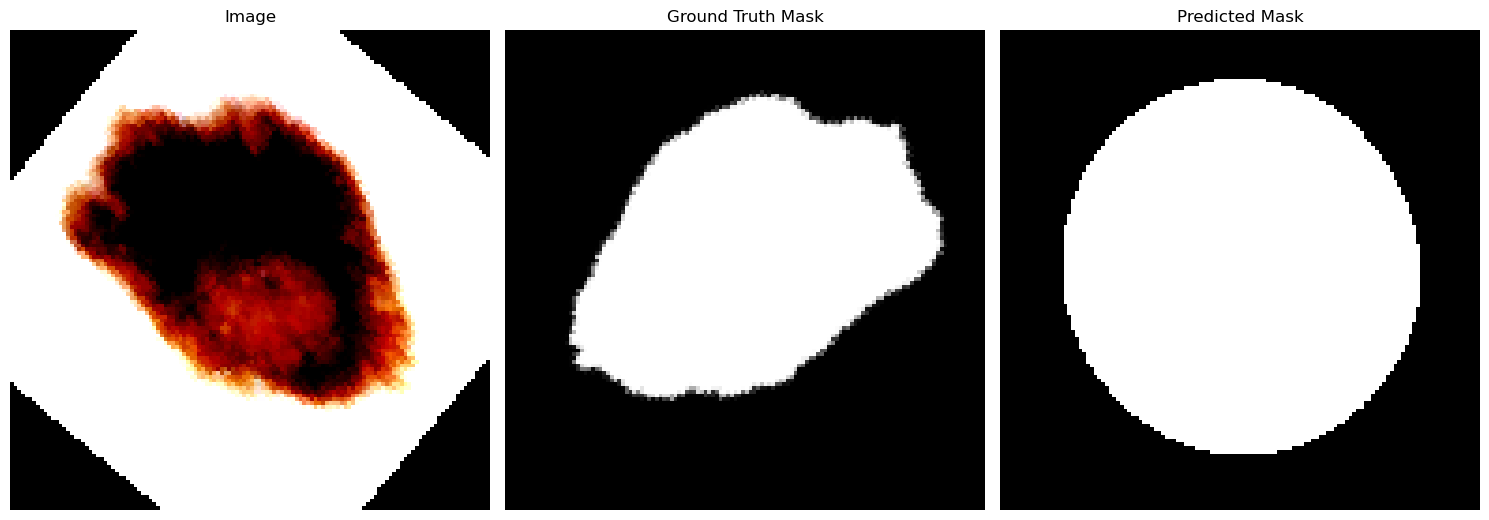

Epoch 3/45: Training Loss: 0.3220, Validation Loss: 0.3455, IoU: 0.6414, Dice Score: 0.7709


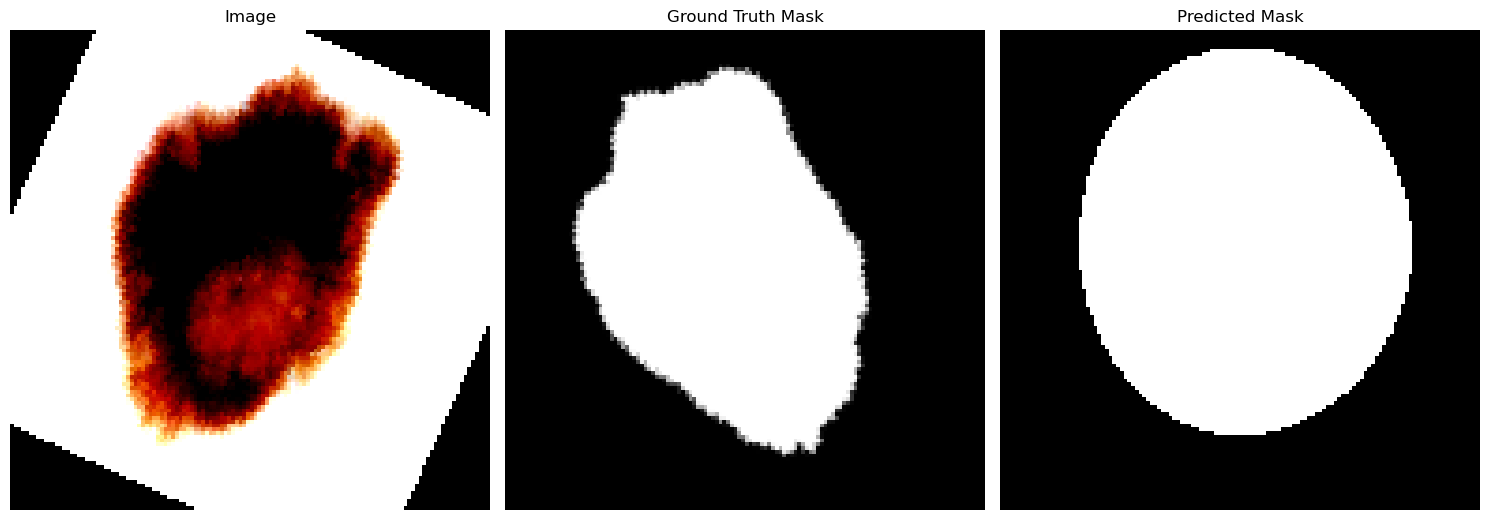

Epoch 4/45: Training Loss: 0.2907, Validation Loss: 0.3138, IoU: 0.6482, Dice Score: 0.7783


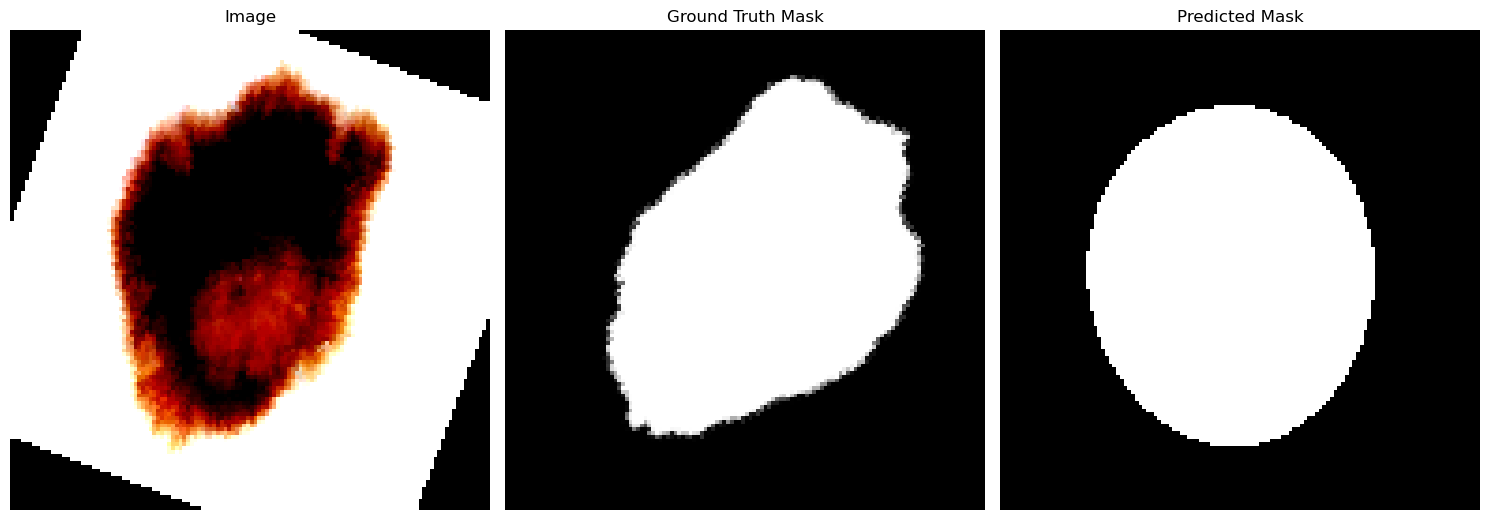

Epoch 5/45: Training Loss: 0.2785, Validation Loss: 0.2448, IoU: 0.6590, Dice Score: 0.7826


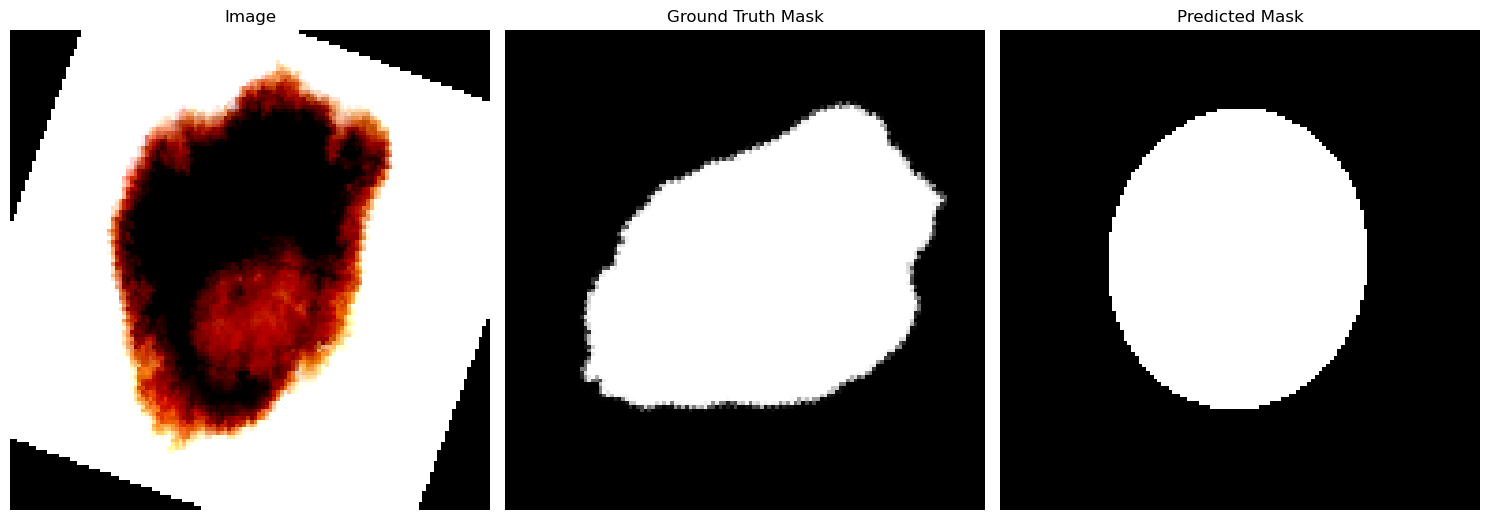

Epoch 6/45: Training Loss: 0.2647, Validation Loss: 0.2418, IoU: 0.6315, Dice Score: 0.7579


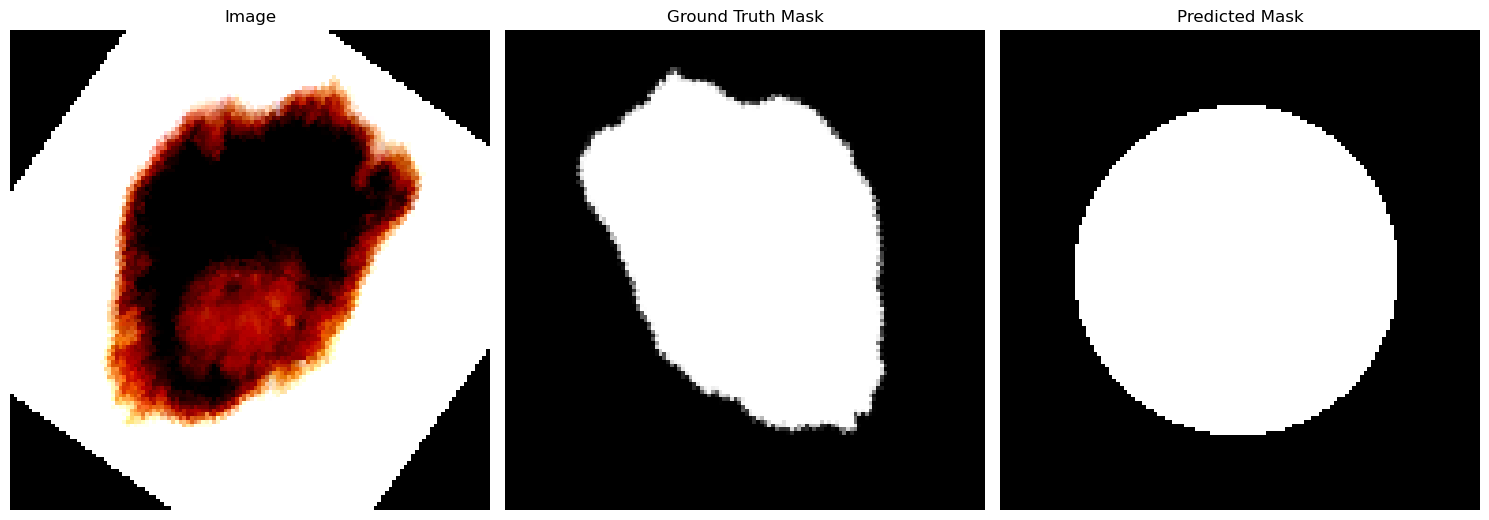

Epoch 7/45: Training Loss: 0.2687, Validation Loss: 0.2376, IoU: 0.6726, Dice Score: 0.7906


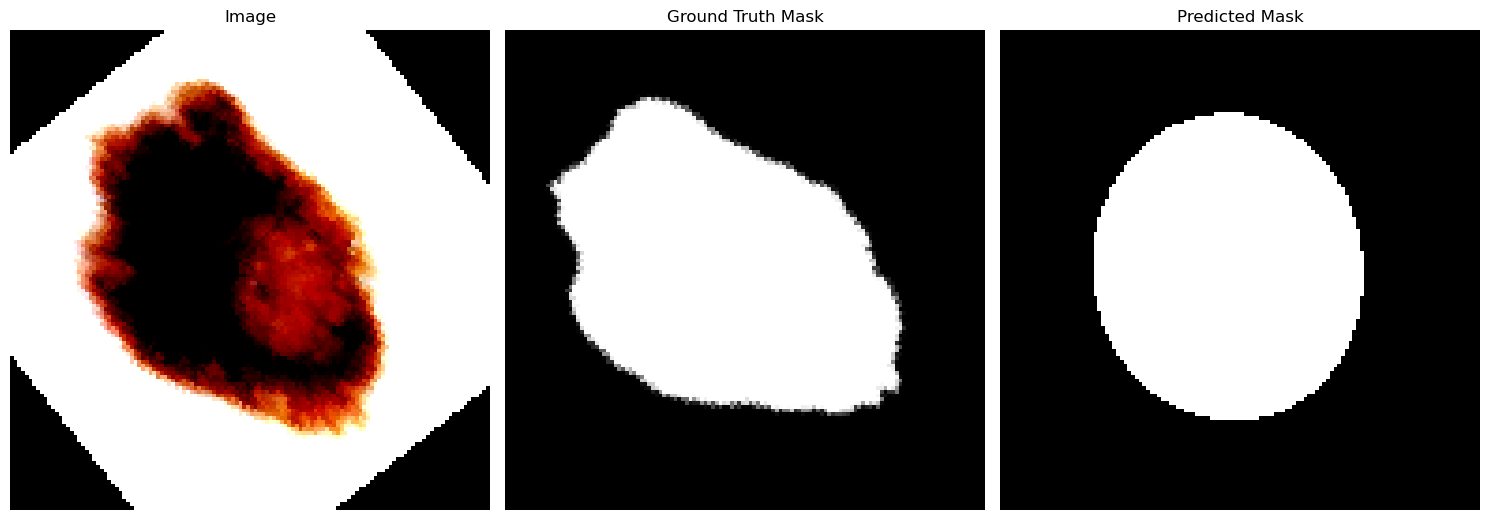

Epoch 8/45: Training Loss: 0.2600, Validation Loss: 0.2630, IoU: 0.6293, Dice Score: 0.7545


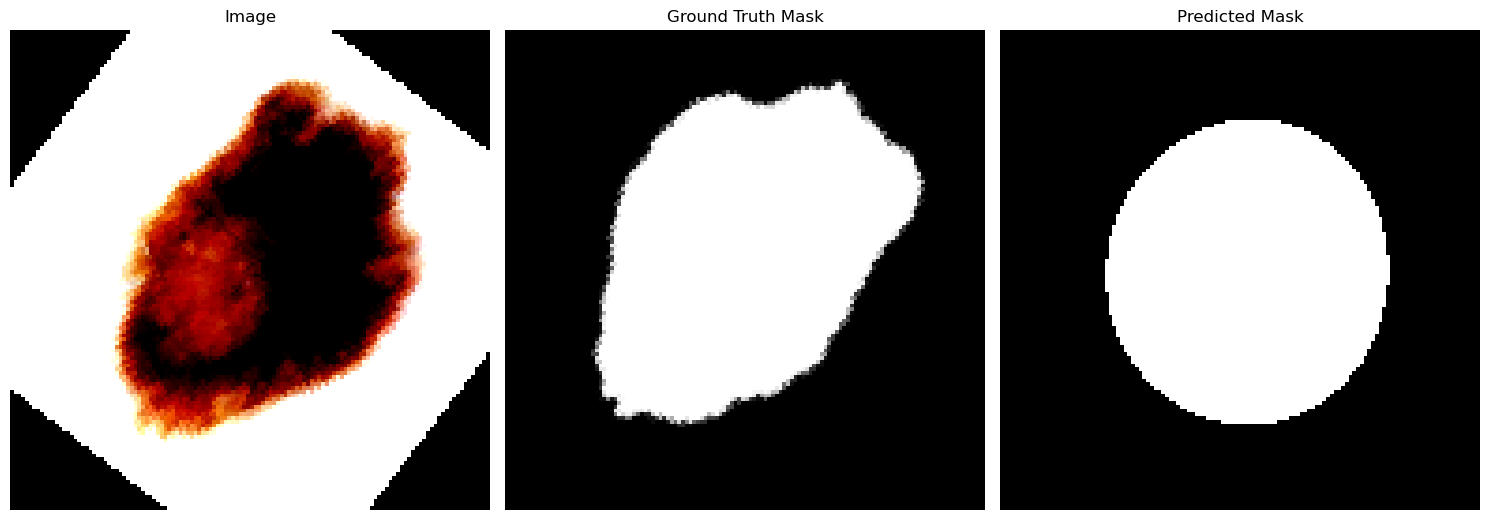

Epoch 9/45: Training Loss: 0.2532, Validation Loss: 0.2168, IoU: 0.6640, Dice Score: 0.7888


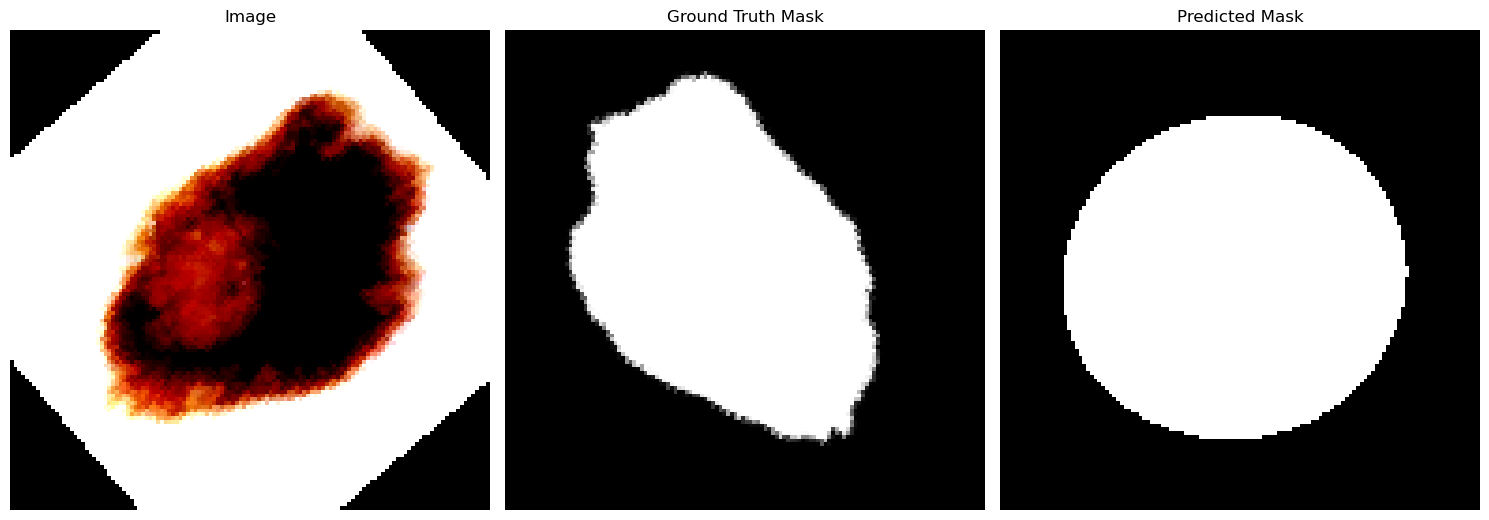

Epoch 10/45: Training Loss: 0.2476, Validation Loss: 0.2358, IoU: 0.6676, Dice Score: 0.7874


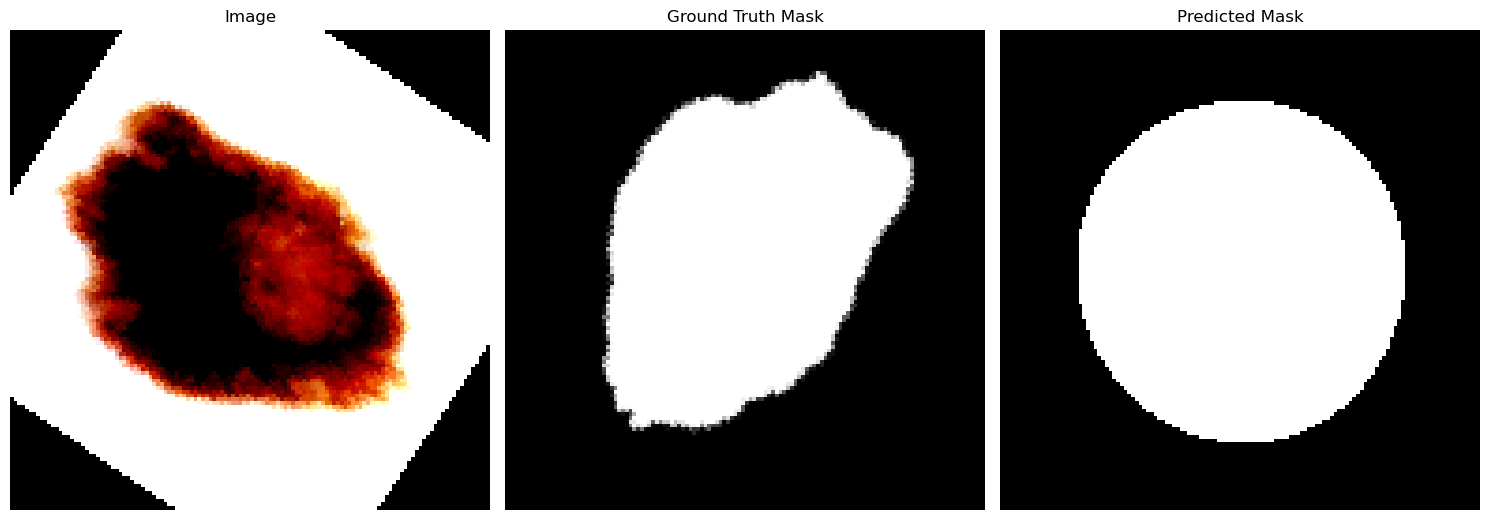

Epoch 11/45: Training Loss: 0.2427, Validation Loss: 0.2182, IoU: 0.6807, Dice Score: 0.7981


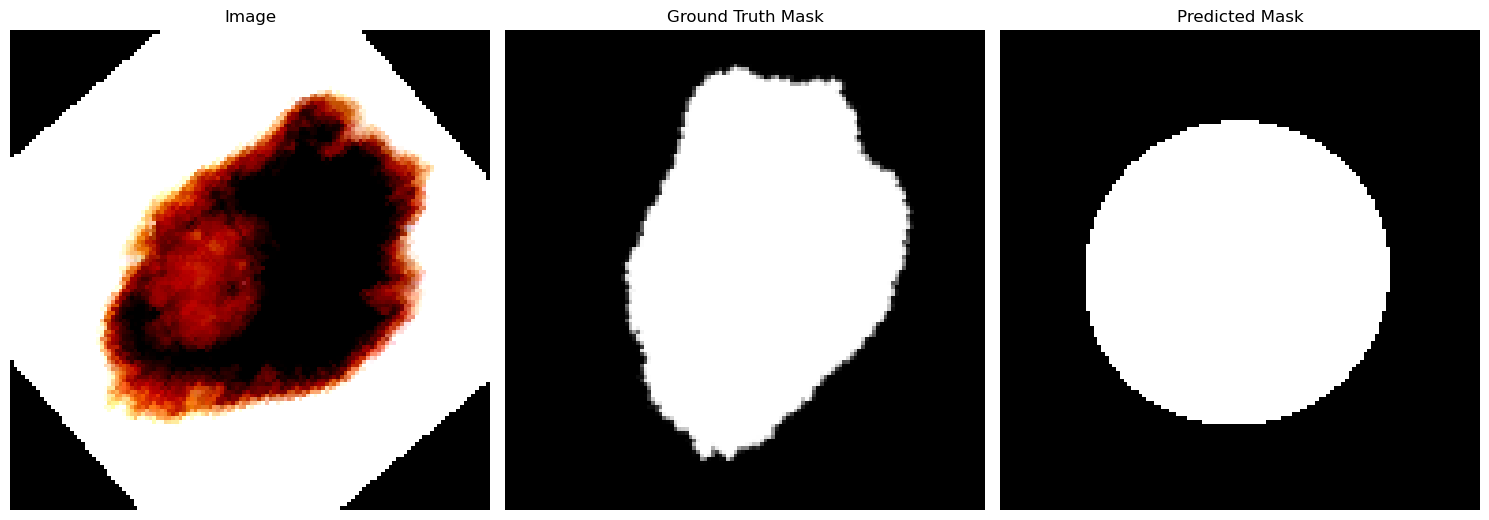

Epoch 12/45: Training Loss: 0.2456, Validation Loss: 0.2140, IoU: 0.6543, Dice Score: 0.7748


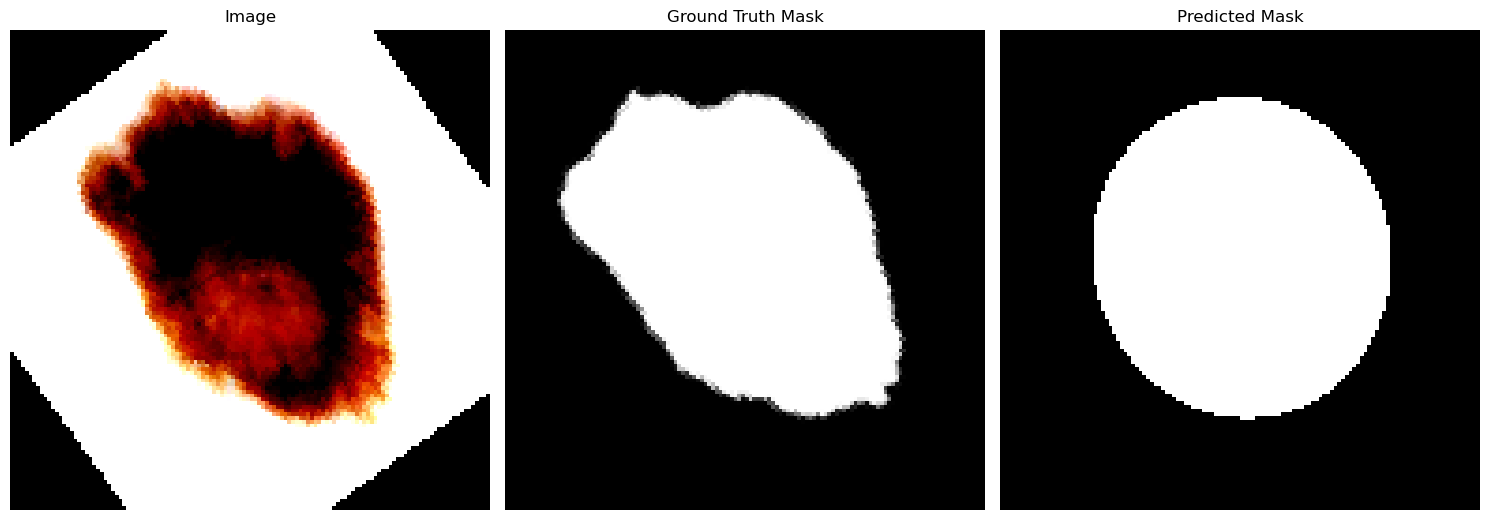

Epoch 13/45: Training Loss: 0.2434, Validation Loss: 0.2166, IoU: 0.6629, Dice Score: 0.7812


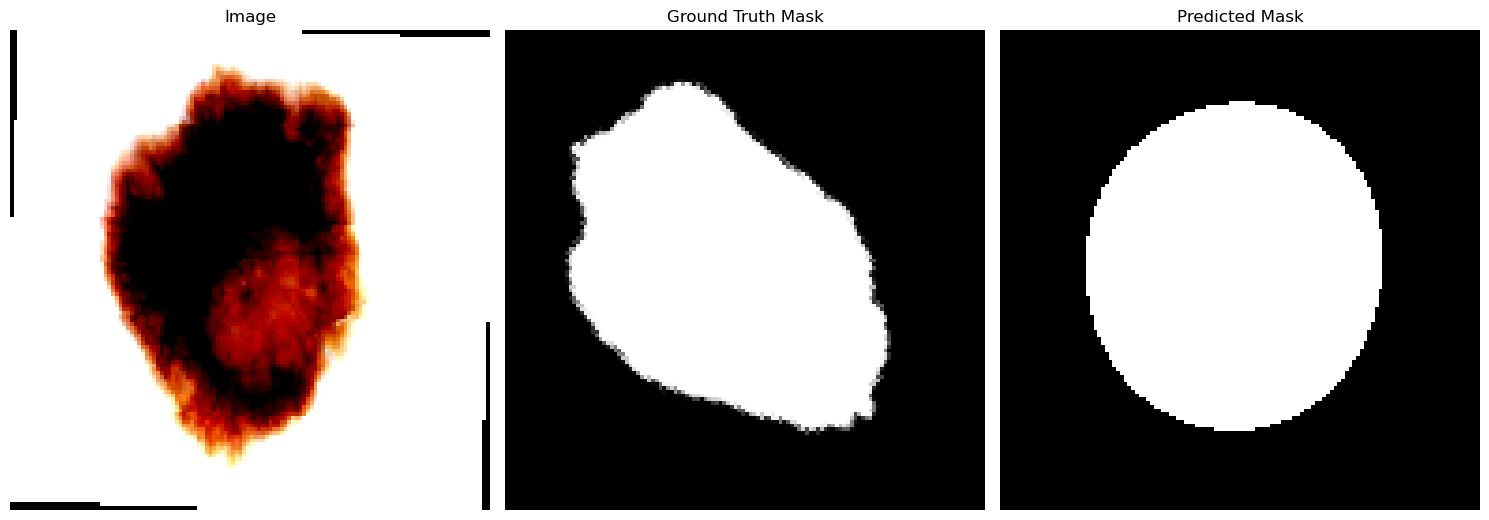

Epoch 14/45: Training Loss: 0.2342, Validation Loss: 0.2074, IoU: 0.6674, Dice Score: 0.7852


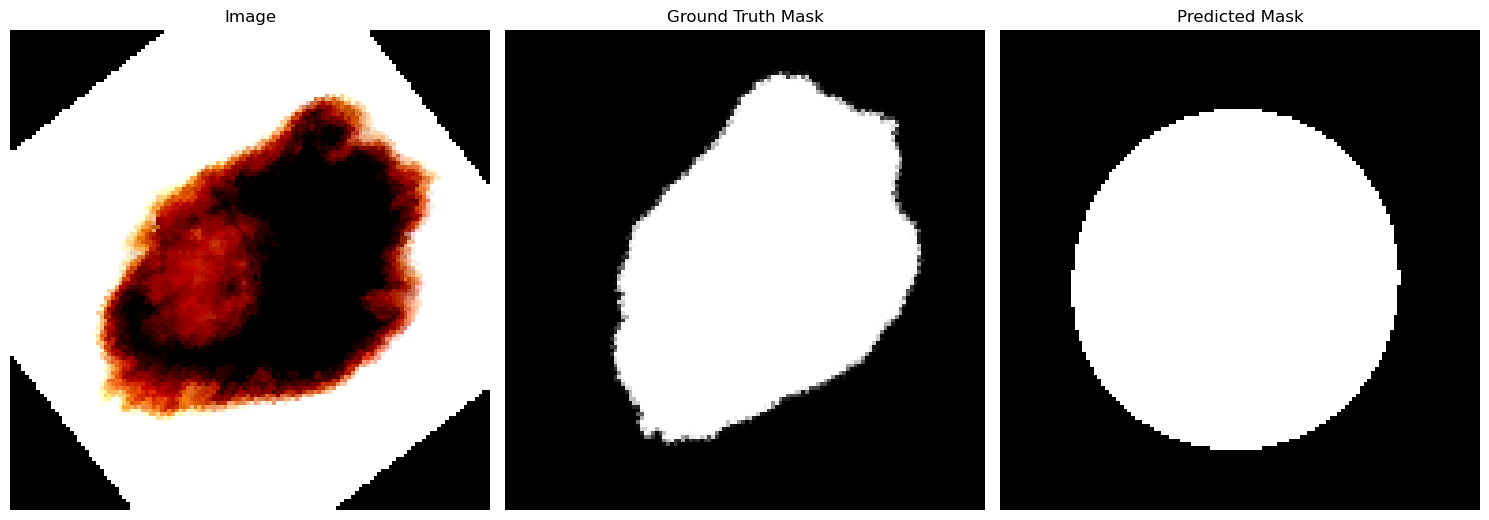

Epoch 15/45: Training Loss: 0.2295, Validation Loss: 0.2169, IoU: 0.6736, Dice Score: 0.7929


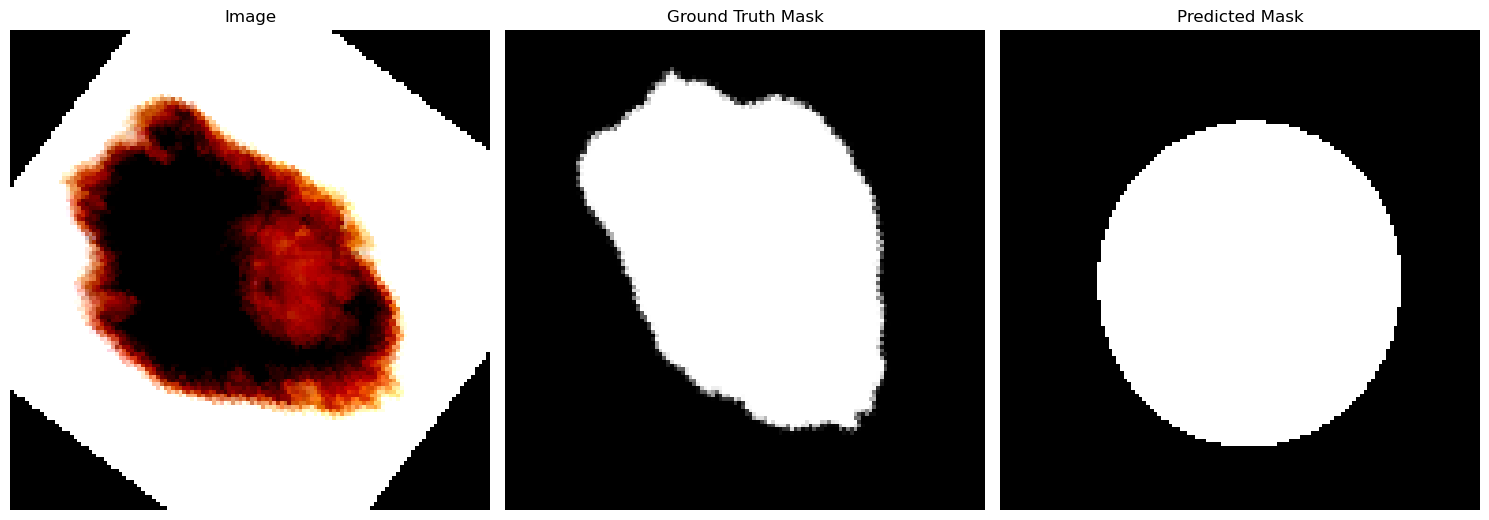

Epoch 16/45: Training Loss: 0.2422, Validation Loss: 0.2277, IoU: 0.6663, Dice Score: 0.7882


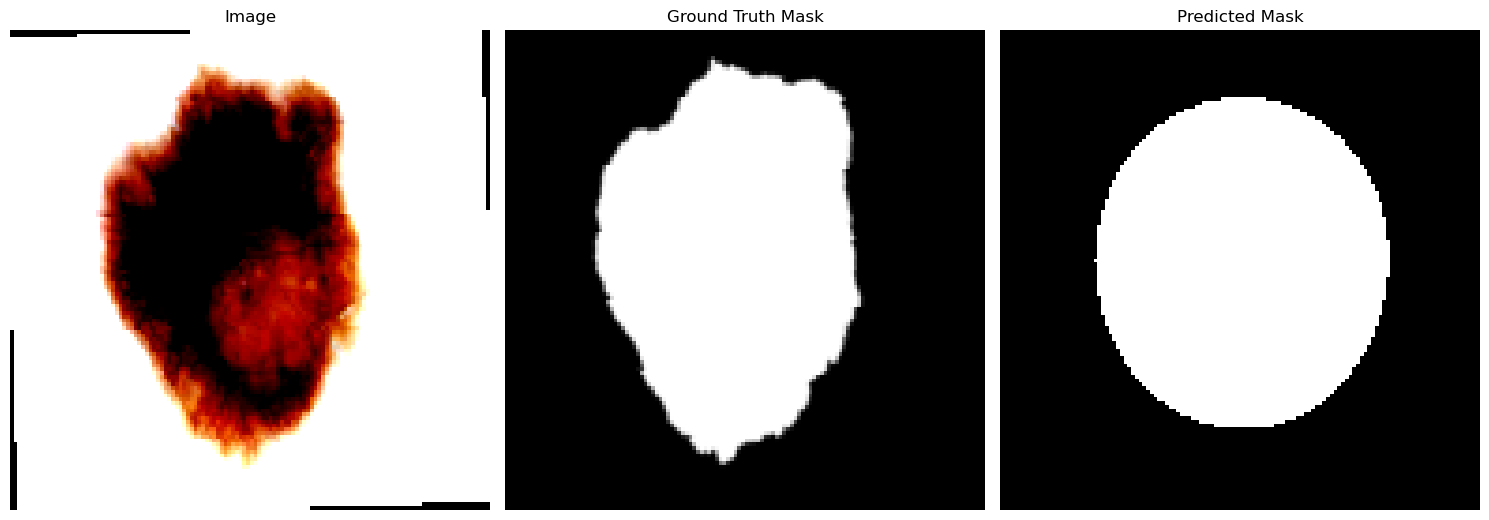

Epoch 17/45: Training Loss: 0.2420, Validation Loss: 0.2230, IoU: 0.6578, Dice Score: 0.7766


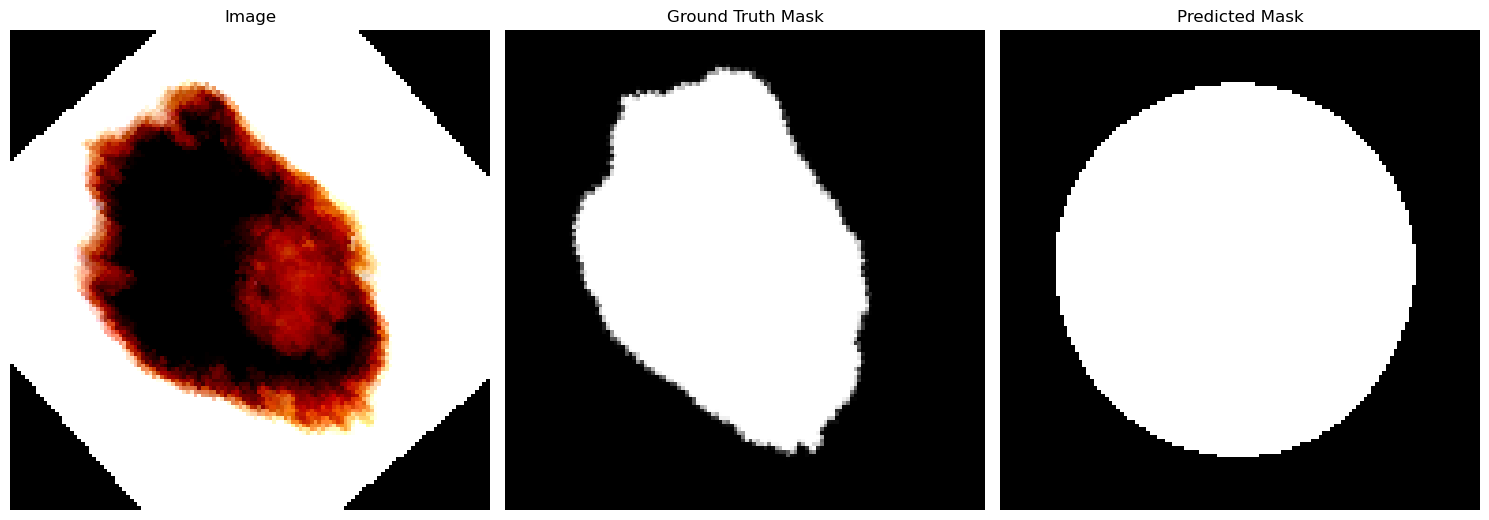

Epoch 18/45: Training Loss: 0.2359, Validation Loss: 0.2728, IoU: 0.6536, Dice Score: 0.7765


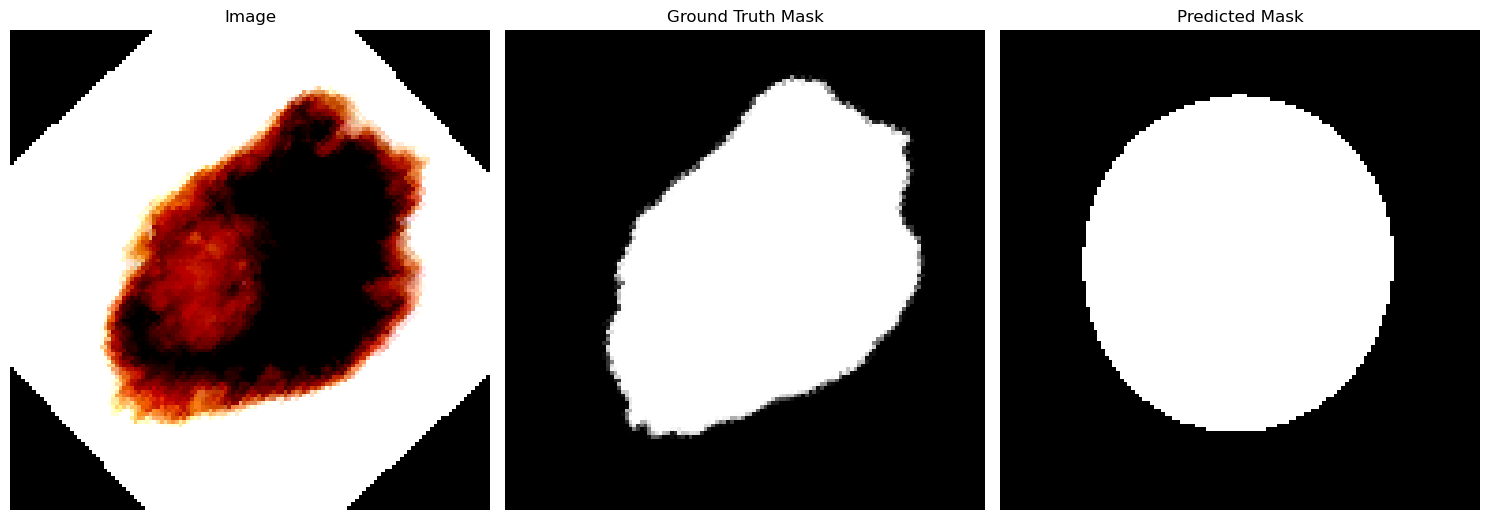

Epoch 19/45: Training Loss: 0.2317, Validation Loss: 0.2081, IoU: 0.6610, Dice Score: 0.7841


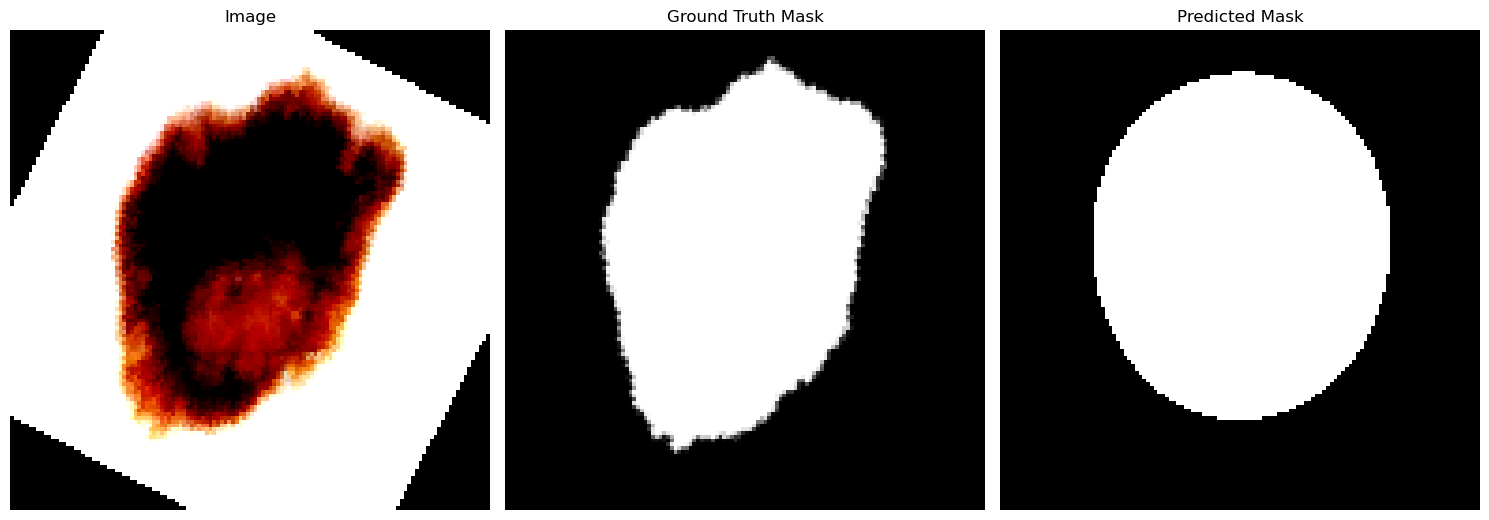

Epoch 20/45: Training Loss: 0.2276, Validation Loss: 0.2155, IoU: 0.6813, Dice Score: 0.7976


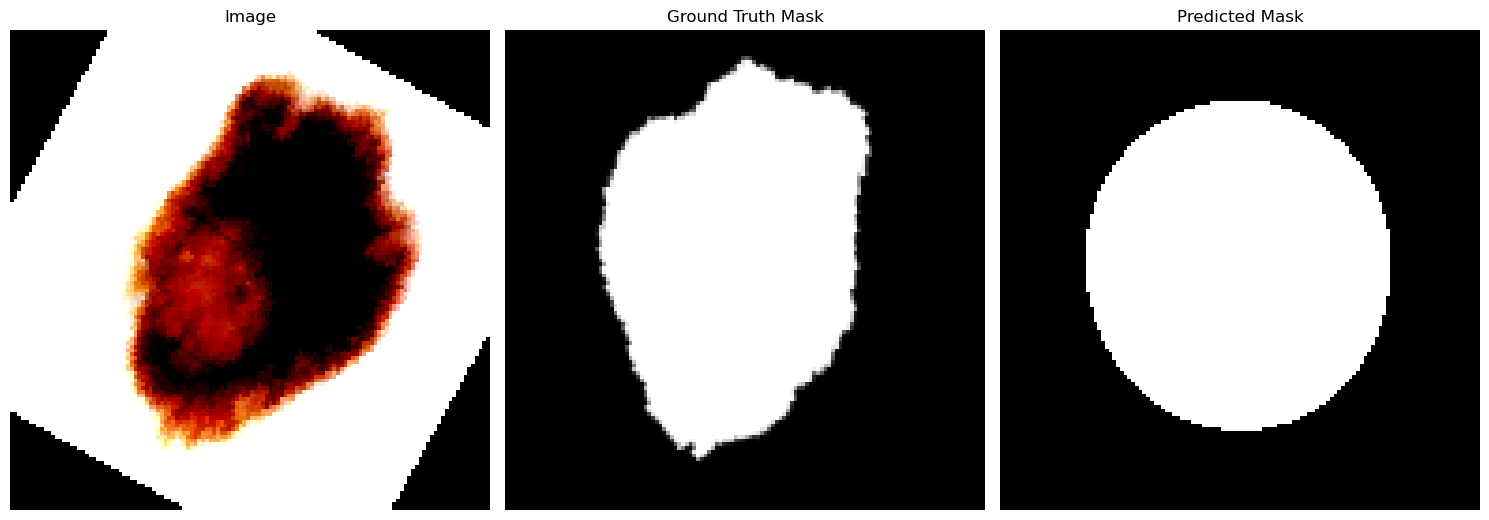

Epoch 21/45: Training Loss: 0.2273, Validation Loss: 0.2230, IoU: 0.6754, Dice Score: 0.7943


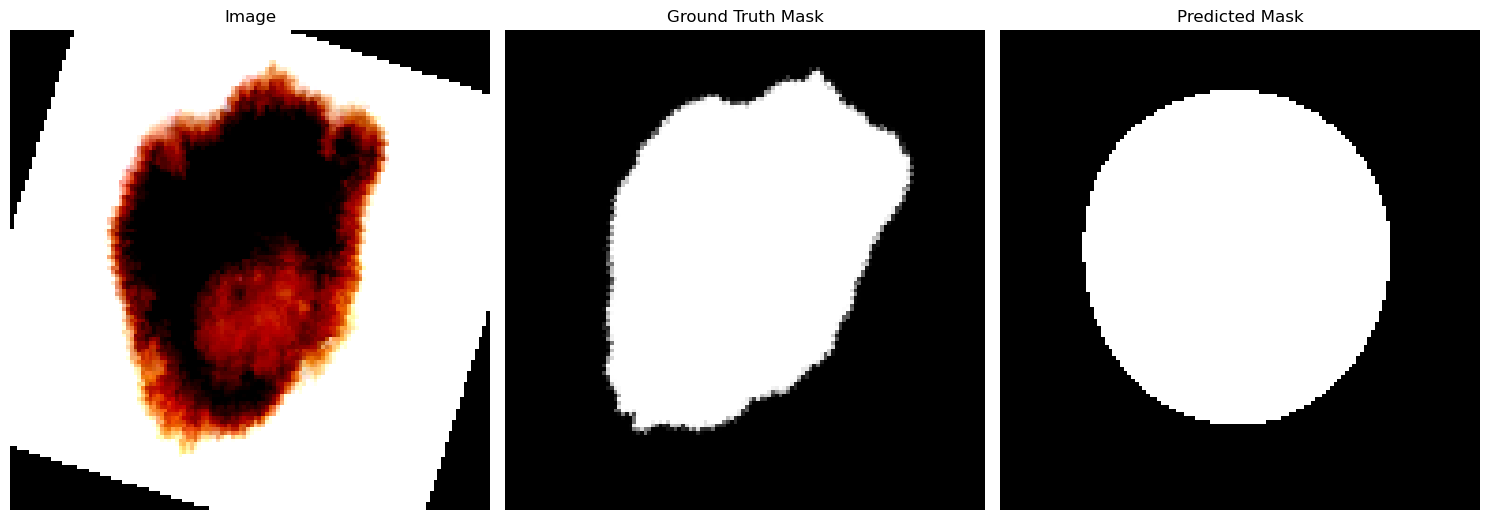

Epoch 22/45: Training Loss: 0.2359, Validation Loss: 0.2259, IoU: 0.6780, Dice Score: 0.7934


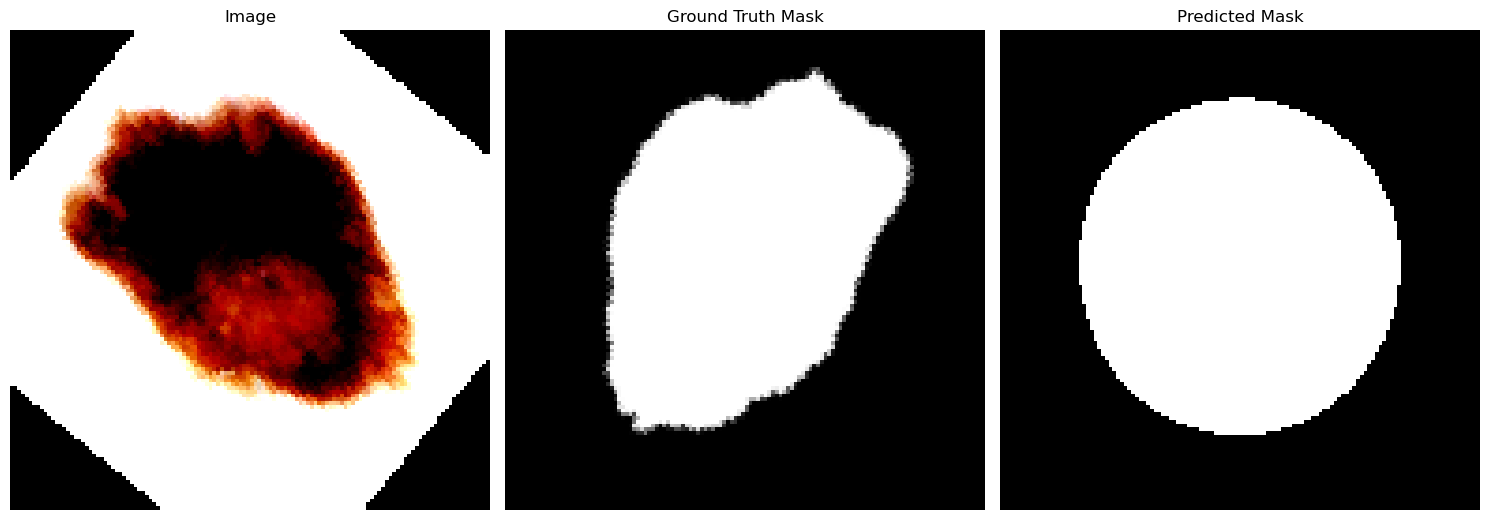

Epoch 23/45: Training Loss: 0.2217, Validation Loss: 0.2181, IoU: 0.6827, Dice Score: 0.8008


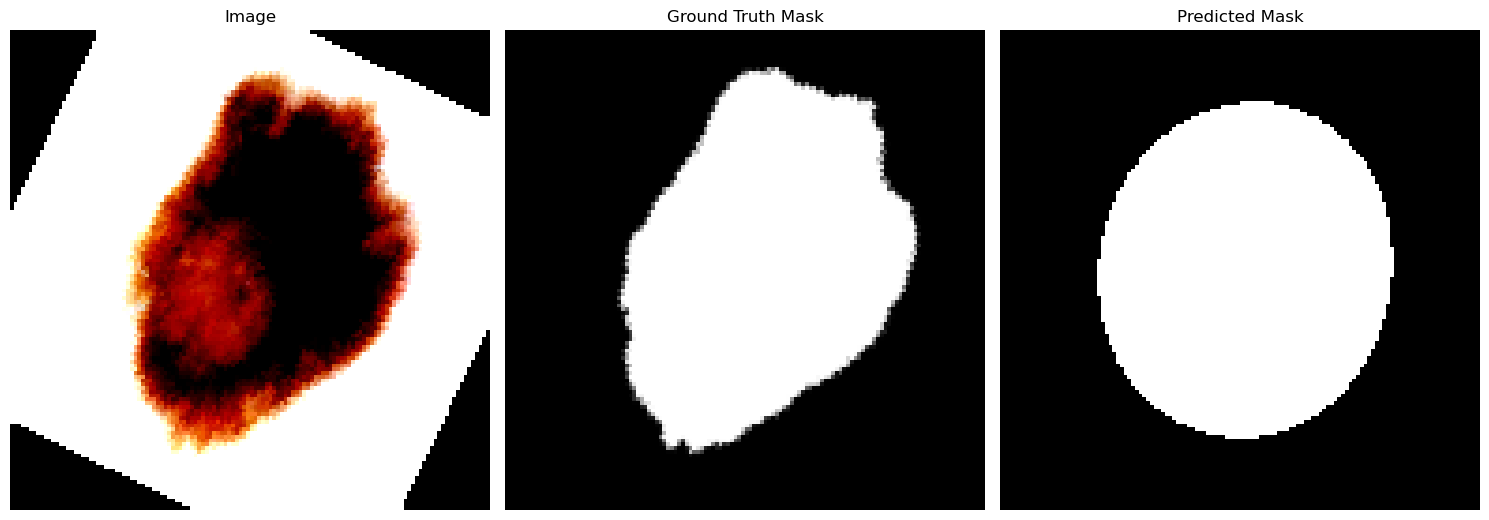

Epoch 24/45: Training Loss: 0.2245, Validation Loss: 0.2238, IoU: 0.6630, Dice Score: 0.7816


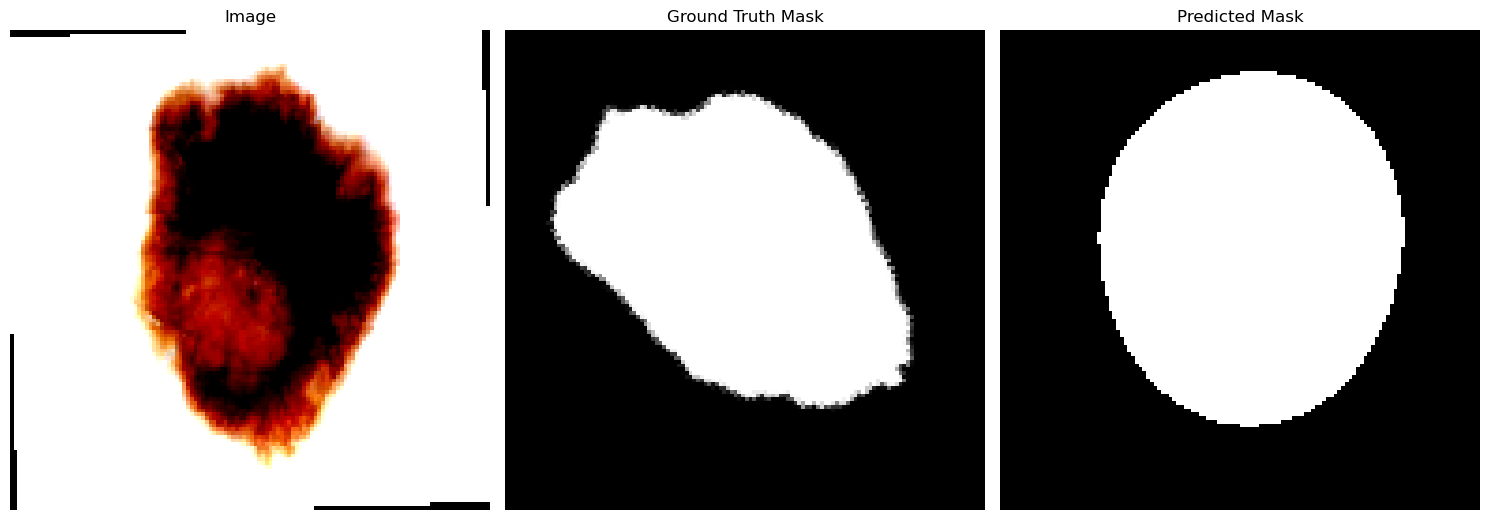

Epoch 25/45: Training Loss: 0.2170, Validation Loss: 0.2582, IoU: 0.6504, Dice Score: 0.7748


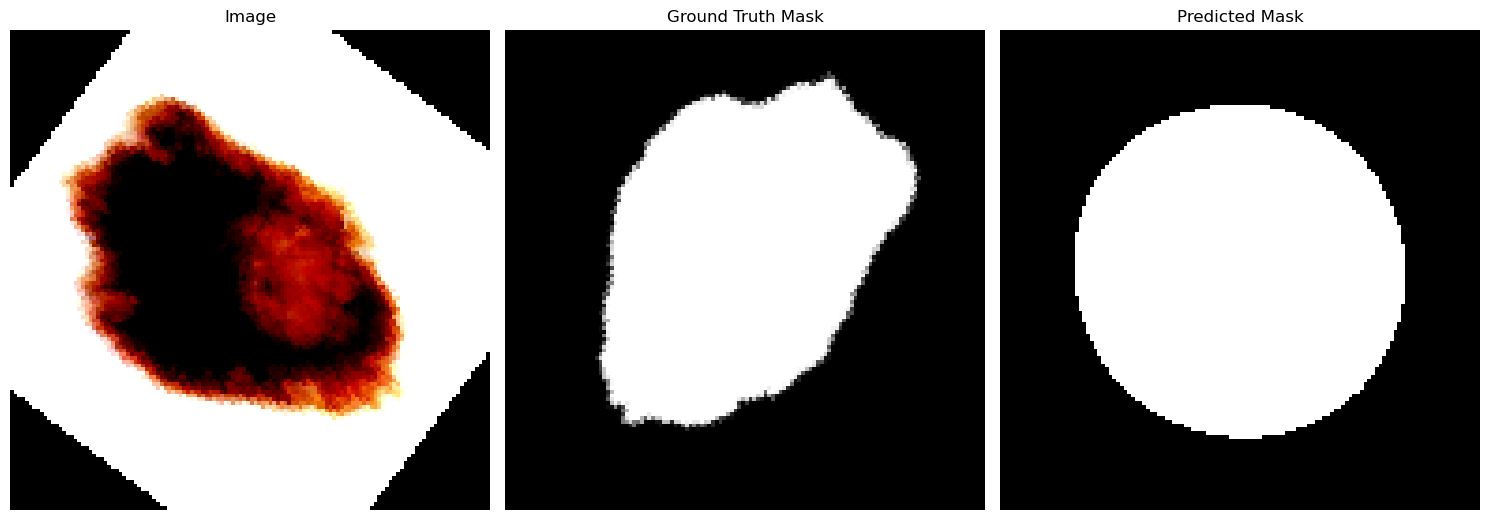

Epoch 26/45: Training Loss: 0.2243, Validation Loss: 0.2204, IoU: 0.6814, Dice Score: 0.8007


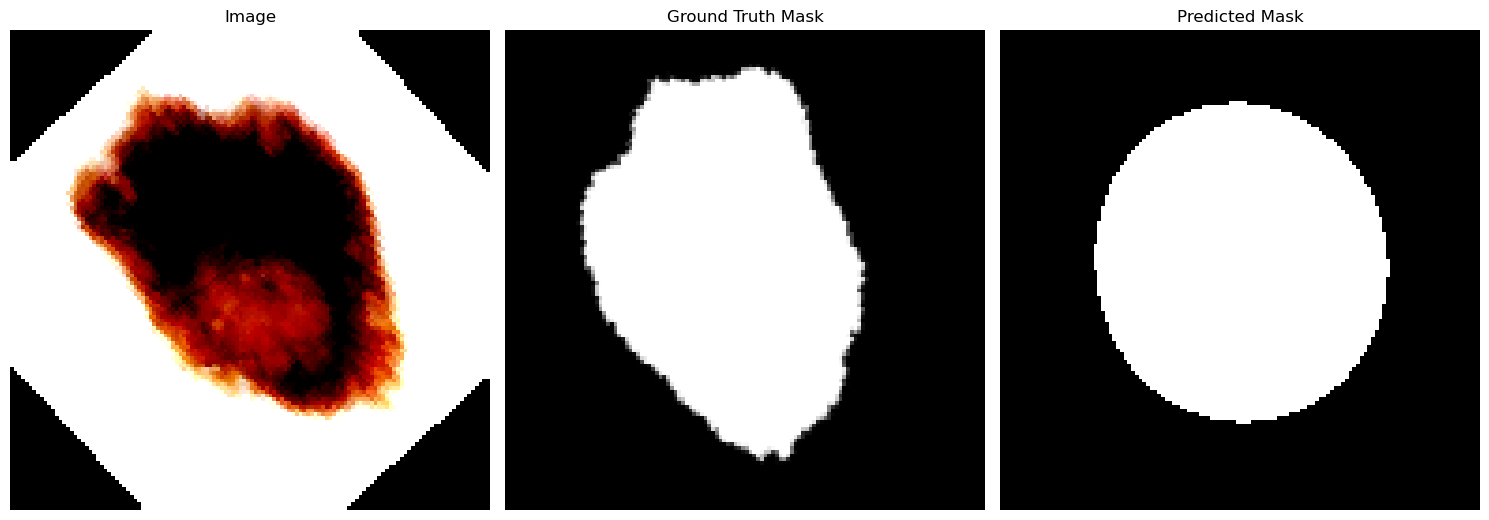

Epoch 27/45: Training Loss: 0.2306, Validation Loss: 0.2170, IoU: 0.6567, Dice Score: 0.7787


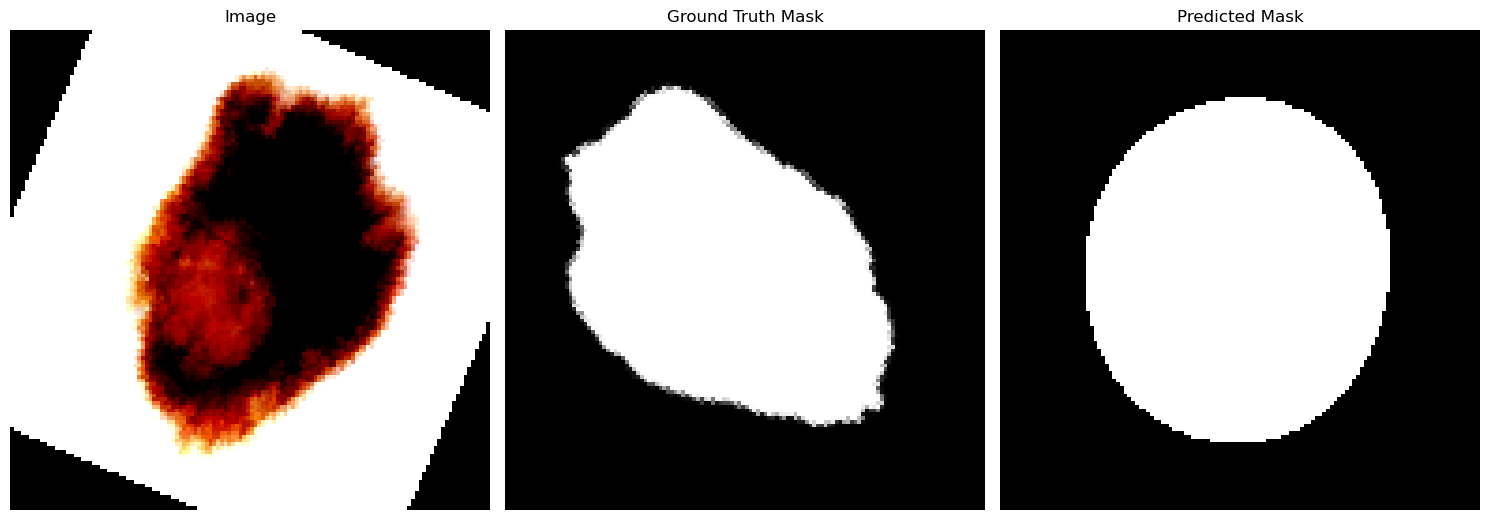

Epoch 28/45: Training Loss: 0.2245, Validation Loss: 0.2389, IoU: 0.6611, Dice Score: 0.7814


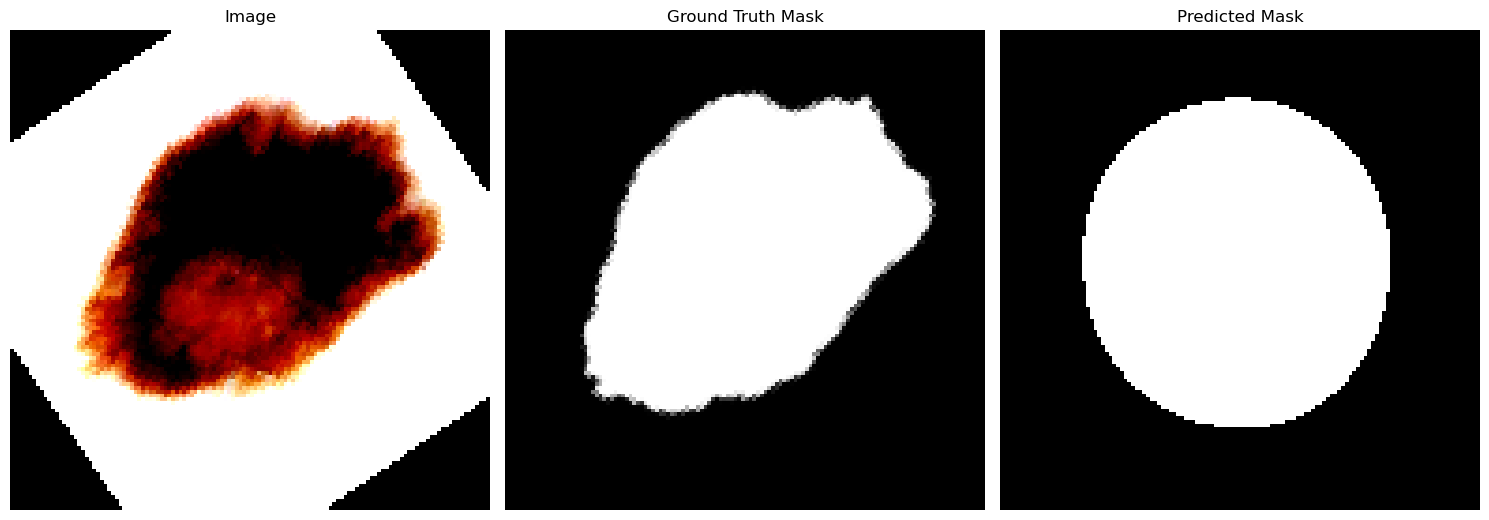

Epoch 29/45: Training Loss: 0.2207, Validation Loss: 0.2081, IoU: 0.6787, Dice Score: 0.7956


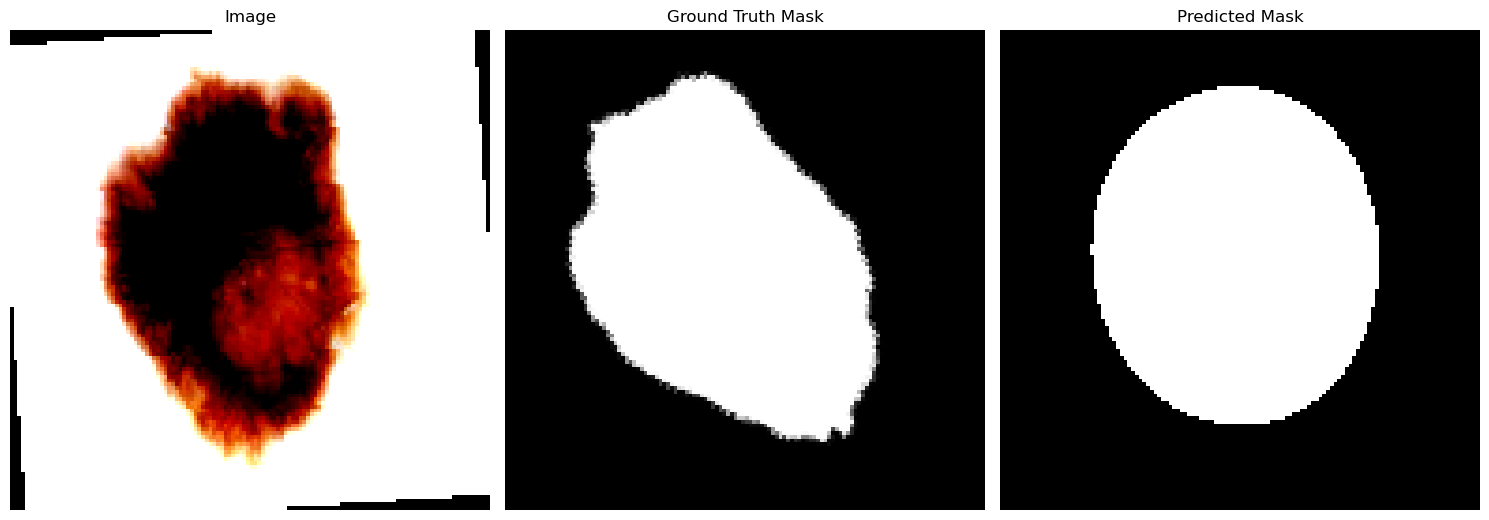

Epoch 30/45: Training Loss: 0.2189, Validation Loss: 0.2187, IoU: 0.6726, Dice Score: 0.7911


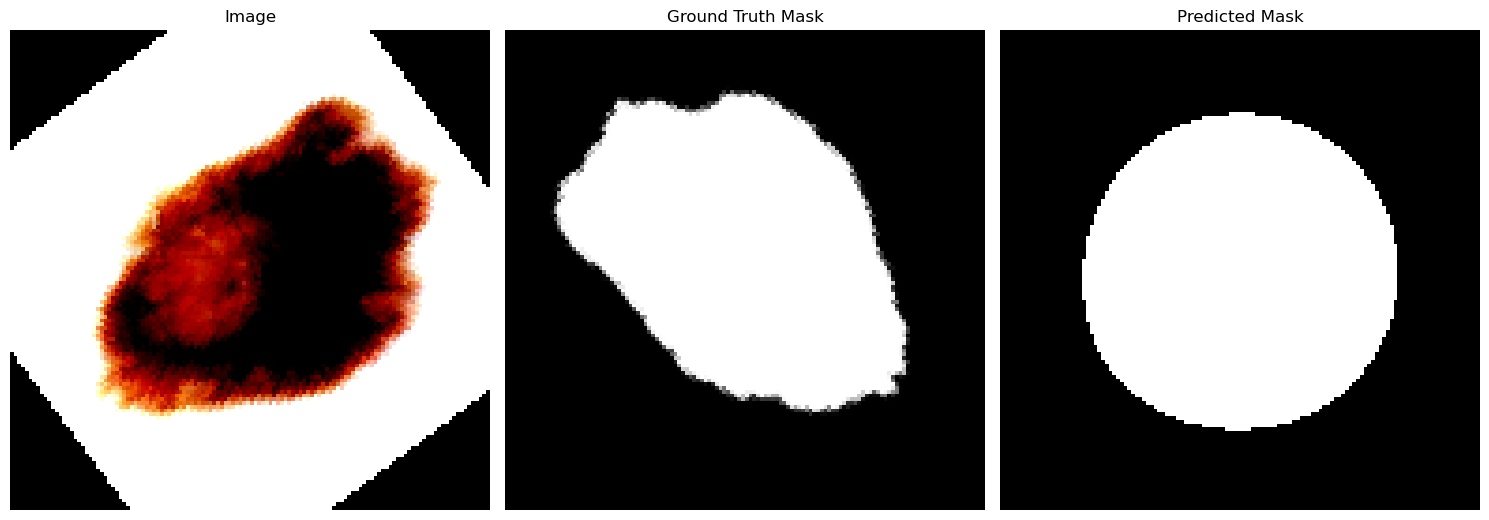

Epoch 31/45: Training Loss: 0.2197, Validation Loss: 0.2178, IoU: 0.6740, Dice Score: 0.7918


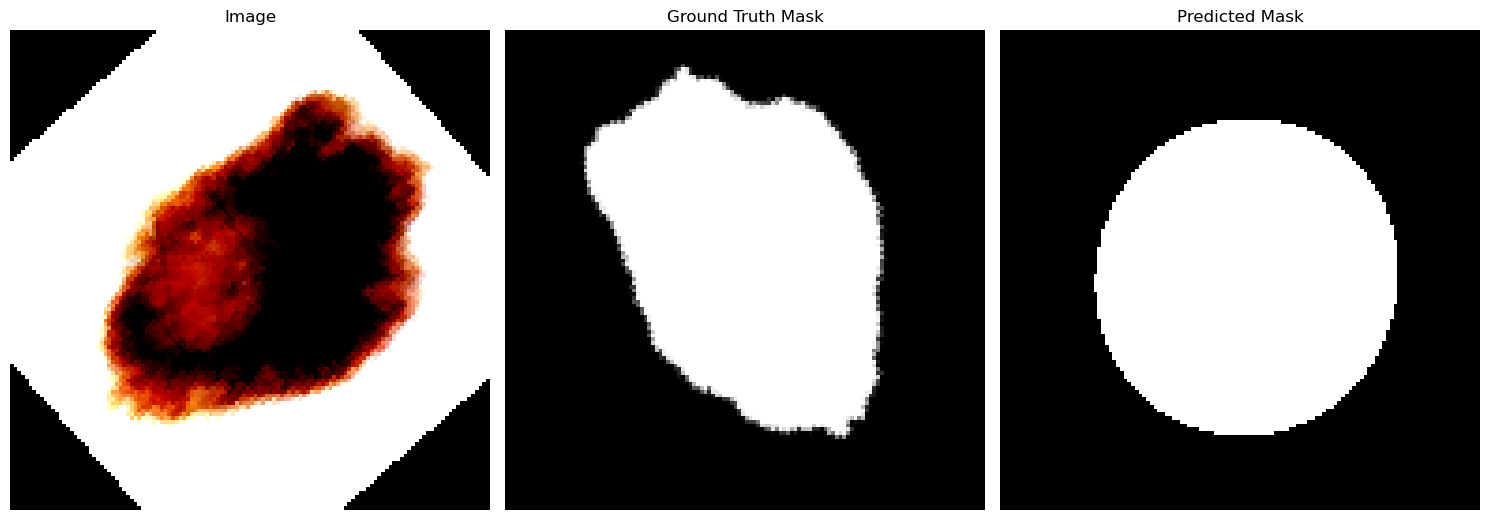

Epoch 32/45: Training Loss: 0.2183, Validation Loss: 0.2001, IoU: 0.6784, Dice Score: 0.7943


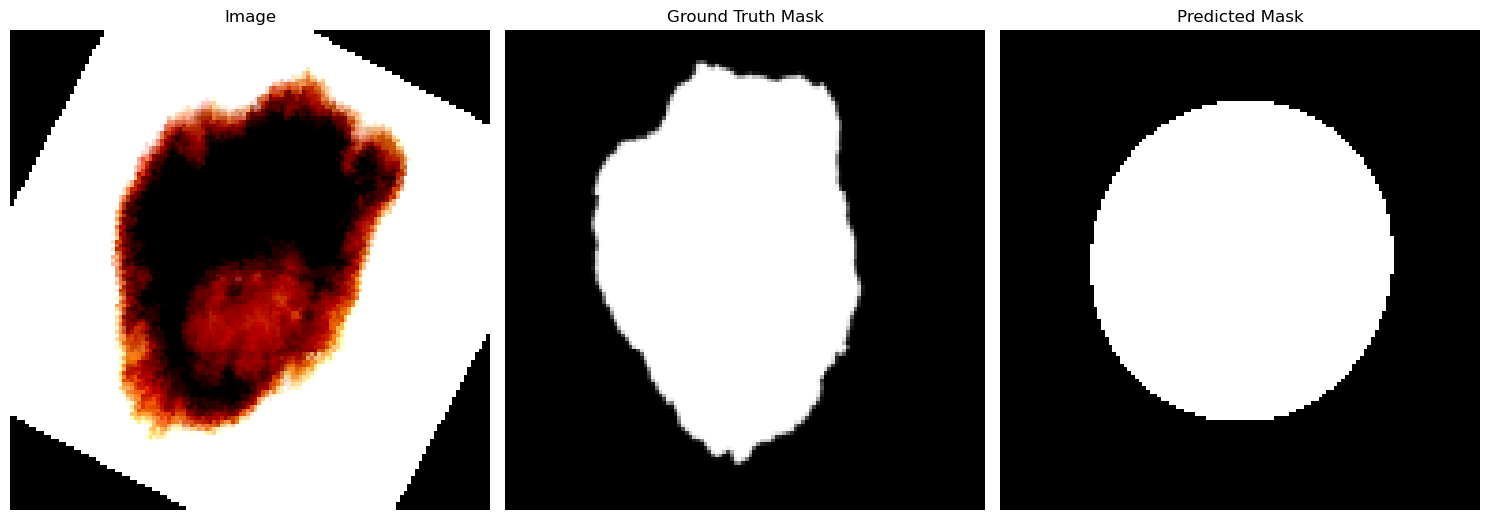

Epoch 33/45: Training Loss: 0.2147, Validation Loss: 0.2085, IoU: 0.6674, Dice Score: 0.7847


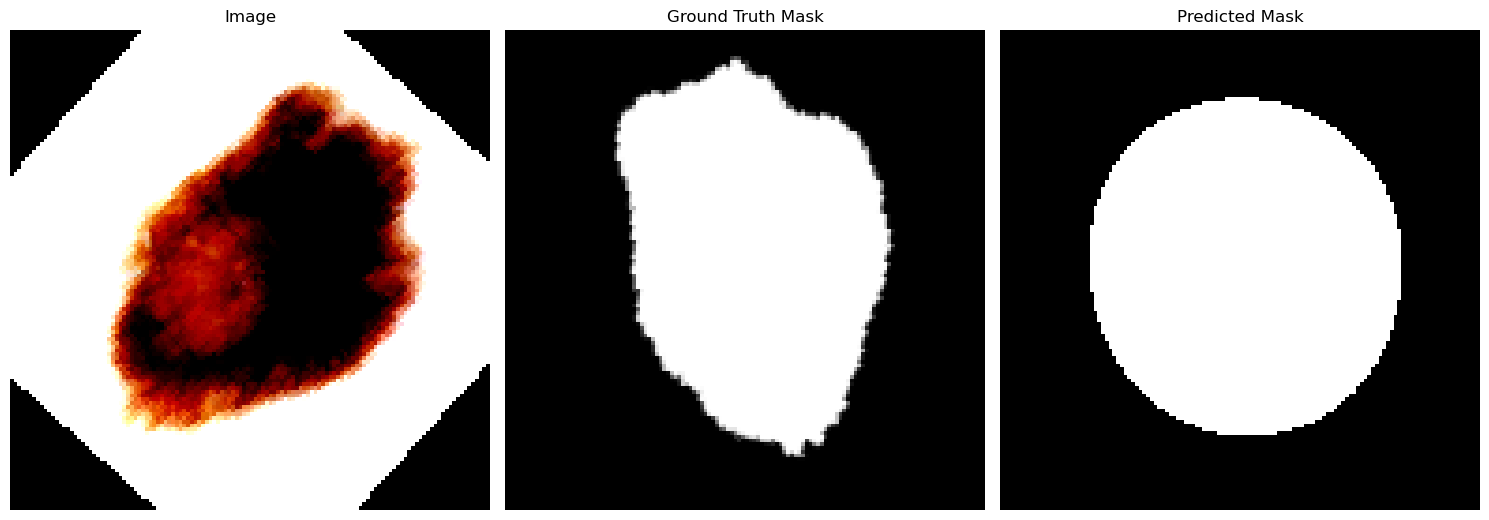

Epoch 34/45: Training Loss: 0.2095, Validation Loss: 0.2237, IoU: 0.6623, Dice Score: 0.7818


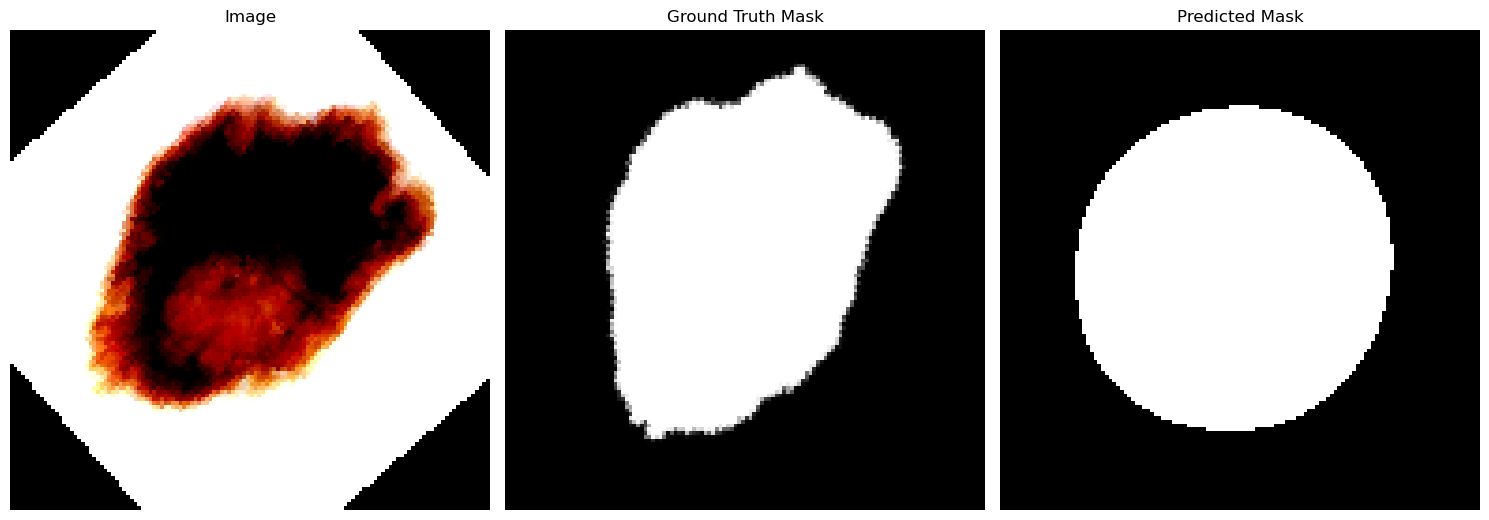

Epoch 35/45: Training Loss: 0.2141, Validation Loss: 0.2107, IoU: 0.6805, Dice Score: 0.7982


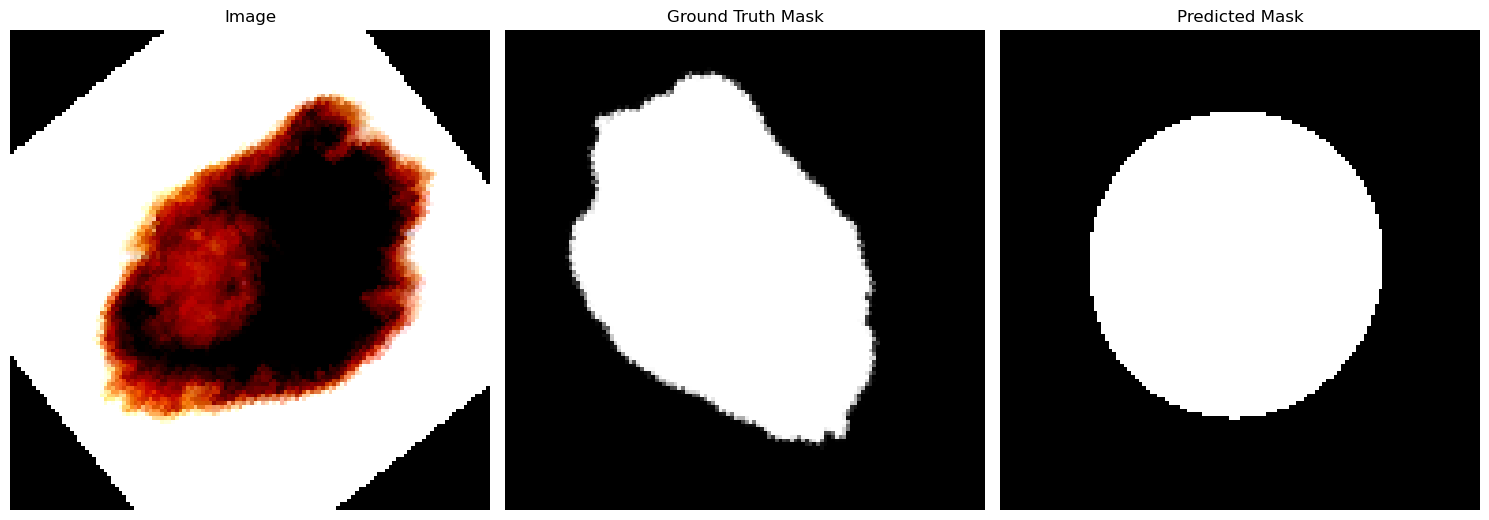

Epoch 36/45: Training Loss: 0.2090, Validation Loss: 0.2276, IoU: 0.6227, Dice Score: 0.7557


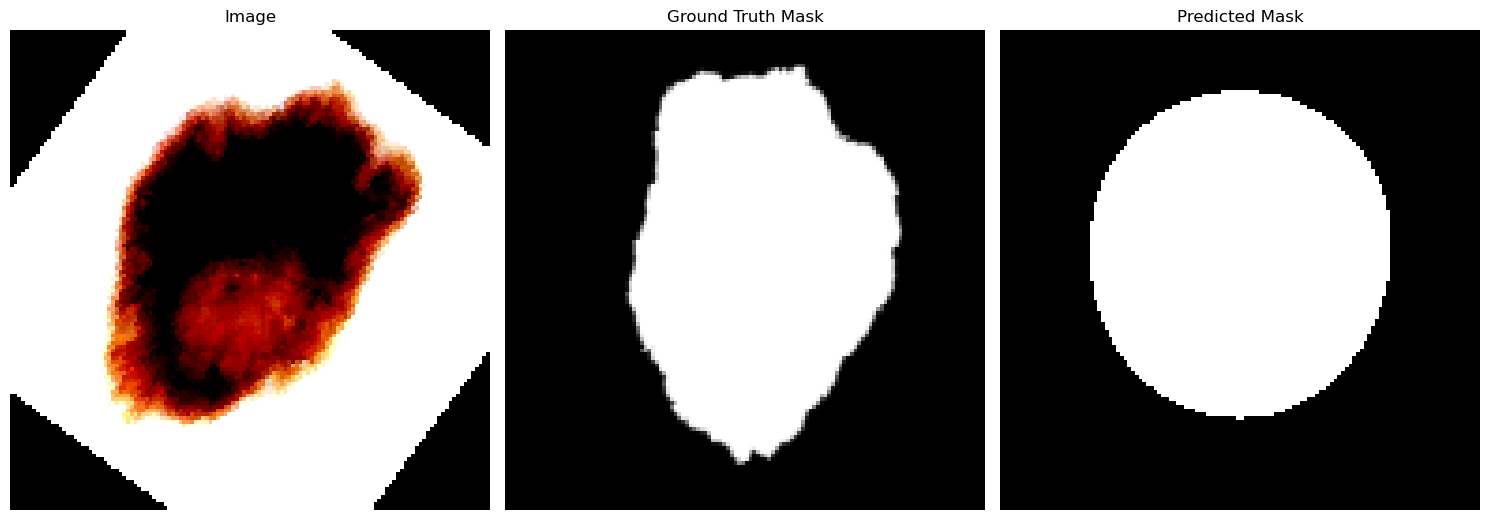

Epoch 37/45: Training Loss: 0.2117, Validation Loss: 0.2076, IoU: 0.6622, Dice Score: 0.7822


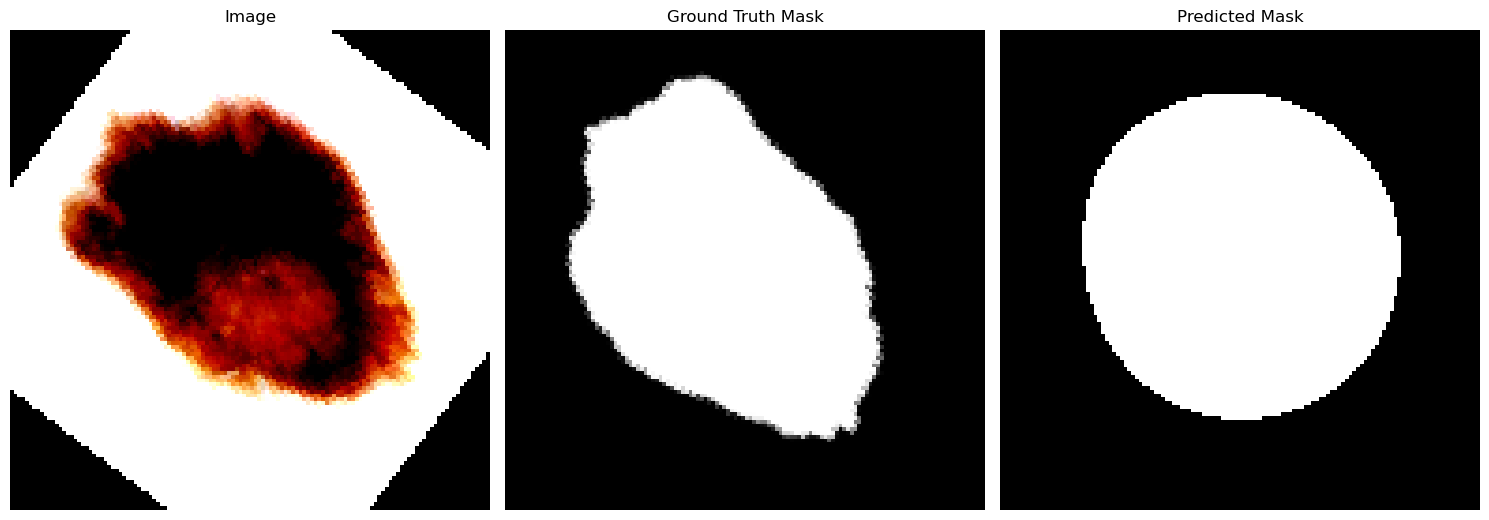

Epoch 38/45: Training Loss: 0.2123, Validation Loss: 0.2040, IoU: 0.6690, Dice Score: 0.7867


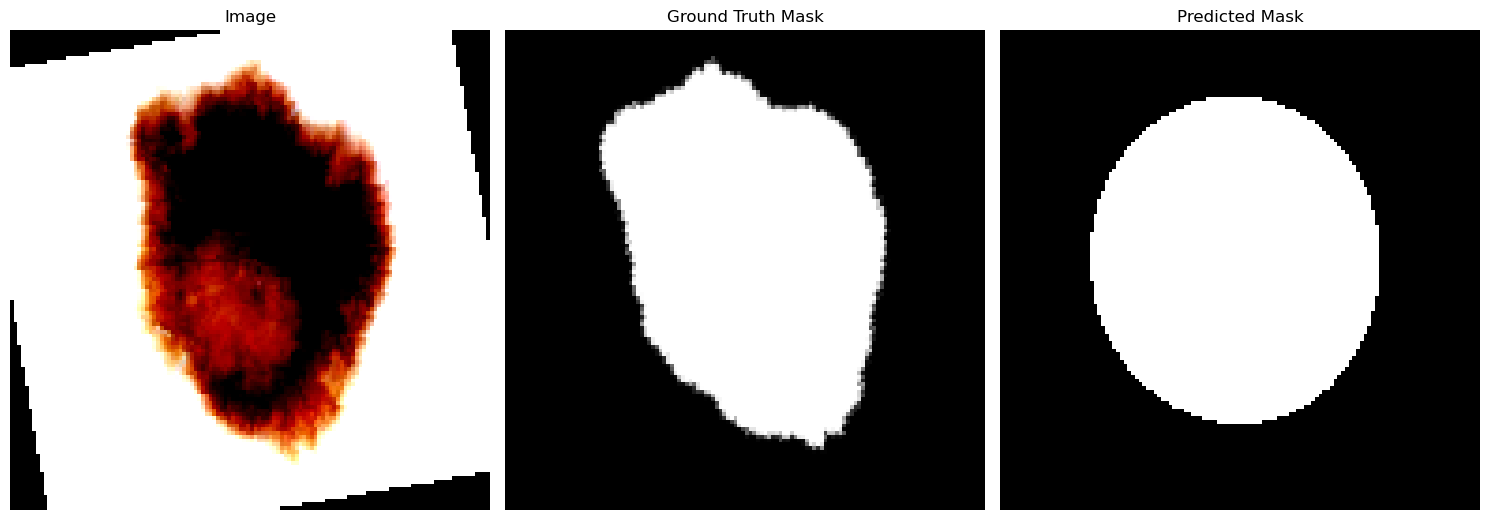

Epoch 39/45: Training Loss: 0.2148, Validation Loss: 0.2034, IoU: 0.6775, Dice Score: 0.7970


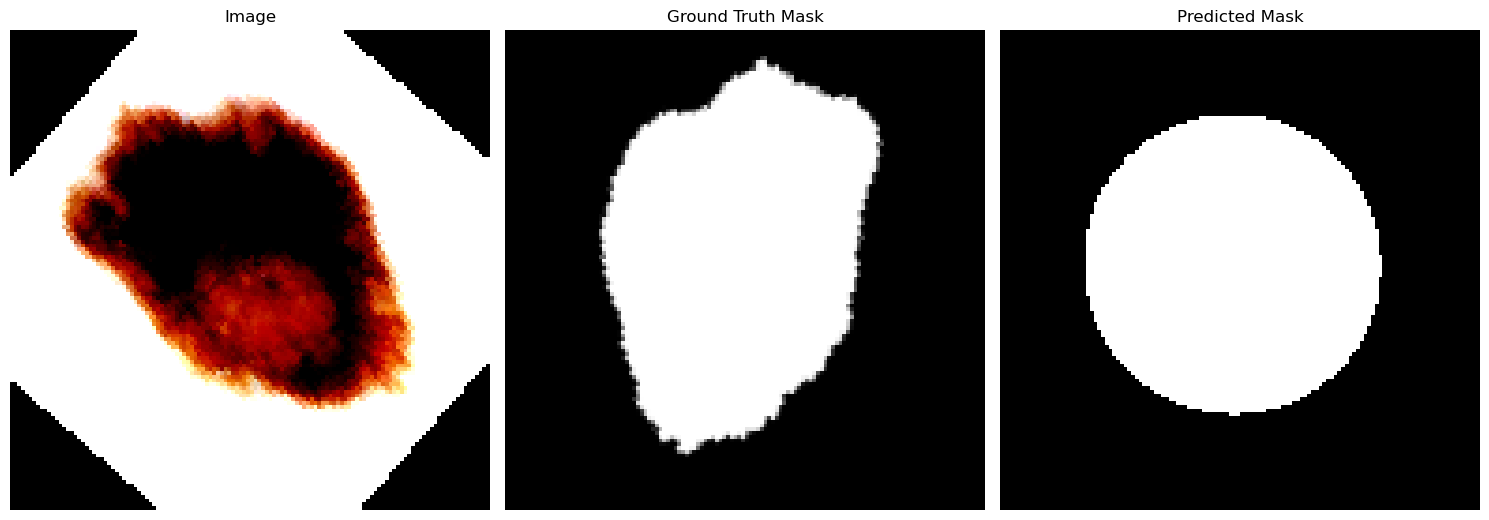

Epoch 40/45: Training Loss: 0.2165, Validation Loss: 0.2054, IoU: 0.6657, Dice Score: 0.7861


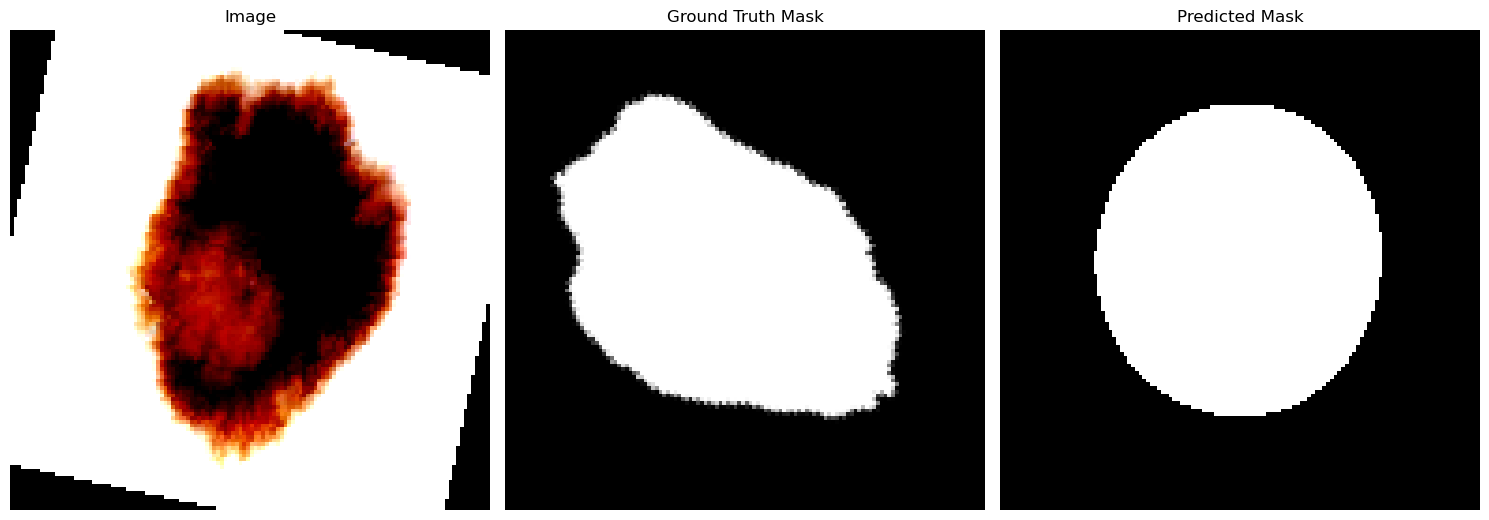

Epoch 41/45: Training Loss: 0.2129, Validation Loss: 0.2158, IoU: 0.6589, Dice Score: 0.7829


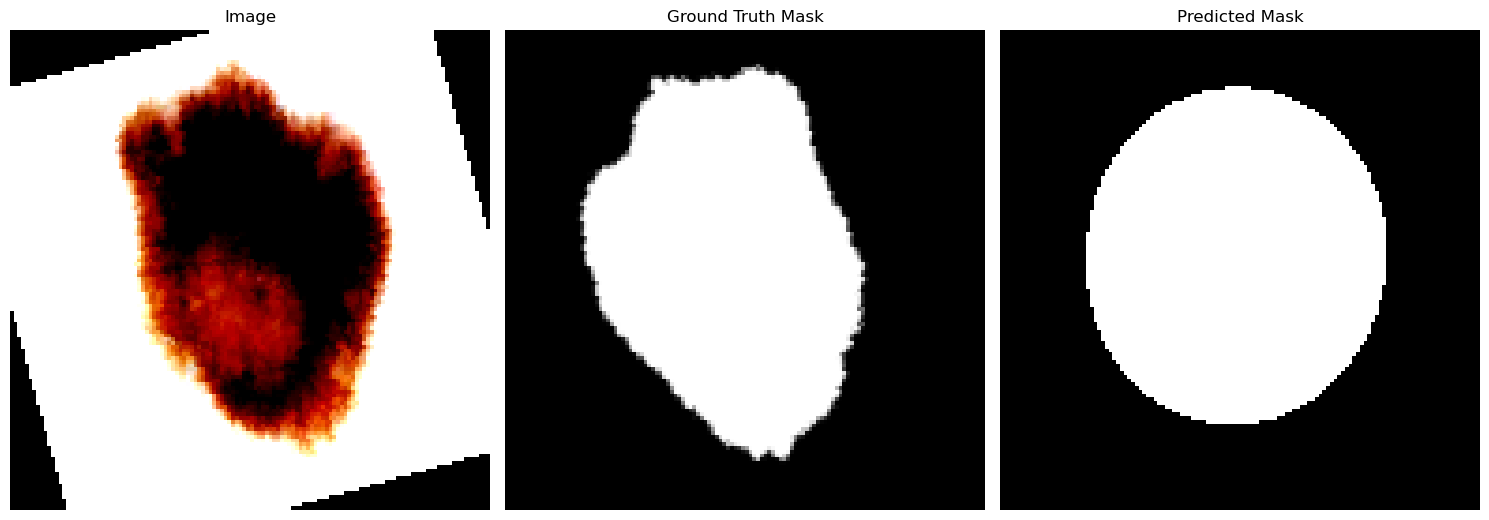

Epoch 42/45: Training Loss: 0.2083, Validation Loss: 0.2081, IoU: 0.6698, Dice Score: 0.7906


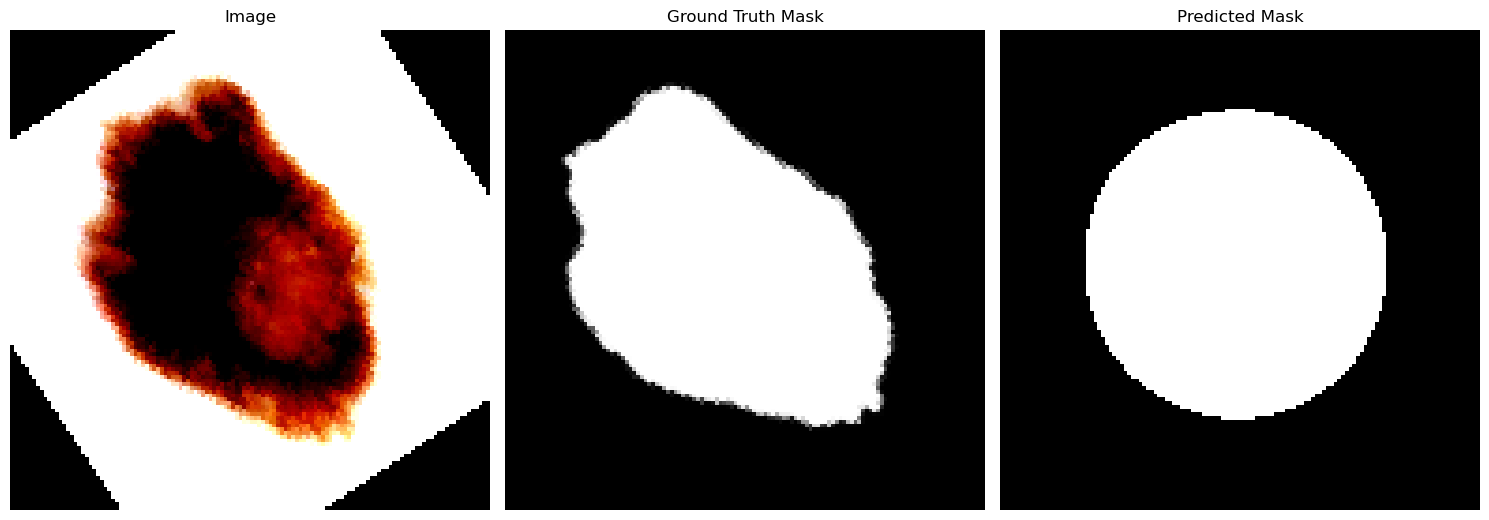

Epoch 43/45: Training Loss: 0.2066, Validation Loss: 0.2285, IoU: 0.6368, Dice Score: 0.7626


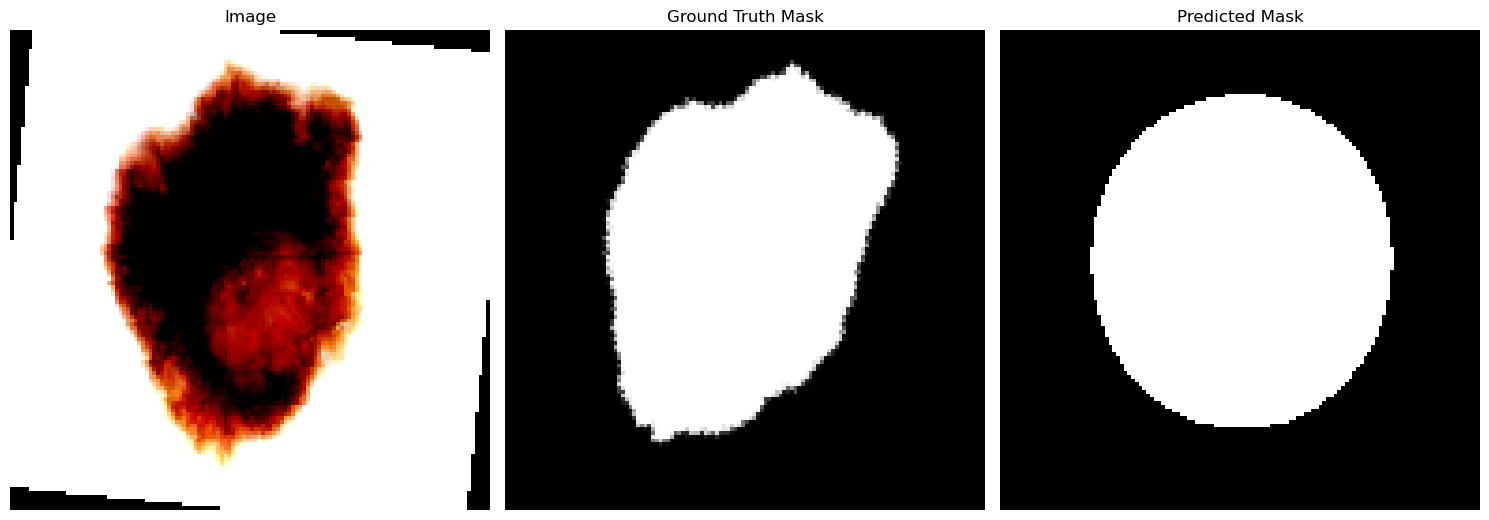

Epoch 44/45: Training Loss: 0.2084, Validation Loss: 0.2125, IoU: 0.6696, Dice Score: 0.7888


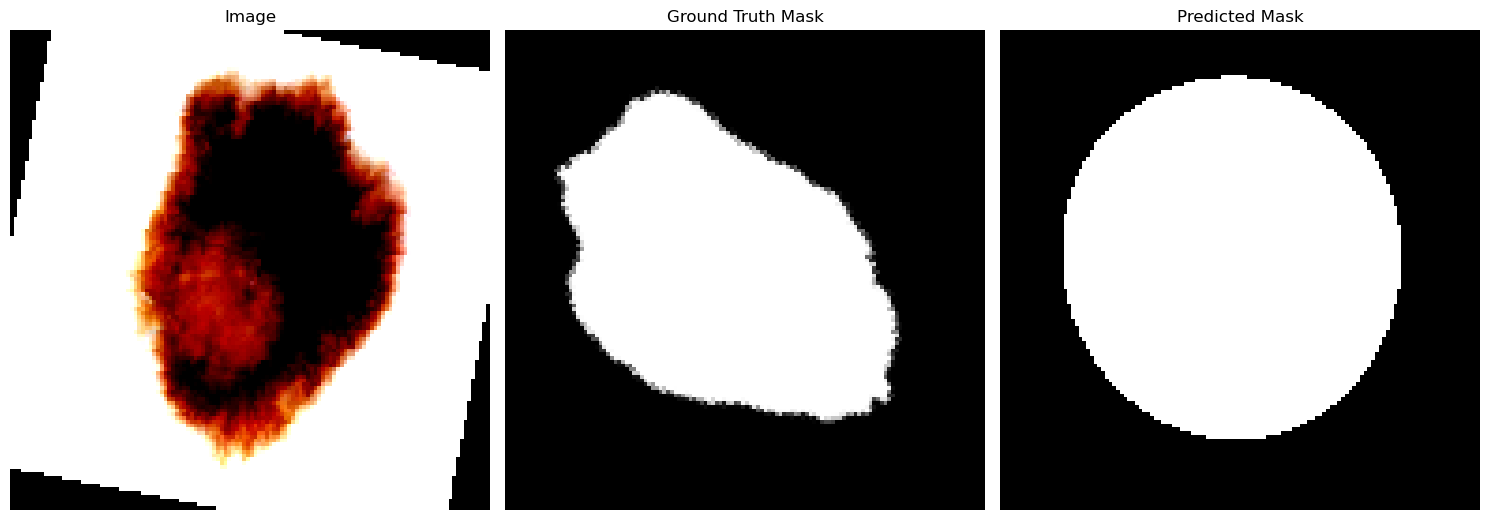

Epoch 45/45: Training Loss: 0.2117, Validation Loss: 0.2169, IoU: 0.6819, Dice Score: 0.7972

Dice Score : 0.797165008365007

IOU Score : 0.681915917151207



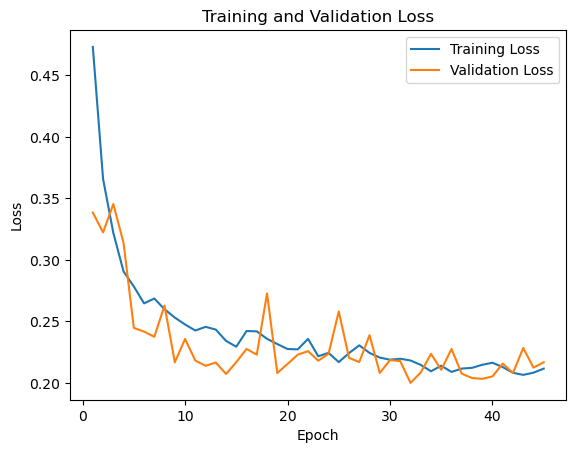

In [ ]:
task2_dice ,task2_iou , task2_train_loss , task2_val_loss = train_evaluate_model(model2, train_loader, test_loader, criterion, optimizer, device, num_epochs=num_epochs)

In [ ]:
model1_metrics = {'IoU': task1_iou, 'Dice Score': task1_dice, 'Train Loss': task1_train_loss, 'Val Loss': task1_val_loss}
model2_metrics = {'IoU': task2_iou, 'Dice Score': task2_dice, 'Train Loss': task2_train_loss, 'Val Loss': task2_val_loss}

data = {
    'Metrics': ['IoU', 'Dice Score', 'Train Loss', 'Val Loss'],
    'Model 1': [model1_metrics['IoU'], model1_metrics['Dice Score'], model1_metrics['Train Loss'], model1_metrics['Val Loss']],
    'Model 2': [model2_metrics['IoU'], model2_metrics['Dice Score'], model2_metrics['Train Loss'], model2_metrics['Val Loss']]
}

df = pd.DataFrame(data)

df

Metrics   Model 1   Model 2
0         IoU  0.635405  0.681916
1  Dice Score  0.767497  0.797165
2  Train Loss  0.291075  0.211674
3    Val Loss  0.289943  0.216854

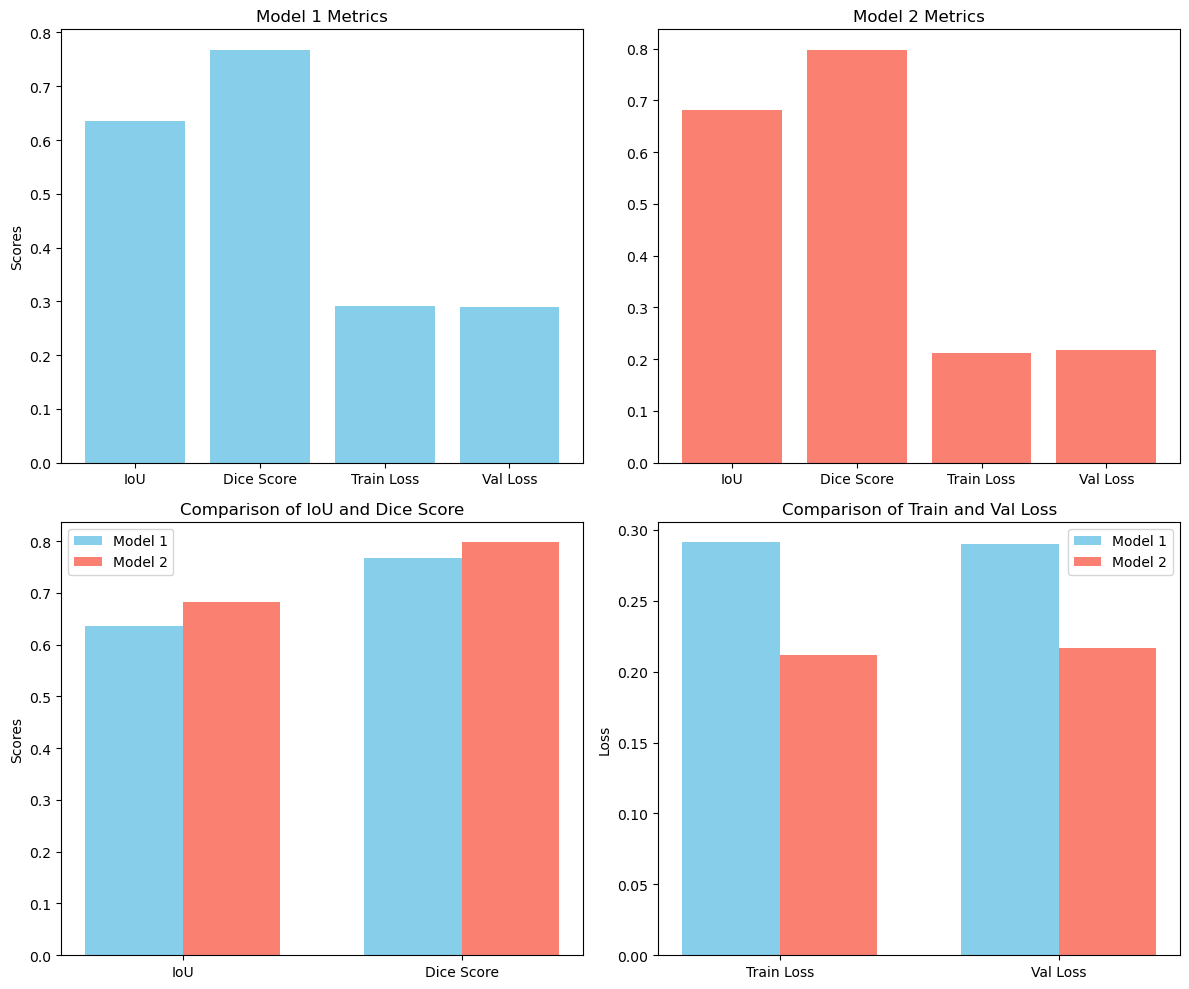

In [ ]:
metrics = ['IoU', 'Dice Score', 'Train Loss', 'Val Loss']
model1_scores = [model1_metrics['IoU'], model1_metrics['Dice Score'], model1_metrics['Train Loss'], model1_metrics['Val Loss']]
model2_scores = [model2_metrics['IoU'], model2_metrics['Dice Score'], model2_metrics['Train Loss'], model2_metrics['Val Loss']]

fig, axs = plt.subplots(2, 2, figsize=(12, 10))

axs[0, 0].bar(metrics, model1_scores, color='skyblue')
axs[0, 0].set_title('Model 1 Metrics')
axs[0, 0].set_ylabel('Scores')

axs[0, 1].bar(metrics, model2_scores, color='salmon')
axs[0, 1].set_title('Model 2 Metrics')

bar_width = 0.35

x = np.arange(len(metrics[:2]))
axs[1, 0].bar(x - bar_width/2, [model1_metrics['IoU'], model1_metrics['Dice Score']], width=bar_width, color='skyblue', label='Model 1')
axs[1, 0].bar(x + bar_width/2, [model2_metrics['IoU'], model2_metrics['Dice Score']], width=bar_width, color='salmon', label='Model 2')
axs[1, 0].set_title('Comparison of IoU and Dice Score')
axs[1, 0].set_ylabel('Scores')
axs[1, 0].set_xticks(x)
axs[1, 0].set_xticklabels(metrics[:2])
axs[1, 0].legend()

x = np.arange(len(metrics[2:]))
axs[1, 1].bar(x - bar_width/2, [model1_metrics['Train Loss'], model1_metrics['Val Loss']], width=bar_width, color='skyblue', label='Model 1')
axs[1, 1].bar(x + bar_width/2, [model2_metrics['Train Loss'], model2_metrics['Val Loss']], width=bar_width, color='salmon', label='Model 2')
axs[1, 1].set_title('Comparison of Train and Val Loss')
axs[1, 1].set_ylabel('Loss')
axs[1, 1].set_xticks(x)
axs[1, 1].set_xticklabels(metrics[2:])
axs[1, 1].legend()

plt.tight_layout()
plt.show()


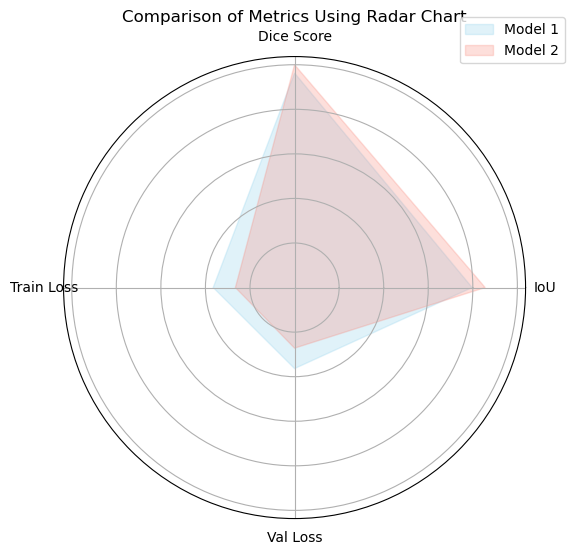

In [ ]:
max_value = max(max(model1_metrics.values()), max(model2_metrics.values()))
model1_values_norm = [model1_metrics[metric] / max_value for metric in metrics]
model2_values_norm = [model2_metrics[metric] / max_value for metric in metrics]

angles = np.linspace(0, 2 * np.pi, len(metrics), endpoint=False).tolist()

model1_values_norm += model1_values_norm[:1]
model2_values_norm += model2_values_norm[:1]
angles += angles[:1]

fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
ax.fill(angles, model1_values_norm, color='skyblue', alpha=0.25, label='Model 1')
ax.fill(angles, model2_values_norm, color='salmon', alpha=0.25, label='Model 2')

ax.set_yticklabels([])
ax.set_xticks(angles[:-1])
ax.set_xticklabels(metrics)

ax.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))

plt.title('Comparison of Metrics Using Radar Chart')
plt.show()